<a href="https://colab.research.google.com/github/Harvey-MSKim/MPC-Project---Trajectory-Generation-Using-MPC-For-High-Speed-Overtaking/blob/main/MPC_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MPC Project - Trajectory-Generation-Using-MPC-For-High-Speed-Overtaking**

In this project, model predictive control is applied to a vehicle overtaking slower moving vehicles in a one way, two lane road. A risk map is defined considering the road boundaries, the center of the two lanes, and distance relative to other vehicles. The results of this study found that the vehicle was able to conduct safe lane changes while avoiding unsafe regions defined by the risk map

# Packages and tools needed for the project

In [2]:
# This cell is commented out because Polytope package, Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

     |████████████████████████████████| 51 kB 3.4 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=06394caced0815d84745c967b482414b3869a2432e65875342c46d5f55340f4d
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 4.5 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155225 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Un

In [3]:
import polytope as pt
import numpy as np
from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
                    
    return pt.qhull(np.asarray(V_sum))

def pontryagin_diff(X, Y):
    
    # X, Y should have the same dimenson
    # X - Y
    m, n = X.A.shape
    H = [] 
    for i in range(X.A.shape[0]):
        x = cp.Variable(n)
        prob = cp.Problem( cp.Maximize(X.A[i, :] @ x), [Y.A @ x <= Y.b] )
        prob.solve()
        H.append(prob.value)
        
    H = np.reshape(np.asarray(H), (len(H), 1))
        
    return pt.Polytope(X.A, X.b - H)

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)
        
    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def successor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    # Xset, Uset shoud be polytope
    # print(Xset)
    # print(A)
    # print(Uset)
    # print(B)
    # autonomous case: xdot = Ax
    if not B.any():
        if not pt.is_empty(Wset):
            return minkowski_sum(pt.qhull(pt.extreme(Xset) @ A.T), Wset)
        else:
            return pt.qhull(pt.extreme(Xset) @ A.T)
    
    # controlled case: xdot = Ax+Bu
    if not pt.is_empty(Wset):
        return minkowski_sum(minkowski_sum(pt.extreme(Xset) @ A.T, 
                                           pt.extreme(Uset) @ B.T), Wset)
    else:
        return minkowski_sum(pt.extreme(Xset) @ A.T, 
                     pt.extreme(Uset) @ B.T)

def Oinf(Xset, A, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A).intersect(Omega)
    return Omegap

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap


# Model description and System parameters

<center>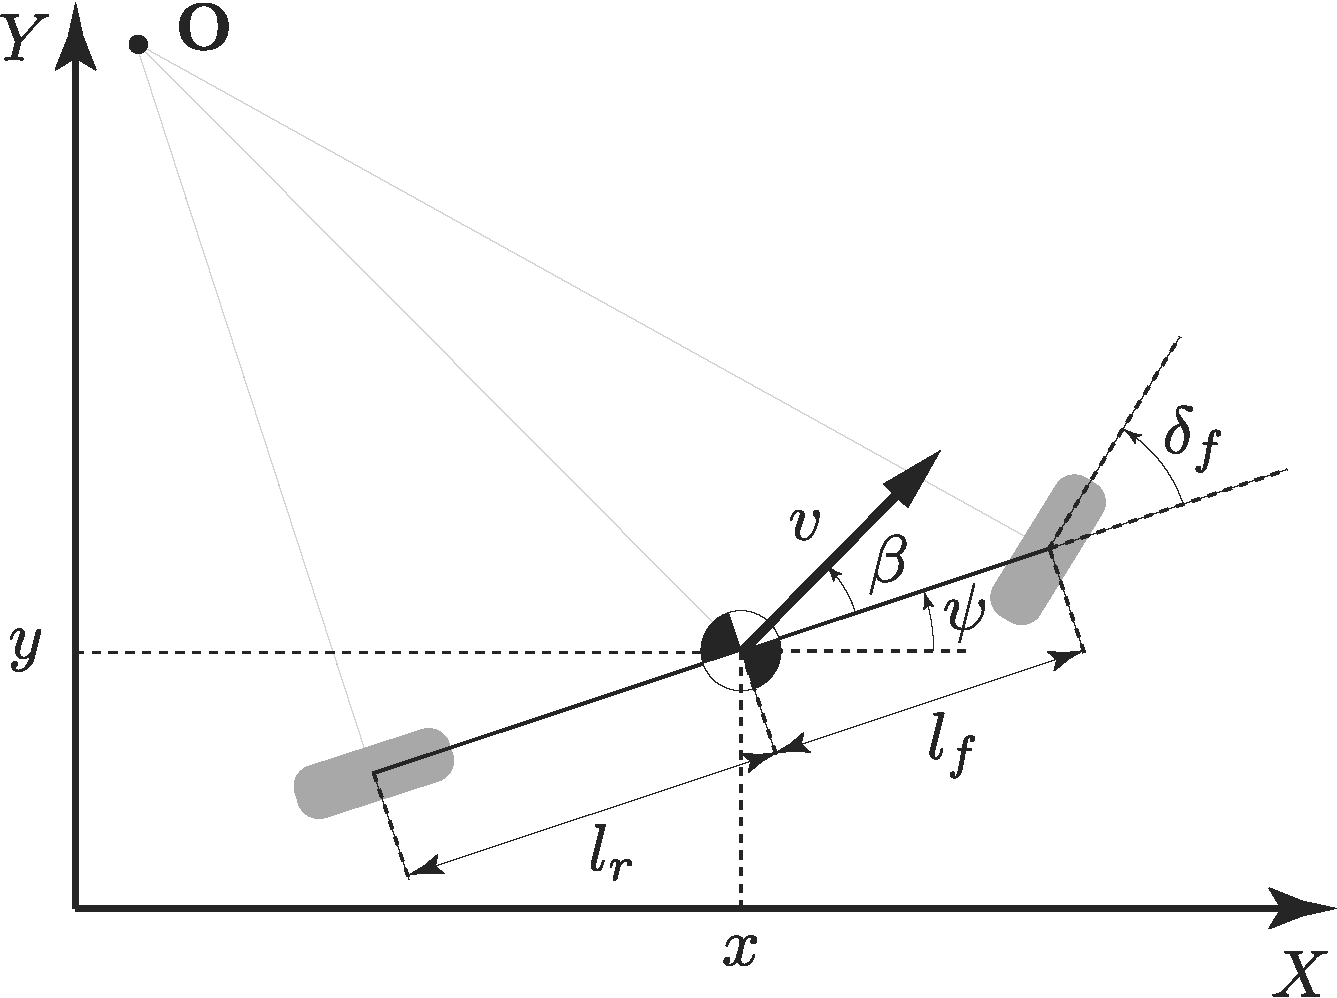 </center>

Consider a simplified kinematic bicycle model :

\begin{align}
\dot{x} &= v \cos(\psi+\beta)\\ 
\dot{y} &= v \sin(\psi+\beta)\\
\dot{\psi} &= \frac{v}{l_r} \sin(\beta)\\
\dot{v} &= a \\
\beta &= \tan^{-1} \left( \frac{l_r}{l_f+l_r}  \tan(\delta_f)\right)
\end{align}

If assume {\delta_f}, {\psi} and {\beta} are small, we can approximize the system as below : 

\begin{align}
\dot{x} &= v \\ 
\dot{y} &= v{\psi} + \frac{l_r}{l_f+l_r}v{\delta_f} \\
\dot{\psi} &= \frac{1}{l_f+l_r}v{\delta_f} \\
\dot{v} &= a \\
\end{align}

Reference : https://ieeexplore.ieee.org/document/8734145/ - Trajectory Planning for Autonomous High-Speed Overtaking in Structured Environments Using Robust MPC

In [4]:
# Car model

#---------------- Parameters ---------------#
### Road Geometry #####
lane_width = 3.5 # [m]
num_lane = 2

### SV (Subject Vehicle) parameter ###
l_f = 1.446 # [m]
l_r = 1.477 # [m]
SV_v_desired = 32.67 # [m/s]


SV_initial_x = 0 # [m]
SV_initial_y = lane_width/2*3 # [m]
SV_initial_psi = 0
SV_initial_v = SV_v_desired # [m/s]

### LV (Lead Vehicle) parameter ###
# Assume they don't change their lane and run in a constant velocity
num_LV = 3
LV_l_long = 4.1
LV_w_lat = 1.7
wedge_back = 40 # modified 1
wedge_head = 40 # modified 100

# LV_information 
## For showing cacenlling lane change : SV_initial_x - 93.5, vel = 45 for the second LV
# LV_initialize  = np.array([[SV_initial_x + 80, SV_initial_x + 80, SV_initial_x + 240],  # x coordinate [m] # modified. 110 220 330. Threshold : 80
#                            [lane_width/2, lane_width/2*3, lane_width/2],       # y coordinate [m]
#                            [22.5, 22.5, 22.5]])                                           # velocity [m/s]

# # Default MPC Cost Matrix Setting
# P = np.eye(4)
# Q = np.diag([0.0, 0.2, 0.01, 10])
# R = np.diag([1.5, 200]) 
# Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
# bf = np.array([0.0, 0.0, 0.0, 0.0])

### Potential Field ###
A_car = 10
Xi = 3
A_lane = 36
sigma = 0.14 * lane_width
alpha = 0.16
Vertice = [[100, 0], [100, num_lane*lane_width], [-60, num_lane*lane_width], [-60, 0]]
U_safe = 10
grid_length = 0.01

### System Parameters ###
# SV_x has no limit
SV_y_lower = 0 # lower limit of y
SV_y_upper = num_lane*lane_width
SV_psi_lower = -0.05
SV_psi_upper = 0.05
SV_v_lower = 0
SV_v_upper = 35

SV_a_upper = 2.0 # [m/s^2]
SV_a_lower = -2.0
SV_delta_upper = 0.03 # [rad]
SV_delta_lower = -0.03

X_set = pt.Polytope(np.array([[1.0, 0, 0, 0],
                              [-1.0, 0, 0, 0],
                              [0, 1.0, 0, 0],
                               [0, -1.0, 0, 0],
                               [0, 0, 1.0, 0],
                               [0, 0, -1.0, 0],
                               [0, 0, 0, 1.0],
                               [0, 0, 0, -1.0]]), 
                    np.array([[np.Inf],
                              [np.Inf],
                              [SV_y_upper],
                            [-SV_y_lower],
                            [SV_psi_upper],
                            [-SV_psi_lower],
                            [SV_v_upper],
                            [-SV_v_lower]]))

U_set = pt.Polytope(np.array([[1.0, 0],
                              [-1.0, 0],
                              [0, 1.0],
                              [0, -1.0]]), 
                    np.array([[SV_a_upper],
                              [-SV_a_lower],
                              [SV_delta_upper],
                              [-SV_delta_lower]]))

print(X_set)

### Driving mode ###
CRUISE_MODE = 0;
OVERTAKE_MODE = 1;


Single polytope 
  [[ 1.  0.  0.  0.] |    [[  inf]
   [-1.  0.  0.  0.] |     [  inf]
   [ 0.  1.  0.  0.] |     [ 7.  ]
   [ 0. -1.  0.  0.] x <=  [ 0.  ]
   [ 0.  0.  1.  0.] |     [ 0.05]
   [ 0.  0. -1.  0.] |     [ 0.05]
   [ 0.  0.  0.  1.] |     [35.  ]
   [ 0.  0.  0. -1.]]|     [ 0.  ]]



# Class and Functions

Class - Class for vehicles (My vehicle := Subject Vehicle, Obstacle vehicle := Leading vehicle)

Functions - Functions needed for the project, including calculating reachable set, risk map, target point, etc



In [18]:
class Subject_vehicle :
  def __init__(self, init_x, init_y, init_psi, l_f = l_f, l_r = l_r, length = LV_l_long, width = LV_w_lat, init_vel = SV_initial_v, drive_mode = OVERTAKE_MODE, sampling_time = 0.2) :
    self.l_f = l_f
    self.l_r = l_r
    self.state = np.array([init_x, init_y, init_psi, init_vel])
    self.length = length
    self.width = width
    self.A = np.array([[1.0, 0, 0, sampling_time],
                       [0, 1.0, self.state[3]*sampling_time, 0],
                       [0, 0, 1.0, 0],
                       [0, 0, 0, 1]])
    self.B = np.array([[0, 0],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r) * self.l_r],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r)],
                       [sampling_time, 0]])
    self.lane_thresh = 0.05    # if SV stays 0.8m away from the head_lane, we suppose it successfully changed the lane.
    
    for i in range(num_lane) :
      if self.state[1] > i*lane_width and self.state[1] <= (i+1)*lane_width :
        self.curr_lane = num_lane - i
        self.head_lane = self.curr_lane

    self.drive_mode = drive_mode

  def getState(self) :
    return self.state

  def update_state_approx(self, input) :
    self.state = self.A @ self.state + self.B @ input
    self.set_curr_lane()

  def update_state_Notapprox(self, input) :
    beta = np.arctan( self.l_r / (self.l_f + self.l_r) * np.tan(input[1]))
    self.state += sampling_time * np.array([self.state[3] * np.cos(beta + self.state[2]),
                                            self.state[3] * np.sin(beta + self.state[2]),
                                            self.state[3]/self.l_r*np.sin(beta),
                                            input[0]])
    self.set_curr_lane()
  
  def getLaneInfo(self) :
    return [self.curr_lane, self.head_lane]

  def getDriveMode(self) :
    return self.drive_mode
  
  def set_curr_lane(self) :
    head_lane_y = lane_width/2 + lane_width*(num_lane - self.head_lane)
    if abs(head_lane_y - self.state[1]) < self.lane_thresh :
      self.curr_lane = self.head_lane

  def set_head_lane(self, target_point) :
    for i in range(num_lane) :
      if target_point[1] >= i*lane_width and target_point[1] < (i+1)*lane_width :
        self.head_lane = num_lane - i
        break

  def set_drive_mode(self, drive_mode) :
    self.drive_mode = drive_mode
  
  


class Lead_vehicle :
  def __init__(self, init_x, init_y, vel, length = LV_l_long, width = LV_w_lat, _wedge_back = wedge_back, _wedge_head = wedge_head) :
    self.pos = np.array([init_x, init_y])
    self.length = length
    self.width = width
    self.vel = vel
    self.wedge_back = _wedge_back
    self.wedge_head = _wedge_head
    self.pos_pred = np.array([self.pos[0] + N*sampling_time*self.vel, self.pos[1]])

  def getVelocity(self) :
    return self.vel

  def setVelocity(self, vel) :
    self.vel = vel

  def getPosition(self) :
    return self.pos

  def getPosition_predict(self) :
    return self.pos_pred
  
  def updatePosition(self) :
    self.pos[0] += sampling_time * self.vel
    self.pos_pred[0] = self.pos[0] + N*sampling_time*self.vel

  def getWedgePoints(self) :
    return np.array([[self.pos[0] - self.length/2 - self.wedge_back, self.pos[1]],
                     [self.pos[0] - self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2 + self.wedge_head, self.pos[1]],
                     [self.pos[0] + self.length/2, self.pos[1] - self.width/2],
                     [self.pos[0] - self.length/2, self.pos[1] - self.width/2]])
    
  def getWedgePoints_predict(self) :
    current_WedgePoints = self.getWedgePoints()
    current_WedgePoints[:,0] += N*sampling_time*self.vel
    return current_WedgePoints
  
  def makePolytope(self, vertices) :
    A = np.empty((6,2))
    B = np.empty((6,1))
    idx = 0
    for i in [1,3,4,0] :
      x1, y1, x2, y2 = [vertices[i,0], vertices[i,1], vertices[i-1,0], vertices[i-1,1]]
      a = (y2-y1)/(x2-x1)
      b = y1 - a*x1
      if i in [1,3] :
        A[idx,:] = [-a, 1.0]
        B[idx,:] = [b]
      else :
        A[idx,:] = [a, -1.0]
        B[idx,:] = [-b]
      idx += 1
    A[4:,:] = [[0, 1.0], [0, -1.0]]
    B[4:,:] = [[self.width/2 + self.pos[1]], [self.width/2 - self.pos[1]]]

    return pt.Polytope(A, B)

  def getPolytope(self) :
    vertices = self.getWedgePoints()
    return self.makePolytope(vertices)

  def getPolytope_predict(self) :
    vertices = self.getWedgePoints_predict()
    return self.makePolytope(vertices)

  ###### For Animation ###############
  def getVertice_anim(self, position) :
    vertice_x = np.array([[position[0] + self.length/2, position[0] - self.length/2, position[0] - self.length/2, position[0] + self.length/2]])
    vertice_y = np.array([[position[1] + self.width/2,  position[1] + self.width/2,  position[1] - self.width/2,  position[1] - self.width/2]])
    vertice = np.concatenate((vertice_x.T, vertice_y.T), axis=1)
    return vertice

  def getWedgePoints_anim(self, position) :
    WedgePoints = np.array([[position[0] - self.length/2 - self.wedge_back, position[1]],
                            [position[0] - self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2 + self.wedge_head, position[1]],
                            [position[0] + self.length/2, position[1] - self.width/2],
                            [position[0] - self.length/2, position[1] - self.width/2]])
    return WedgePoints

# SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
# LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
# LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
# print(LV1.getPosition())
# fig, ax = plt.subplots(1,2)
# X = LV1.getPolytope()
# X_pred = LV1.getPolytope_predict()
# X.plot(ax[0], color='b')
# X_pred.plot(ax[0], color='r')
# ax[0].autoscale_view()
# ax[0].set_zlim([-10,10])
# ax[0].axis('equal')


In [9]:
# Detect LVs
# Should detect LVs within 100m from SV
# Should know which LV is in front of SV or on the lane to which SV plans to move
def detect_LV(SV, LV_list) :
  x, v = SV.getState()[[0,3]]
  x_pred = x + v * sampling_time * N
  idx_front = -1
  idx_side_behind = -1
  idx_side_front = -1
  min_x_i = np.inf
  min_x_i_side = np.inf
  max_x_i_pred = -1

  
  for i in range(len(LV_list)) :
    lane_i = 0

    # get lane information of each LV
    [x_i, y_i] = LV_list[i].getPosition()
    for j in range(num_lane) :
      if y_i >= j*lane_width and y_i < (j+1)*lane_width :
        lane_i = num_lane - j
        break

    # Find out LV in front of SV
    if lane_i == SV.curr_lane :
      if x_i > x and x_i < min_x_i :
        min_x_i = x_i
        idx_front = i

    # Find out LV on the lane to which SV plans to move (All LVs whose predicted position is behind predicted position of SV)
    # In this case, since there are only 2 lanes, just 'else' is enough
    else :
      if x < x_i and x_i < min_x_i_side : 
        min_x_i_side = x_i
        idx_side_front = i

      x_i_pred = LV_list[i].getPosition_predict()[0]
      if x_pred > x_i_pred and x_i_pred > max_x_i_pred :
        max_x_i_pred = x_i_pred
        idx_side_behind = i
      
    
  return [idx_front, idx_side_behind, idx_side_front]
#-------------------------------------------------------------------------------#

# Reachability set - without accelerating
# with original system and ts=0.1, 20 step : 3m 17s
# with simple system and ts=0.2, 10 step : 1s (erasing acceleration term from the input vector)
# with simple system and ts=0.1, 20 step : 5s

def get_reachable_set(x0, y0, psi0, v0, ts, N, SV) :
  # set acceleration as (desired_vel - curr_vel) / Predict horizon
  # accel * sampling time is,
  a_ts = (SV_v_desired - SV.getState()[3]) / N
  X_tmp = np.array([0.0, 0.0, 0.0, a_ts])
  
  eps_pos = 0.01
  eps = 0.001
  A_sys = np.array([[1.0, 0, 0, ts],
                    [0, 1.0, v0*ts, 0],
                    [0, 0, 1.0, 0],
                    [0, 0, 0, 1.0]])
  '''
  B_sys = np.array([[0, 0],
                    [0, v0*l_r*ts/(l_f+l_r)],
                    [0, v0*ts/(l_f+l_r)],
                    [ts, 0]])
  '''
  B_sys = np.array([[0],
                    [v0*l_r*ts/(l_f+l_r)],
                    [v0*ts/(l_f+l_r)],
                    [0]])
  X = pt.Polytope(np.array([[1.0, 0, 0, 0], 
                            [-1.0, 0, 0, 0],
                            [0, 1.0, 0, 0],
                            [0, -1.0, 0, 0],
                            [0, 0, 1.0, 0],
                            [0, 0, -1.0, 0],
                            [0, 0, 0, 1.0],
                            [0, 0, 0, -1.0]]), 
                  np.array([[x0], 
                            [-x0+2*eps_pos],
                            [y0+eps_pos],
                            [-y0+eps_pos],
                            [psi0+eps],
                            [-psi0+eps],
                            [v0],
                            [-v0+2*eps]]))
  '''
  U = pt.Polytope(np.array([[1.0, 0], 
                            [-1.0, 0],
                            [0, 1.0],
                            [0, -1.0]]),
                  np.array([[0.0], 
                            [-SV_a_lower],
                            [SV_delta_upper],
                            [-SV_delta_lower]]))
  '''
  U = pt.Polytope(np.array([[1.0],
                            [-1.0]]),
                  np.array([[SV_delta_upper],
                            [-SV_delta_lower]]))
  
  for i in range(N) :
    # print(str(i) + 'th successor calculation')
    X = successor(X, A_sys, U, B_sys)
    X.b += X.A @ X_tmp
    X = X.intersect(X_set)
  return X

def get_point_in_2D_bbox(reachable_set, test = False) :
  pt_tmp = reachable_set.project([1,2])  # project the reachable set to x-y plane
  pt_tmp = pt_tmp.bounding_box           # pt_tmp = two corner of the bounding box of the projection : left_lower, right_upper
  x = np.arange(pt_tmp[0][0,0], pt_tmp[1][0,0], grid_length)
  
  threshold = 0.001
  if pt_tmp[0][1,0] < threshold :
    pt_tmp[0][1,0] += grid_length
  if pt_tmp[1][1,0] > num_lane*lane_width - threshold :
    pt_tmp[1][1,0] -= grid_length
    
  y = np.arange(pt_tmp[0][1,0], pt_tmp[1][1,0], grid_length)

  # Only for test - return points on large area
  if test :
    x = np.linspace(40, 70, 100)
    y = np.linspace(grid_length, num_lane*lane_width-grid_length, 100)
  ########
  
  xx, yy = np.meshgrid(x, y)
  return xx, yy

##### Potential Funtions - road potential, lane potential, car potential #####

# road potential - a potential function that prevents SV from getting closer to edges of the road
def road_potential(target) :
  road_risk = 0.5*Xi*((1/(target[1]-num_lane*lane_width))**2 + (1/target[1])**2)
  return road_risk

# lane potential - a potential function that forces SV to stay in the middle of the road
def lane_potential(target) :
  lane_risk = 0
  for i in range(num_lane+1) : 
    lane_risk += A_lane * np.exp( -(target[1]-i*lane_width)**2 / (2*(sigma**2)) )
  return lane_risk

# car_potential - a potential function that make SV stay away from LVs.
def car_potential(target, LV, turn_off) :
  if target in LV.getPolytope_predict() :  # modified LV.getPolytope()
    return np.Inf

  if turn_off :
    return 0
  point = LV.getWedgePoints_predict()     # modified LV.getWedgePoints()
  length = np.linalg.norm(target - point[0])
  for i in range(point.shape[0]-1) :
    tmp = np.linalg.norm(target - point[i+1])
    if length > tmp :
      length = tmp

  car_risk = A_car * (np.exp(-alpha*length)) / length 
  return car_risk

# Get risk value based on potential functions. If the return value is lower than U_safe, it's safe
def risk_value(target, _LV1, _LV2=None, _LV3=None, car_potential_off = True) :
  if _LV2 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off)
  if _LV3 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off)
  return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off) + car_potential(target, _LV3, car_potential_off)
#----------------------------------------------------------------------------#

# Among the points in reachable set, choose a target point using the risk map
def get_target_state(risk_map, SV, initial_x, LV_info, LV_list, print_safe_map = False) :
  safe_map = risk_map[:, risk_map[2,:] < U_safe]             # filter the points in risk map that pass safe standard
  
  # get drive_mode from the decision layer
  drive_mode = Drive_mode_decision(safe_map, SV, LV_info, LV_list)
  
  if drive_mode == CRUISE_MODE :
    SV.set_drive_mode(CRUISE_MODE)                                              # Set cruise mode
    [target_x, target_y] = LV_list[LV_info[0]].getWedgePoints_predict()[0,:]
    target_x -= 3
    target_vel = LV_list[LV_info[0]].getVelocity()
    target_psi = 0.0
    target_state = np.array([target_x, target_y, target_psi, target_vel, 0])    # set the target point as the first point of wedgepoints of LV in front of SV
    return target_state
  
  # Else, it is overtake mode
  SV.set_drive_mode(OVERTAKE_MODE)
  
  # obtain the farthest safe points in x-direction, which are on the same lane as SV if it's possible
  safe_map = safe_map[:, safe_map[0,:] == np.amax(safe_map[0,:])]           

  # If there are points on the same lane as SV's current lane, set safe_map as the set of those points
  tmp = safe_map[:, (safe_map[1,:] > (num_lane - SV.getLaneInfo()[0]) * lane_width) & (safe_map[1,:] < (num_lane - SV.getLaneInfo()[0] + 1) * lane_width)]
  if np.size(tmp,1) is not 0 : 
    safe_map = tmp

  if print_safe_map :
    print('Safe map with the biggest x')
    print(safe_map)

  lowest_risk_point = safe_map[:, np.argmin(safe_map[2,:])]   # choose the safest point among the farthest safe points 
  target_vel = (lowest_risk_point[0] - initial_x) / (sampling_time*N)
  target_psi = 0.0
  target_state = np.array([lowest_risk_point[0], lowest_risk_point[1], target_psi, target_vel, lowest_risk_point[2]])
  # print(target_state)
  SV.set_head_lane(target_state[:2])
  
  return target_state

def Drive_mode_decision(safe_map, SV, LV_info, LV_list) :
  # The case that triggers cruise mode : when there is no safe point
  if np.size(safe_map,1) == 0 :
    return CRUISE_MODE

  # The case that triggers overtake mode from cruise mode
  if SV.getDriveMode() == CRUISE_MODE :
    # when there's no car ahead of SV on the other lane, or the car is far enough from SV to safely change the lane
    if LV_info[2] == -1 or LV_list[LV_info[2]].getPosition()[0] > np.amax(safe_map[0,:]) :
      return OVERTAKE_MODE
    else  :
      return CRUISE_MODE

  # else cases : maintain overtake mode  
  return OVERTAKE_MODE
  #---------------------------------------------------------------------------#


# Test Cell

In [ ]:
#### test ####
'''
test = get_reachable_set(SV_initial_x, SV_initial_y, 0.03, SV_initial_v, 0.2, 10)
get_point_in_2D_bbox(test)
X = test.project([1,2])
print(X)

fig, ax = plt.subplots(1,2)
X.plot(ax[0], color='b')
ax[0].legend(['X', 'X & Pre(X, W)'])
ax[0].autoscale_view()
ax[0].axis('equal')


X = X.bounding_box
print(X)
print(X[0][1,0])
for a,b in X :
  print("corner : x : " + str(a[0]) + " y : " + str(b[0]))
  '''
##########
# 6.666  ]
#  [ 1.75     1.79245]
#  [ 0.       0.02874]
#  [33.33    33.48603
SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])

U_safe = np.Inf
xx, yy = get_point_in_2D_bbox(get_reachable_set(SV.getState()[0], SV.getState()[1], SV.getState()[2], SV.getState()[3], 0.2, 10), False)
risk_map = np.zeros((3,xx.size))
index = 0
for i in range(xx.shape[0]) :
  for j in range(xx.shape[1]) :
    risk_map[0,index] = xx[i,j]
    risk_map[1,index] = yy[i,j]
    risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1)
    index += 1

test_target_point = get_target_state(risk_map, SV.getState()[0])
risk_map = risk_map[:, risk_map[2,:]<U_safe]

ax = plt.axes(projection='3d')
ax.scatter3D(risk_map[0,:], risk_map[1,:], risk_map[2,:], alpha = 0.1, c = risk_map[0,:] + risk_map[1,:] +risk_map[2,:], cmap = plt.get_cmap('hsv'))
ax.scatter3D(test_target_point[0], test_target_point[1], test_target_point[4])
ax.set_zlim(0, 150);
print('SV state : ')
print(SV.getState())
print('LV position - LV1 : ')
print(LV1.getPosition())
print('LV2 : ')
print(LV2.getPosition())
print(test_target_point)


# Design MPC

In [10]:
# Solve CFTOC for car
from __future__ import division

def solve_cftoc_onlyCar(A, B, P, Q, R, N, x0, X_set, U_set, bf, Af, SV, LV_info, LV_list, add_extra_constraint, reachable_set = None) :
  model = pyo.ConcreteModel()
  model.A = A
  model.B = B
  model.P = P
  model.Q = Q
  model.R = R
  model.N = N
  model.Af = Af
  model.SV = SV
  model.LV_front = LV_list[LV_info[0]]  if LV_info[0] != -1 else None
  model.LV_side = LV_list[LV_info[1]]   if LV_info[1] != -1 else None
  model.X_set = X_set
  model.U_set = U_set
  
  model.nx = np.size(A,1)
  model.nu = np.size(B,1)

  model.tidx = pyo.Set(initialize = range(0,N+1))
  model.xidx = pyo.Set(initialize = range(0, model.nx))
  model.uidx = pyo.Set(initialize = range(0, model.nu))

  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.target_state = bf
  model.strict_terminalConst = True

  # test
  model.target_state_stage = model.target_state
  model.target_state_stage[2] = (model.target_state[1] - x0[1])/(model.target_state[0] - x0[0])

  eps = 0.001

  def Objective_func_rule(model) :
    costP = 0
    costQ = 0
    costR = 0

    for t in model.tidx :
      for i in model.xidx :
        if t < model.N :
          costQ += (model.x[i,t] - model.target_state[i]) * model.Q[i,i] * (model.x[i,t] - model.target_state[i])

    for t in model.tidx :
      for i in model.uidx :
        if t < model.N :
          if SV.getDriveMode() == OVERTAKE_MODE :
            costR += model.u[i,t] * model.R[i,i] * model.u[i,t]
          else :
            model.target_u = np.array([(model.target_state[3] - SV.getState()[3])/(model.N*sampling_time), 0])
            # print('cruise mode')
            # print(model.target_state[0] - SV.getState()[0])
            # print(model.target_u)
            costR += (model.u[i,t] - model.target_u[i]) * model.R[i,i] * (model.u[i,t] - model.target_u[i])
    
    for i in model.xidx :
      for j in model.xidx :
        costP += (model.x[i,model.N] - model.target_state[i]) * model.P[i,j] * (model.x[j,model.N] - model.target_state[i])

    return costP + costQ + costR

  model.cost = pyo.Objective(rule = Objective_func_rule, sense = pyo.minimize)

  def Equality_constraint_rule(model, i, t) :
    return (sum(model.A[i,j] * model.x[j,t] for j in model.xidx) + sum(model.B[i,j] * model.u[j,t] for j in model.uidx)) - model.x[i,t+1] == 0 if t<model.N else pyo.Constraint.Skip

  def Initial_constraint_rule(model, i) :
    return model.x[i,0] - x0[i] == 0

  # When Af == [] & bf != [], x_terminal_value == x_target and y_terminal_value == y_target. This constraint may be modified 
  def Terminal_constraint_rule(model, i) :
    # print(model.Af)
    # print(model.target_state)
    if model.Af == [] :
      if model.target_state == [] :
        return pyo.Constraint.Skip
      else :
        model.strict_terminalConst = True
        if SV.getDriveMode() == OVERTAKE_MODE :
          print('Overtake mode - strict terminal constraint')
          return model.x[i,N] - model.target_state[i] == 0 if i<2 else pyo.Constraint.Skip   # This may be modified
        elif SV.getDriveMode() == CRUISE_MODE :
          print('Cruise mode - strict terminal constraint')
          return model.x[i,N] - model.target_state[i] == 0
    else :
      # When the terminal constraint is like target_x-eps <= x <= target_x+eps, target_y-eps <= y <= target_y+eps, ...
      model.strict_terminalConst = False
      if np.size(model.Af, 1) == 2 :
        # [x_eps, y_eps, psi_eps, v_eps] = [0.1, 0.1, 0.01, 0.01]
        # model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps, 
        #                                bf[2] + psi_eps, -bf[2] + psi_eps, bf[3] + v_eps, -bf[3] + v_eps])
        [x_eps, y_eps] = [0.1, 0.1]
        model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps])
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0
      else :
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0

  def Inequality_constraint_rule_state(model, i, t) :
    return sum(model.X_set.A[i,j] * model.x[j,t] for j in model.xidx) - model.X_set.b[i] <= 0

  def Inequality_constraint_rule_input(model, i, t) :
    return sum(model.U_set.A[i,j] * model.u[j,t] for j in model.uidx) - model.U_set.b[i] <= 0

  model.equalityConst = pyo.Constraint(model.xidx, model.tidx, rule = Equality_constraint_rule)
  model.initConst = pyo.Constraint(model.xidx, rule = Initial_constraint_rule) 
  model.terminalConst = pyo.Constraint(model.xidx, rule = Terminal_constraint_rule)
  
  model.StateConst = pyo.Constraint(range(0, np.size(model.X_set.A, 0)), model.tidx, rule = Inequality_constraint_rule_state)
  model.InputConst = pyo.Constraint(range(0, np.size(model.U_set.A, 0)), model.tidx, rule = Inequality_constraint_rule_input)
  # model.StateConst1 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] <= SV_y_upper )
  # model.StateConst2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] <= SV_psi_upper if t>0 else pyo.Constraint.Skip)
  # model.StateConst3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] <= SV_v_upper)
  # model.StateConst4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] >= SV_y_lower)
  # model.StateConst5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] >= SV_psi_lower if t>0 else pyo.Constraint.Skip)
  # model.StateConst6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] >= SV_v_lower)
  

  # For debug
  [front_x1, front_y1, front_x2, front_y2, side_x1, side_y1, side_x2, side_y2] = [0,0,1,0,0,0,1,0]
  # When the heading line and the current line are different 
  if model.SV.getLaneInfo()[0] != model.SV.getLaneInfo()[1] and add_extra_constraint :
    print('Move from lane', model.SV.getLaneInfo()[0], 'to', model.SV.getLaneInfo()[1], '. LV info : ', LV_info[0], ' ', LV_info[1])
    # When SV heads to the second lane from the first lane
    if model.SV.getLaneInfo()[0] == 1 :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[5,:]
        
        def Inequality_extraConstraint_rule_state_front(model, t) :
          return model.x[1,t] - front_y1 - ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)
     
      if(model.LV_side != None) :
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[2,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[3,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return -model.x[1,t] + side_y1 + ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    
    # When SV heads to the first lane from the second lane
    else :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[1,:]

        def Inequality_extraConstraint_rule_state_front(model, t) :
          return -model.x[1,t] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)

      if(model.LV_side != None) :
        print('bug check')
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[3,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[4,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return model.x[1,t] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    

  # print(model.StateConst)
  # if model.SV.getLaneInfo()[0] == 2 and model.SV.getLaneInfo()[1] == 1 :
  #   model.display()
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  # results_write = results.write()

  if results.solver.termination_condition == pyo.TerminationCondition.optimal :
    feas = True
  else :
    feas = False
    model.display()
  
  xOpt = np.asarray([[pyo.value(model.x[i,t]) for t in model.tidx] for i in model.xidx])
  uOpt = np.asarray([[pyo.value(model.u[i,t]) for t in model.tidx if t<model.N] for i in model.uidx])
  JOpt = model.cost()

  wedge_LV1 = LV_list[0].getWedgePoints()
  wedge_LV1_predicted = LV_list[0].getWedgePoints_predict();
  wedge_LV2 = LV_list[1].getWedgePoints()
  wedge_LV2_predicted = LV_list[1].getWedgePoints_predict();
  wedge_LV3 = LV_list[2].getWedgePoints()
  wedge_LV3_predicted = LV_list[2].getWedgePoints_predict();

  fig, ax = plt.subplots(1,1,figsize=(9,6))
  # actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
  ax.plot(xOpt[0,:], xOpt[1,:], 'y*--', linewidth=1)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('State Trajectory')
  ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV3[:,0], wedge_LV3[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV1_predicted[:,0], wedge_LV1_predicted[:,1], alpha = 0.2, c = 'r')
  ax.fill(wedge_LV2_predicted[:,0], wedge_LV2_predicted[:,1], alpha = 0.2, c = 'r')
  ax.fill(wedge_LV3_predicted[:,0], wedge_LV3_predicted[:,1], alpha = 0.2, c = 'r')

  if reachable_set is not None :
    reachable_set.plot(ax)
  plt.show()
  tmp_float = np.zeros((2, N+1))
  tmp_bool = np.zeros((2, N+1), dtype=bool)
  
  print('SV Lane Info : ', SV.getLaneInfo())
  print('LV info : ', LV_info)
  if model.SV.getLaneInfo()[0] != model.SV.getLaneInfo()[1] :
    for i in model.tidx :
      tmp_front = -xOpt[1,i] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(xOpt[0,i] - front_x1)
      tmp_side = xOpt[1,i] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(xOpt[0,i] - side_x1 )
      tmp_float[0,i] = tmp_front
      tmp_float[1,i] = tmp_side
      tmp_bool[0,i] = tmp_front <= 0
      tmp_bool[1,i] = tmp_side <= 0

    print(tmp_float)
    print(tmp_bool)

  return [feas, xOpt, uOpt, JOpt]

In [11]:
# MPC Cost Martix
def MPC_cost_matrix(target_state, SV) :  
  if SV.getDriveMode() == OVERTAKE_MODE :
    P = np.eye(4)
    Q = np.diag([0.0, 0.2, 0.01, 10]) # modified. [1,1] = 0.2
    R = np.diag([1.5, 200]) # modified 200
    Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
    bf = target_state[:4]
    return [P, Q, R, Af, bf]

  elif SV.getDriveMode() == CRUISE_MODE :
    P = 50 * np.eye(4)
    P[3,3] = 150
    Q = np.diag([0.0, 0.01, 0.01, 0.0]) # modified. [1,1] = 0.2
    R = np.diag([250, 50]) # modified 200
    Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
    bf = target_state[:4]
    return [P, Q, R, Af, bf]

risk value :  0.6458622757914284
[98.004    5.17729  0.      32.668    0.64586]
[98.004    5.17729  0.      32.668    0.64586]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


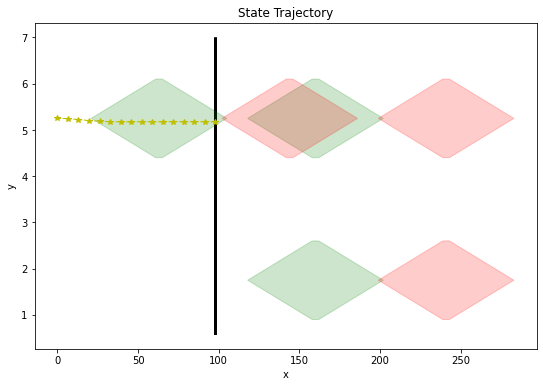

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[98.004    5.17729 -0.00074 32.668    0.64586]
0 th step ended
[98.004    5.17729 -0.00074 32.668    0.64586]
[98.004    5.17729 -0.00074 32.668    0.64586]
[98.004    5.17729 -0.00074 32.668    0.64586]
[98.004    5.17729 -0.00074 32.668    0.64586]
---------------------------------------------------------------------
risk value :  0.6458465540927371
[104.53671   5.17663   0.       32.66757   0.64585]
[104.53671   5.17663   0.       32.66757   0.64585]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


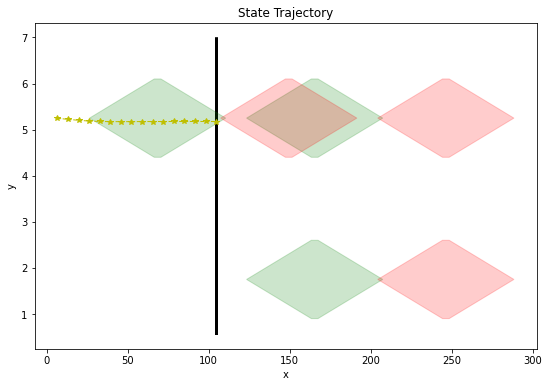

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[104.53671   5.17663  -0.0007   32.66757   0.64585]
1 th step ended
[104.53671   5.17663  -0.0007   32.66757   0.64585]
[104.53671   5.17663  -0.0007   32.66757   0.64585]
[104.53671   5.17663  -0.0007   32.66757   0.64585]
[104.53671   5.17663  -0.0007   32.66757   0.64585]
---------------------------------------------------------------------
risk value :  0.6458157367981668
[111.06946   5.17374   0.       32.66722   0.64582]
[111.06946   5.17374   0.       32.66722   0.64582]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


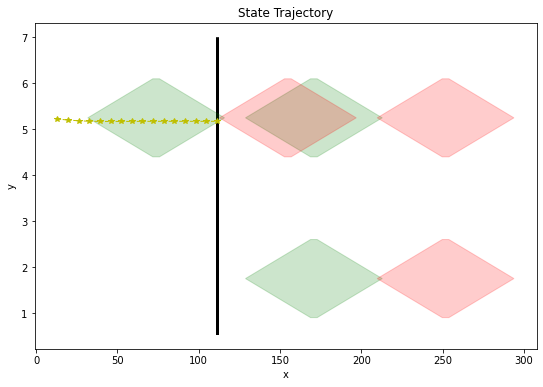

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[111.06946   5.17374  -0.00051  32.66722   0.64582]
2 th step ended
[111.06946   5.17374  -0.00051  32.66722   0.64582]
[111.06946   5.17374  -0.00051  32.66722   0.64582]
[111.06946   5.17374  -0.00051  32.66722   0.64582]
[111.06946   5.17374  -0.00051  32.66722   0.64582]
---------------------------------------------------------------------
risk value :  0.6458303975310384
[117.60228   5.17573   0.       32.66694   0.64583]
[117.60228   5.17573   0.       32.66694   0.64583]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


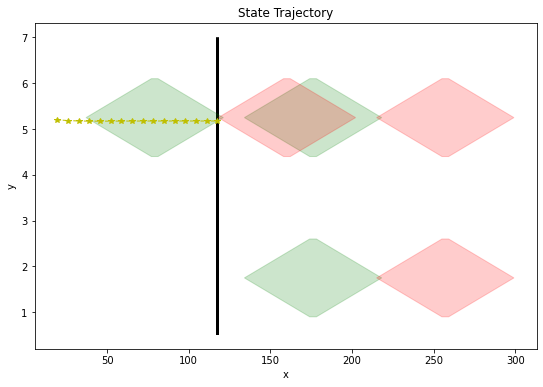

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[117.60228   5.17573  -0.00027  32.66694   0.64583]
3 th step ended
[117.60228   5.17573  -0.00027  32.66694   0.64583]
[117.60228   5.17573  -0.00027  32.66694   0.64583]
[117.60228   5.17573  -0.00027  32.66694   0.64583]
[117.60228   5.17573  -0.00027  32.66694   0.64583]
---------------------------------------------------------------------
risk value :  0.6458249636634785
[124.13517   5.17532   0.       32.66671   0.64582]
[124.13517   5.17532   0.       32.66671   0.64582]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


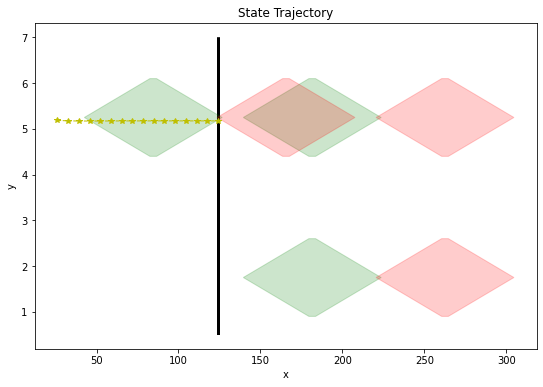

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[124.13517   5.17532  -0.00011  32.66671   0.64582]
4 th step ended
[124.13517   5.17532  -0.00011  32.66671   0.64582]
[124.13517   5.17532  -0.00011  32.66671   0.64582]
[124.13517   5.17532  -0.00011  32.66671   0.64582]
[124.13517   5.17532  -0.00011  32.66671   0.64582]
---------------------------------------------------------------------
risk value :  0.6458501117179352
[130.66812   5.17068   0.       32.66652   0.64585]
[130.66812   5.17068   0.       32.66652   0.64585]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


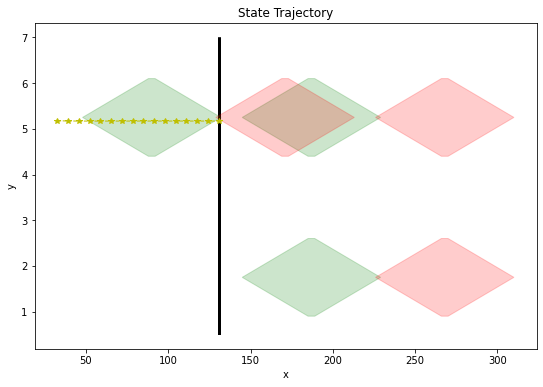

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[130.66812   5.17068  -0.00006  32.66652   0.64585]
5 th step ended
[130.66812   5.17068  -0.00006  32.66652   0.64585]
[130.66812   5.17068  -0.00006  32.66652   0.64585]
[130.66812   5.17068  -0.00006  32.66652   0.64585]
[130.66812   5.17068  -0.00006  32.66652   0.64585]
---------------------------------------------------------------------
risk value :  0.645891149006073
[137.20111   5.17827   0.       32.66637   0.64589]
[137.20111   5.17827   0.       32.66637   0.64589]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


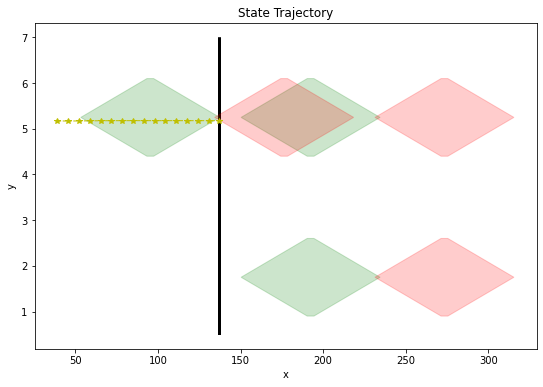

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[137.20111   5.17827   0.00006  32.66637   0.64589]
6 th step ended
[137.20111   5.17827   0.00006  32.66637   0.64589]
[137.20111   5.17827   0.00006  32.66637   0.64589]
[137.20111   5.17827   0.00006  32.66637   0.64589]
[137.20111   5.17827   0.00006  32.66637   0.64589]
---------------------------------------------------------------------
risk value :  0.6465614980384711
[143.73413   5.15956   0.       32.66624   0.64656]
[143.73413   5.15956   0.       32.66624   0.64656]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


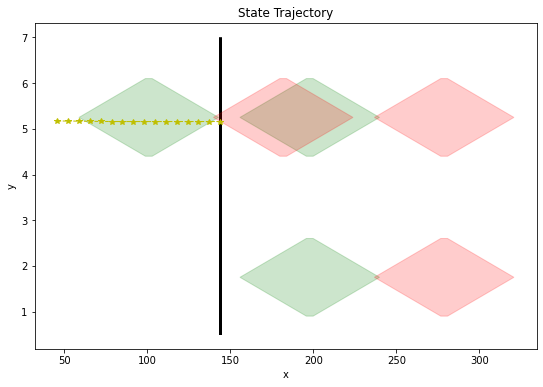

SV Lane Info :  [1, 1]
LV info :  [0, -1, 2]
[143.73413   5.15956  -0.00011  32.66624   0.64656]
7 th step ended
[143.73413   5.15956  -0.00011  32.66624   0.64656]
[143.73413   5.15956  -0.00011  32.66624   0.64656]
[143.73413   5.15956  -0.00011  32.66624   0.64656]
[143.73413   5.15956  -0.00011  32.66624   0.64656]
---------------------------------------------------------------------
risk value :  0.6458160922915697
[150.26717   1.82658   0.       32.66614   0.64582]
[150.26717   1.82658   0.       32.66614   0.64582]
Move from lane 1 to 2 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


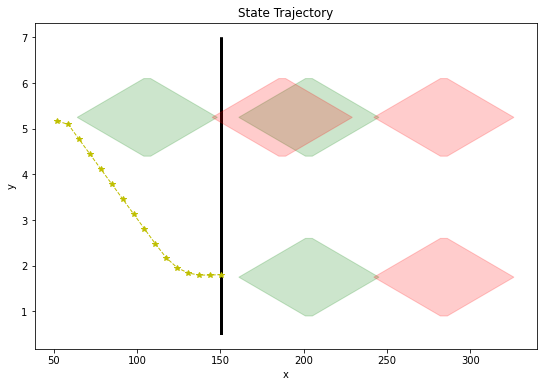

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[0.33135 0.2687  0.45657 0.64444 0.8323  1.02017 1.20804 1.39591 1.58378
  1.77165 1.93964 2.0162  1.9946  1.90006 1.76373 1.61216]
 [5.17113 5.09495 4.76825 4.44155 4.11485 3.78815 3.46145 3.13474 2.80804
  2.48134 2.17452 1.95913 1.8419  1.79761 1.79511 1.80785]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[150.26717   1.82658  -0.03413  32.66614   0.64582]
8 th step ended
[150.26717   1.82658  -0.03413  32.66614   0.64582]
[150.26717   1.82658  -0.03413  32.66614   0.64582]
[150.26717   1.82658  -0.03413  32.66614   0.64582]
[150.26717   1.82658  -0.03413  32.66614   0.64582]
---------------------------------------------------------------------
risk value :  0.6458654462214114
[156.79978   1.82994   0.       32.66606   0.64587]
[156.79978   1.82994   0.       32.66606   0.64587]
Mo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


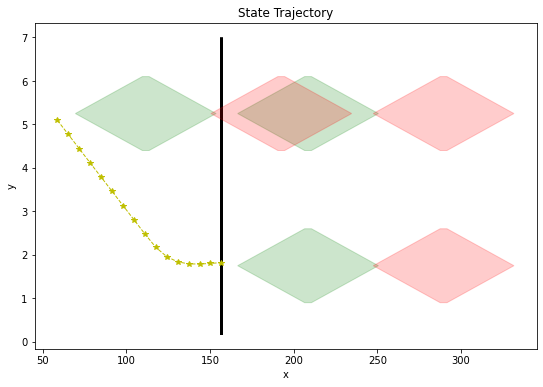

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[0.38346 0.57132 0.75919 0.94706 1.13493 1.3228  1.51067 1.69854 1.88641
  2.05447 2.13159 2.1117  2.01972 1.88533 1.73182 1.57432]
 [5.09495 4.76825 4.44155 4.11485 3.78815 3.46145 3.13475 2.80805 2.48135
  2.17446 1.9585  1.83957 1.79271 1.78827 1.80295 1.82162]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[156.79978   1.82994  -0.03332  32.66606   0.64587]
9 th step ended
[156.79978   1.82994  -0.03332  32.66606   0.64587]
[156.79978   1.82994  -0.03332  32.66606   0.64587]
[156.79978   1.82994  -0.03332  32.66606   0.64587]
[156.79978   1.82994  -0.03332  32.66606   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[163.3247    1.83      0.       32.666     0.64587]
[163.3247    1.83      0.       32.666     0.64587]
Mo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


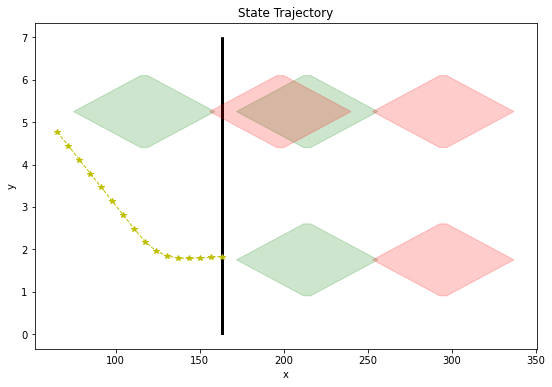

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[0.68608 0.87394 1.06181 1.24968 1.43755 1.62542 1.81329 2.00095 2.1683
  2.24557 2.22655 2.13622 2.00424 1.85355 1.69802 1.54447]
 [4.76842 4.44172 4.11502 3.78832 3.46162 3.13492 2.80822 2.48173 2.17554
  1.95944 1.83963 1.79114 1.78428 1.79614 1.81284 1.82757]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[163.3247    1.83     -0.02998  32.666     0.64587]
10 th step ended
[163.3247    1.83     -0.02998  32.666     0.64587]
[163.3247    1.83     -0.02998  32.666     0.64587]
[163.3247    1.83     -0.02998  32.666     0.64587]
[163.3247    1.83     -0.02998  32.666     0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[169.84962   1.83      0.       32.66594   0.64587]
[169.84962   1.83      0.       32.66594   0.64587]
Mo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


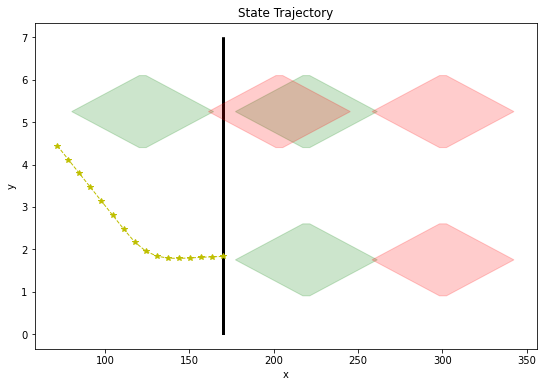

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[0.98869 1.17656 1.36443 1.5523  1.74017 1.92804 2.11571 2.28308 2.36029
  2.34125 2.25109 2.11968 1.97016 1.81645 1.66506 1.51801]
 [4.44189 4.11519 3.78849 3.46179 3.13509 2.80839 2.48189 2.17569 1.95965
  1.83986 1.79119 1.78377 1.79446 1.80934 1.8219  1.83013]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[169.84962   1.83     -0.02665  32.66594   0.64587]
11 th step ended
[169.84962   1.83     -0.02665  32.66594   0.64587]
[169.84962   1.83     -0.02665  32.66594   0.64587]
[169.84962   1.83     -0.02665  32.66594   0.64587]
[169.84962   1.83     -0.02665  32.66594   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[176.37455   1.83      0.       32.6659    0.64587]
[176.37455   1.83      0.       32.6659    0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


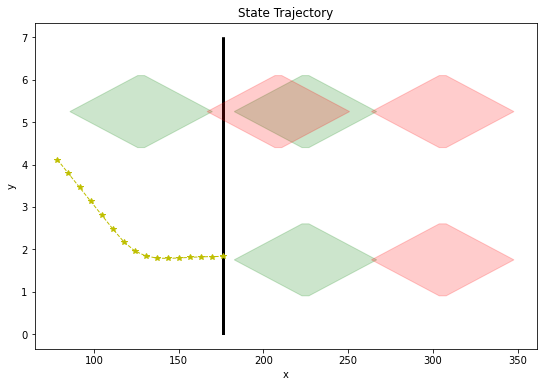

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[1.29131 1.47918 1.66705 1.85492 2.04279 2.23047 2.39785 2.47507 2.45602
  2.36585 2.23448 2.0851  1.93177 1.78107 1.63503 1.4935 ]
 [4.11537 3.78867 3.46197 3.13527 2.80857 2.48206 2.17585 1.9598  1.84002
  1.79136 1.7839  1.79444 1.80895 1.82081 1.82803 1.83072]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[176.37455   1.83     -0.02332  32.6659    0.64587]
12 th step ended
[176.37455   1.83     -0.02332  32.6659    0.64587]
[176.37455   1.83     -0.02332  32.6659    0.64587]
[176.37455   1.83     -0.02332  32.6659    0.64587]
[176.37455   1.83     -0.02332  32.6659    0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[182.8995    1.83      0.       32.66587   0.64587]
[182.8995    1.83      0.       32.66587   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


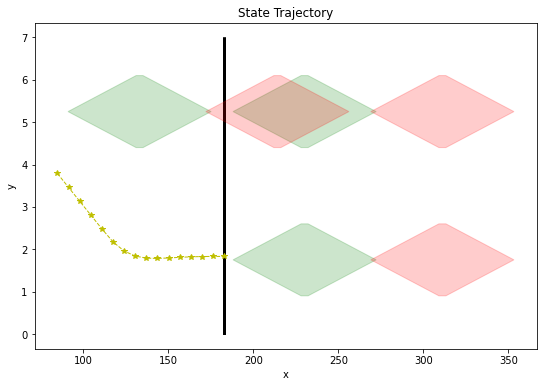

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[1.59393 1.7818  1.96967 2.15754 2.34541 2.51349 2.59078 2.57154 2.48114
  2.34959 2.20011 2.0467  1.89591 1.74969 1.60791 1.46986]
 [3.78884 3.46214 3.13544 2.80874 2.48204 2.17513 1.95902 1.83942 1.79099
  1.78371 1.79436 1.80894 1.8209  1.82829 1.83125 1.83046]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[182.8995    1.83     -0.01999  32.66587   0.64587]
13 th step ended
[182.8995    1.83     -0.01999  32.66587   0.64587]
[182.8995    1.83     -0.01999  32.66587   0.64587]
[182.8995    1.83     -0.01999  32.66587   0.64587]
[182.8995    1.83     -0.01999  32.66587   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[189.42445   1.83      0.       32.66584   0.64587]
[189.42445   1.83      0.       32.66584   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


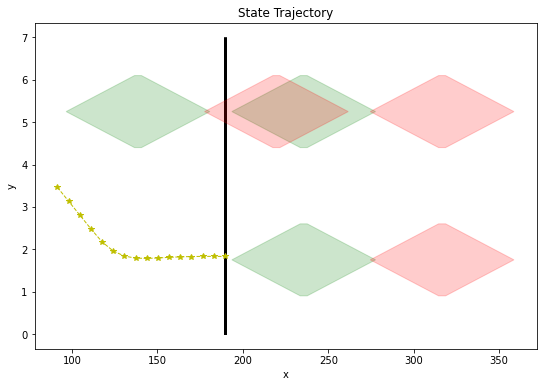

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[1.89655 2.08442 2.27229 2.46016 2.62825 2.70559 2.68642 2.5961  2.46463
  2.31523 2.16188 2.01104 1.86456 1.72211 1.58291 1.44642]
 [3.46232 3.13562 2.80892 2.48222 2.1753  1.95912 1.83946 1.79096 1.78359
  1.79416 1.80869 1.8207  1.82835 1.83196 1.83234 1.83   ]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[189.42445   1.83     -0.01666  32.66584   0.64587]
14 th step ended
[189.42445   1.83     -0.01666  32.66584   0.64587]
[189.42445   1.83     -0.01666  32.66584   0.64587]
[189.42445   1.83     -0.01666  32.66584   0.64587]
[189.42445   1.83     -0.01666  32.66584   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[195.9494    1.83      0.       32.66581   0.64587]
[195.9494    1.83      0.       32.66581   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


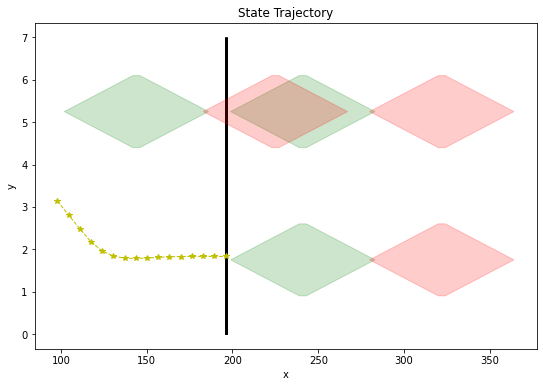

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[2.19916 2.38703 2.5749  2.743   2.82039 2.80128 2.71101 2.57962 2.43031
  2.27707 2.12633 1.97984 1.83712 1.69711 1.55908 1.42286]
 [3.1358  2.8091  2.4824  2.17547 1.95924 1.83953 1.79097 1.78353 1.79401
  1.80842 1.82033 1.82799 1.83188 1.83306 1.83226 1.82966]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[195.9494    1.83     -0.01332  32.66581   0.64587]
15 th step ended
[195.9494    1.83     -0.01332  32.66581   0.64587]
[195.9494    1.83     -0.01332  32.66581   0.64587]
[195.9494    1.83     -0.01332  32.66581   0.64587]
[195.9494    1.83     -0.01332  32.66581   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[202.47436   1.83      0.       32.6658    0.64587]
[202.47436   1.83      0.       32.6658    0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


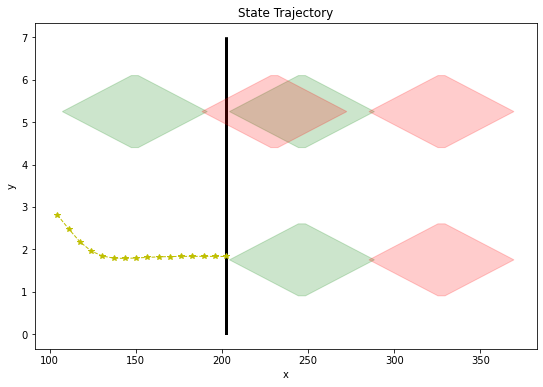

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[2.50178 2.68965 2.85776 2.9352  2.91613 2.8259  2.69454 2.54529 2.39214
  2.24153 2.09517 1.95248 1.81226 1.6735  1.53574 1.39909]
 [2.80927 2.48257 2.17563 1.95937 1.83961 1.791   1.78353 1.79395 1.80827
  1.82005 1.82759 1.83144 1.83283 1.83277 1.83169 1.82951]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[202.47436   1.83     -0.00999  32.6658    0.64587]
16 th step ended
[202.47436   1.83     -0.00999  32.6658    0.64587]
[202.47436   1.83     -0.00999  32.6658    0.64587]
[202.47436   1.83     -0.00999  32.6658    0.64587]
[202.47436   1.83     -0.00999  32.6658    0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[208.99932   1.83      0.       32.66578   0.64587]
[208.99932   1.83      0.       32.66578   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


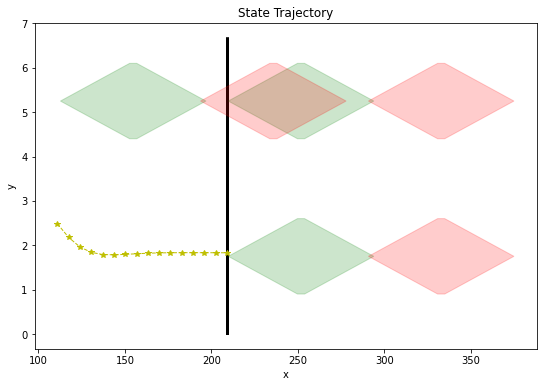

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[2.80439 2.97252 3.05    3.03098 2.94078 2.80945 2.66022 2.50711 2.35657
  2.21032 2.06777 1.92763 1.78874 1.65042 1.51249 1.37515]
 [2.48275 2.1758  1.95949 1.83968 1.79105 1.78355 1.79395 1.80823 1.81993
  1.82736 1.83108 1.83239 1.83245 1.83194 1.83104 1.82955]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[208.99932   1.83     -0.00666  32.66578   0.64587]
17 th step ended
[208.99932   1.83     -0.00666  32.66578   0.64587]
[208.99932   1.83     -0.00666  32.66578   0.64587]
[208.99932   1.83     -0.00666  32.66578   0.64587]
[208.99932   1.83     -0.00666  32.66578   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[215.52524   1.83      0.       32.66577   0.64587]
[215.52524   1.83      0.       32.66577   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


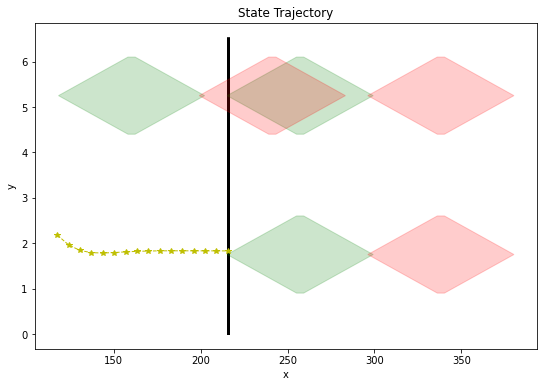

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[3.08727 3.16477 3.14579 3.05563 2.92432 2.77511 2.62201 2.4715  2.32531
  2.18285 2.04282 1.90402 1.76566 1.62736 1.48911 1.35109]
 [2.17595 1.95962 1.83977 1.7911  1.78358 1.79396 1.80823 1.81991 1.82727
  1.83091 1.83211 1.83208 1.83161 1.83107 1.8305  1.82969]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[215.52524   1.83     -0.00353  32.66577   0.64587]
18 th step ended
[215.52524   1.83     -0.00353  32.66577   0.64587]
[215.52524   1.83     -0.00353  32.66577   0.64587]
[215.52524   1.83     -0.00353  32.66577   0.64587]
[215.52524   1.83     -0.00353  32.66577   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[222.0548    1.83      0.       32.66576   0.64587]
[222.0548    1.83      0.       32.66576   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


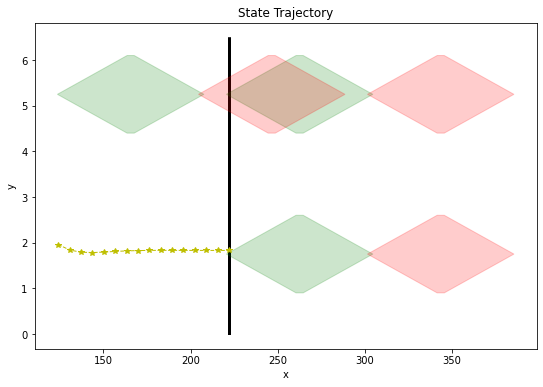

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[3.27953 3.26056 3.17042 3.03912 2.88992 2.73683 2.58632 2.44014 2.29772
  2.15774 2.01902 1.88073 1.74244 1.604   1.46545 1.32694]
 [1.95969 1.83982 1.79114 1.7836  1.79398 1.80824 1.81991 1.82726 1.83086
  1.83201 1.8319  1.83136 1.83083 1.83043 1.83015 1.82983]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[222.0548    1.83     -0.00132  32.66576   0.64587]
19 th step ended
[222.0548    1.83     -0.00132  32.66576   0.64587]
[222.0548    1.83     -0.00132  32.66576   0.64587]
[222.0548    1.83     -0.00132  32.66576   0.64587]
[222.0548    1.83     -0.00132  32.66576   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[228.58683   1.83      0.       32.66575   0.64587]
[228.58683   1.83      0.       32.66575   0.64587]
M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


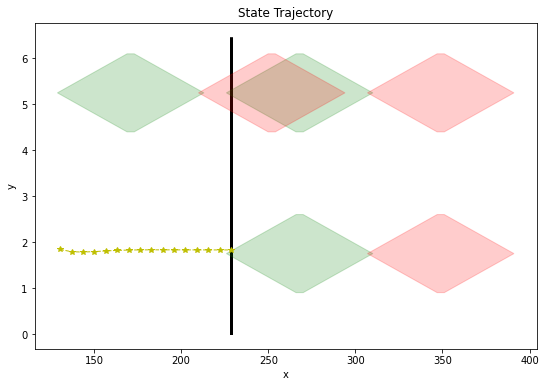

SV Lane Info :  [1, 2]
LV info :  [0, -1, 2]
[[3.37531 3.28518 3.15389 3.00469 2.8516  2.70109 2.55491 2.41249 2.27253
  2.13384 1.99559 1.85734 1.71891 1.58031 1.44157 1.30278]
 [1.83985 1.79115 1.78361 1.79398 1.80824 1.81992 1.82727 1.83086 1.83199
  1.83186 1.83128 1.8307  1.83029 1.83007 1.82997 1.82993]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
[228.58683   1.83     -0.0001   32.66575   0.64587]
20 th step ended
[228.58683   1.83     -0.0001   32.66575   0.64587]
[228.58683   1.83     -0.0001   32.66575   0.64587]
[228.58683   1.83     -0.0001   32.66575   0.64587]
[228.58683   1.83     -0.0001   32.66575   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[235.11979   1.83      0.       32.66574   0.64587]
[235.11979   1.83      0.       32.66574   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


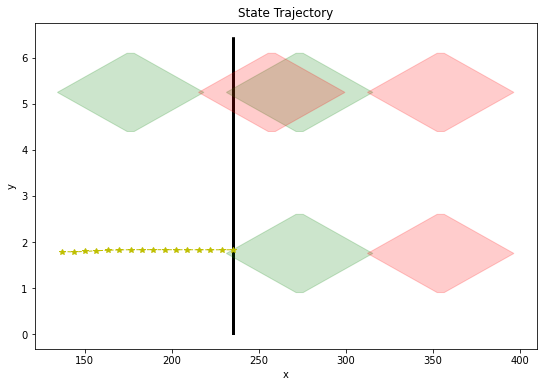

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[235.11979   1.83      0.0004   32.66574   0.64587]
21 th step ended
[235.11979   1.83      0.0004   32.66574   0.64587]
[235.11979   1.83      0.0004   32.66574   0.64587]
[235.11979   1.83      0.0004   32.66574   0.64587]
[235.11979   1.83      0.0004   32.66574   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[241.65292   1.83      0.       32.66574   0.64587]
[241.65292   1.83      0.       32.66574   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


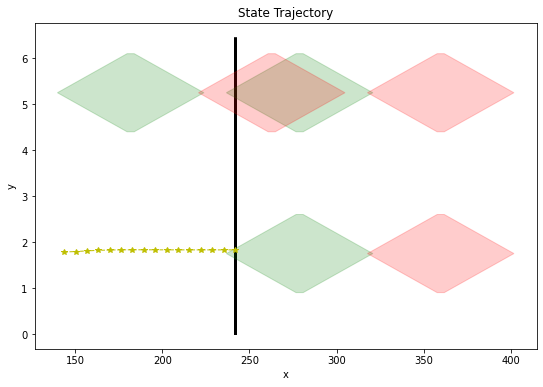

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[241.65292   1.83      0.00047  32.66574   0.64587]
22 th step ended
[241.65292   1.83      0.00047  32.66574   0.64587]
[241.65292   1.83      0.00047  32.66574   0.64587]
[241.65292   1.83      0.00047  32.66574   0.64587]
[241.65292   1.83      0.00047  32.66574   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[248.18605   1.83      0.       32.66573   0.64587]
[248.18605   1.83      0.       32.66573   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


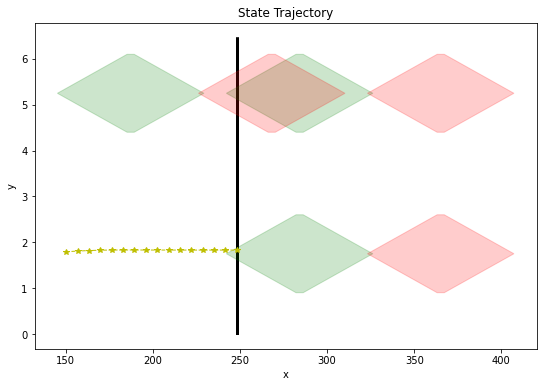

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[248.18605   1.83      0.00037  32.66573   0.64587]
23 th step ended
[248.18605   1.83      0.00037  32.66573   0.64587]
[248.18605   1.83      0.00037  32.66573   0.64587]
[248.18605   1.83      0.00037  32.66573   0.64587]
[248.18605   1.83      0.00037  32.66573   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[254.71917   1.83      0.       32.66573   0.64587]
[254.71917   1.83      0.       32.66573   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


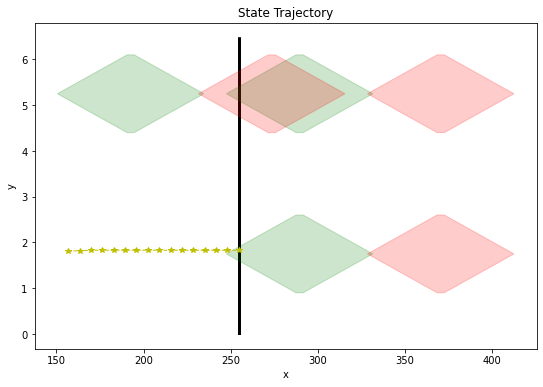

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[254.71917   1.83      0.00022  32.66573   0.64587]
24 th step ended
[254.71917   1.83      0.00022  32.66573   0.64587]
[254.71917   1.83      0.00022  32.66573   0.64587]
[254.71917   1.83      0.00022  32.66573   0.64587]
[254.71917   1.83      0.00022  32.66573   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[261.2523    1.83      0.       32.66573   0.64587]
[261.2523    1.83      0.       32.66573   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


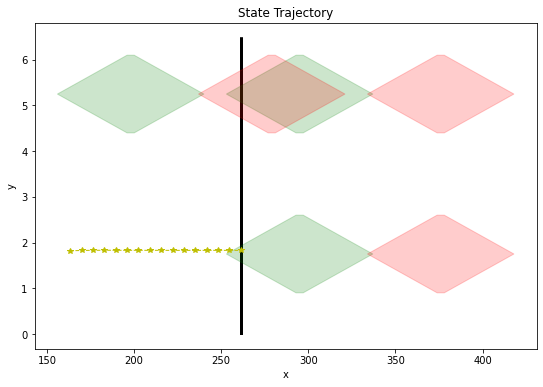

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[261.2523    1.83      0.0001   32.66573   0.64587]
25 th step ended
[261.2523    1.83      0.0001   32.66573   0.64587]
[261.2523    1.83      0.0001   32.66573   0.64587]
[261.2523    1.83      0.0001   32.66573   0.64587]
[261.2523    1.83      0.0001   32.66573   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[267.78544   1.83      0.       32.66572   0.64587]
[267.78544   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


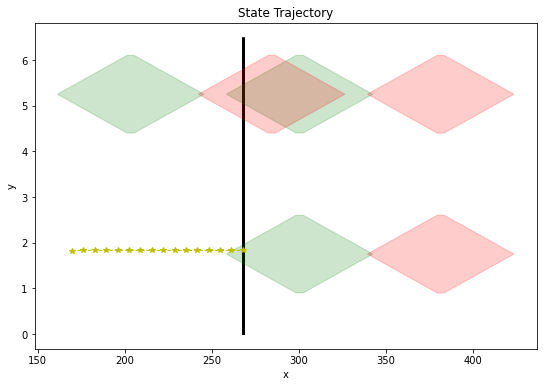

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[267.78544   1.83      0.00003  32.66572   0.64587]
26 th step ended
[267.78544   1.83      0.00003  32.66572   0.64587]
[267.78544   1.83      0.00003  32.66572   0.64587]
[267.78544   1.83      0.00003  32.66572   0.64587]
[267.78544   1.83      0.00003  32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[274.31858   1.83      0.       32.66572   0.64587]
[274.31858   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


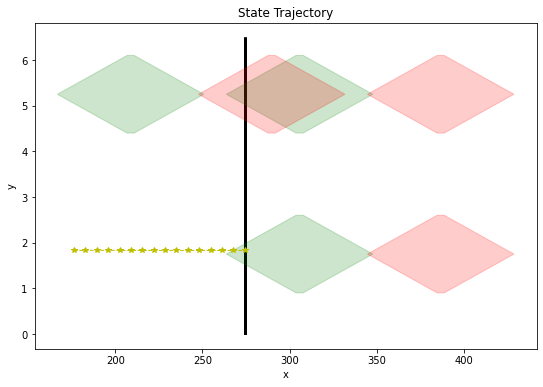

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[274.31858   1.83     -0.00001  32.66572   0.64587]
27 th step ended
[274.31858   1.83     -0.00001  32.66572   0.64587]
[274.31858   1.83     -0.00001  32.66572   0.64587]
[274.31858   1.83     -0.00001  32.66572   0.64587]
[274.31858   1.83     -0.00001  32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[280.85172   1.83      0.       32.66572   0.64587]
[280.85172   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


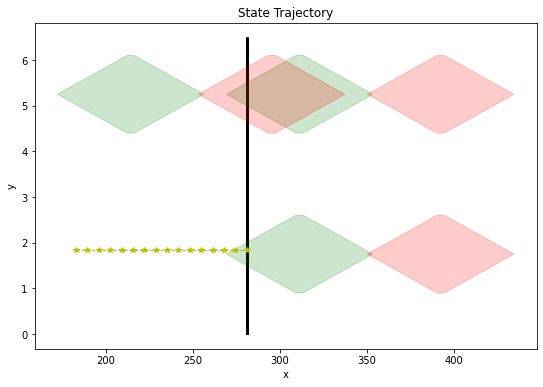

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[280.85172   1.83     -0.00002  32.66572   0.64587]
28 th step ended
[280.85172   1.83     -0.00002  32.66572   0.64587]
[280.85172   1.83     -0.00002  32.66572   0.64587]
[280.85172   1.83     -0.00002  32.66572   0.64587]
[280.85172   1.83     -0.00002  32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[287.38486   1.83      0.       32.66572   0.64587]
[287.38486   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


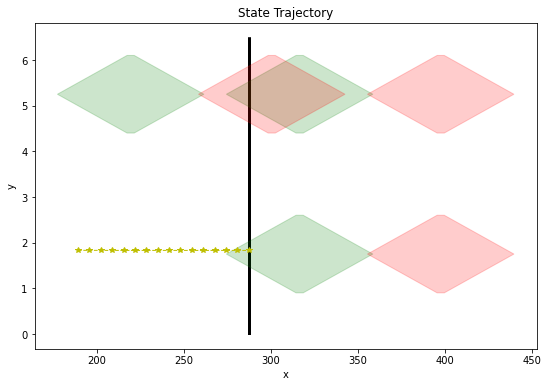

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[287.38486   1.83     -0.00002  32.66572   0.64587]
29 th step ended
[287.38486   1.83     -0.00002  32.66572   0.64587]
[287.38486   1.83     -0.00002  32.66572   0.64587]
[287.38486   1.83     -0.00002  32.66572   0.64587]
[287.38486   1.83     -0.00002  32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[293.918     1.83      0.       32.66572   0.64587]
[293.918     1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


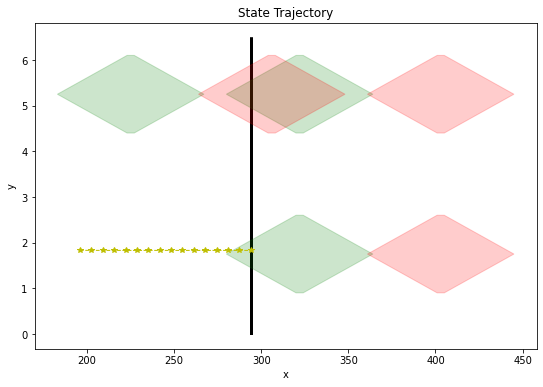

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[293.918     1.83     -0.00001  32.66572   0.64587]
30 th step ended
[293.918     1.83     -0.00001  32.66572   0.64587]
[293.918     1.83     -0.00001  32.66572   0.64587]
[293.918     1.83     -0.00001  32.66572   0.64587]
[293.918     1.83     -0.00001  32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[300.45115   1.83      0.       32.66572   0.64587]
[300.45115   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


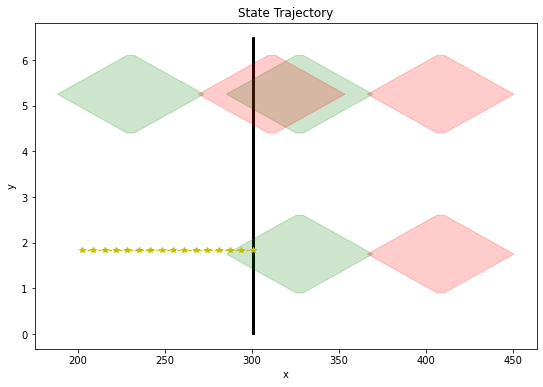

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[300.45115   1.83     -0.00001  32.66572   0.64587]
31 th step ended
[300.45115   1.83     -0.00001  32.66572   0.64587]
[300.45115   1.83     -0.00001  32.66572   0.64587]
[300.45115   1.83     -0.00001  32.66572   0.64587]
[300.45115   1.83     -0.00001  32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[306.98429   1.83      0.       32.66572   0.64587]
[306.98429   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


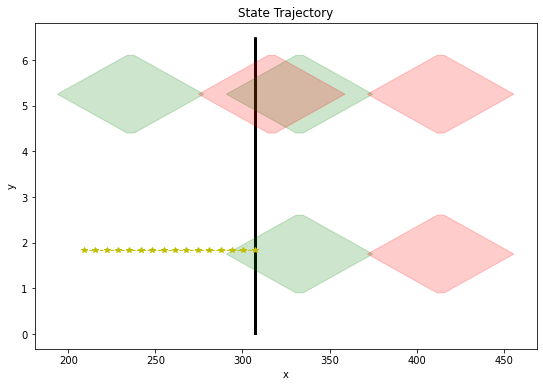

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[306.98429   1.83     -0.       32.66572   0.64587]
32 th step ended
[306.98429   1.83     -0.       32.66572   0.64587]
[306.98429   1.83     -0.       32.66572   0.64587]
[306.98429   1.83     -0.       32.66572   0.64587]
[306.98429   1.83     -0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[313.51743   1.83      0.       32.66572   0.64587]
[313.51743   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


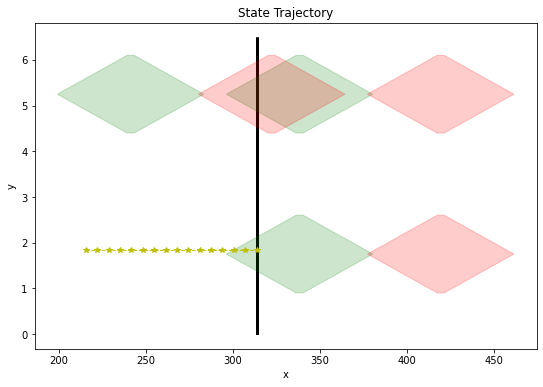

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[313.51743   1.83     -0.       32.66572   0.64587]
33 th step ended
[313.51743   1.83     -0.       32.66572   0.64587]
[313.51743   1.83     -0.       32.66572   0.64587]
[313.51743   1.83     -0.       32.66572   0.64587]
[313.51743   1.83     -0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[320.05057   1.83      0.       32.66572   0.64587]
[320.05057   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


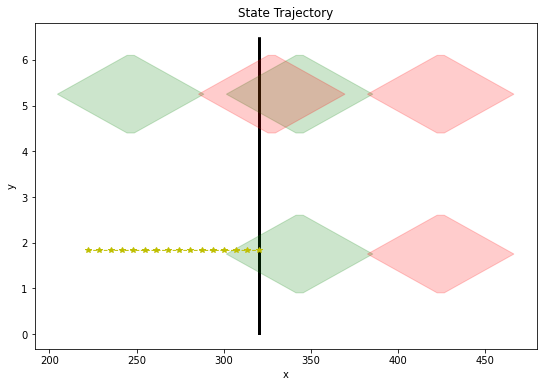

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[320.05057   1.83      0.       32.66572   0.64587]
34 th step ended
[320.05057   1.83      0.       32.66572   0.64587]
[320.05057   1.83      0.       32.66572   0.64587]
[320.05057   1.83      0.       32.66572   0.64587]
[320.05057   1.83      0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[326.58372   1.83      0.       32.66572   0.64587]
[326.58372   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


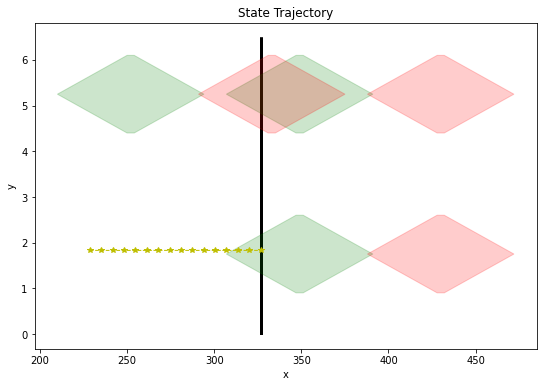

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[326.58372   1.83      0.       32.66572   0.64587]
35 th step ended
[326.58372   1.83      0.       32.66572   0.64587]
[326.58372   1.83      0.       32.66572   0.64587]
[326.58372   1.83      0.       32.66572   0.64587]
[326.58372   1.83      0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[333.11686   1.83      0.       32.66572   0.64587]
[333.11686   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


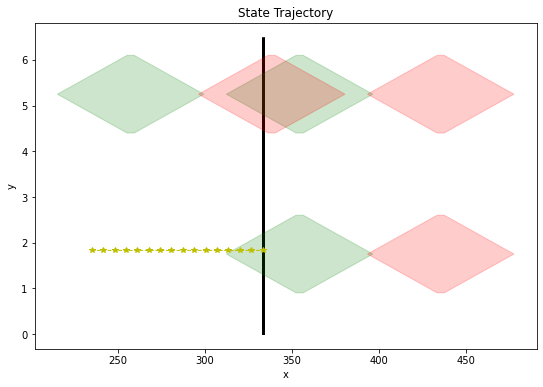

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[333.11686   1.83      0.       32.66572   0.64587]
36 th step ended
[333.11686   1.83      0.       32.66572   0.64587]
[333.11686   1.83      0.       32.66572   0.64587]
[333.11686   1.83      0.       32.66572   0.64587]
[333.11686   1.83      0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[339.65      1.83      0.       32.66572   0.64587]
[339.65      1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


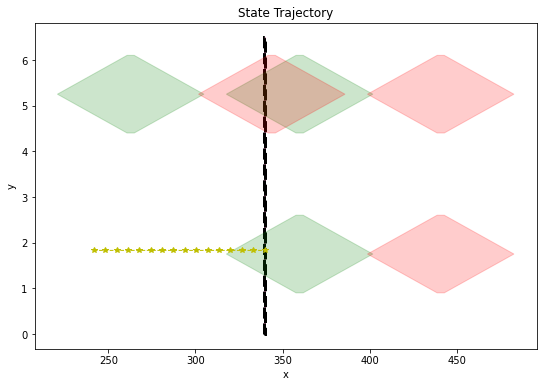

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[339.65      1.83      0.       32.66572   0.64587]
37 th step ended
[339.65      1.83      0.       32.66572   0.64587]
[339.65      1.83      0.       32.66572   0.64587]
[339.65      1.83      0.       32.66572   0.64587]
[339.65      1.83      0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[346.18314   1.83      0.       32.66572   0.64587]
[346.18314   1.83      0.       32.66572   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


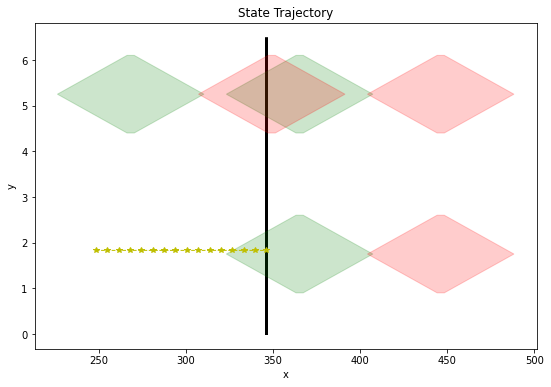

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[346.18314   1.83      0.       32.66572   0.64587]
38 th step ended
[346.18314   1.83      0.       32.66572   0.64587]
[346.18314   1.83      0.       32.66572   0.64587]
[346.18314   1.83      0.       32.66572   0.64587]
[346.18314   1.83      0.       32.66572   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[352.71629   1.83      0.       32.66571   0.64587]
[352.71629   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


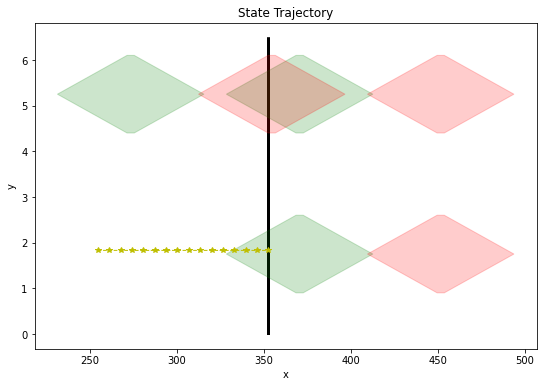

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[352.71629   1.83      0.       32.66571   0.64587]
39 th step ended
[352.71629   1.83      0.       32.66571   0.64587]
[352.71629   1.83      0.       32.66571   0.64587]
[352.71629   1.83      0.       32.66571   0.64587]
[352.71629   1.83      0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[359.24943   1.83      0.       32.66571   0.64587]
[359.24943   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


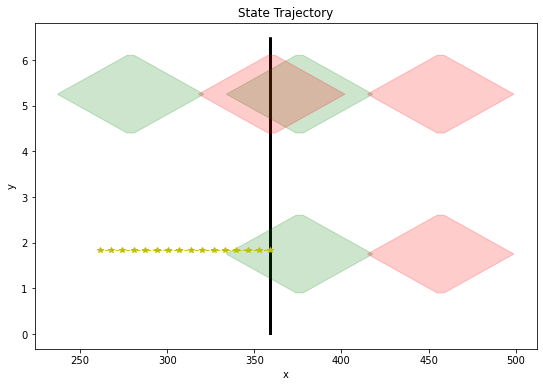

SV Lane Info :  [2, 2]
LV info :  [2, -1, 0]
[359.24943   1.83     -0.       32.66571   0.64587]
40 th step ended
[359.24943   1.83     -0.       32.66571   0.64587]
[359.24943   1.83     -0.       32.66571   0.64587]
[359.24943   1.83     -0.       32.66571   0.64587]
[359.24943   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[365.78257   1.83      0.       32.66571   0.64587]
[365.78257   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


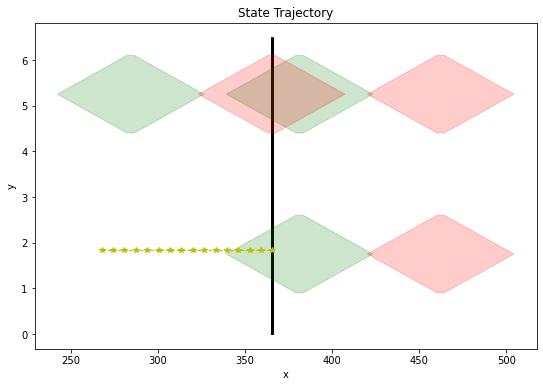

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[365.78257   1.83     -0.       32.66571   0.64587]
41 th step ended
[365.78257   1.83     -0.       32.66571   0.64587]
[365.78257   1.83     -0.       32.66571   0.64587]
[365.78257   1.83     -0.       32.66571   0.64587]
[365.78257   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[372.31572   1.83      0.       32.66571   0.64587]
[372.31572   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


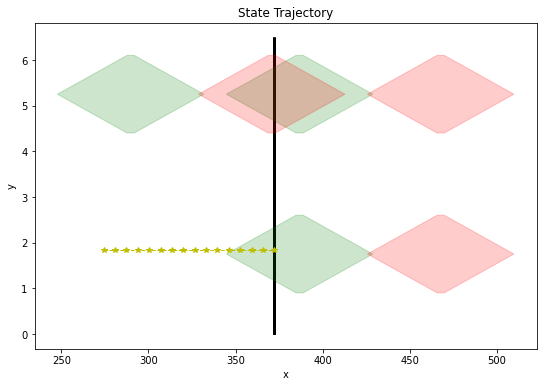

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[372.31572   1.83     -0.       32.66571   0.64587]
42 th step ended
[372.31572   1.83     -0.       32.66571   0.64587]
[372.31572   1.83     -0.       32.66571   0.64587]
[372.31572   1.83     -0.       32.66571   0.64587]
[372.31572   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[378.84886   1.83      0.       32.66571   0.64587]
[378.84886   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


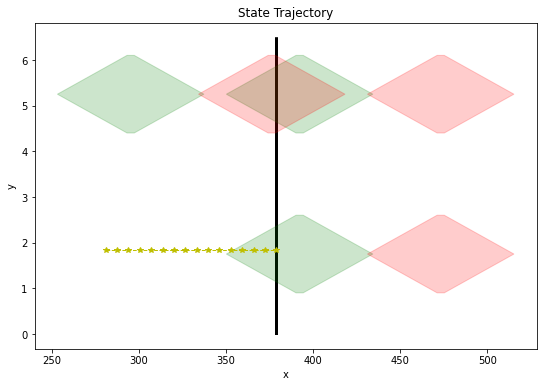

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[378.84886   1.83     -0.       32.66571   0.64587]
43 th step ended
[378.84886   1.83     -0.       32.66571   0.64587]
[378.84886   1.83     -0.       32.66571   0.64587]
[378.84886   1.83     -0.       32.66571   0.64587]
[378.84886   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[385.382     1.83      0.       32.66571   0.64587]
[385.382     1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


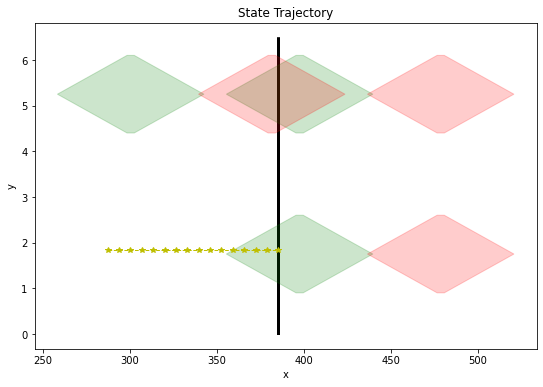

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[385.382     1.83     -0.       32.66571   0.64587]
44 th step ended
[385.382     1.83     -0.       32.66571   0.64587]
[385.382     1.83     -0.       32.66571   0.64587]
[385.382     1.83     -0.       32.66571   0.64587]
[385.382     1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[391.91514   1.83      0.       32.66571   0.64587]
[391.91514   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


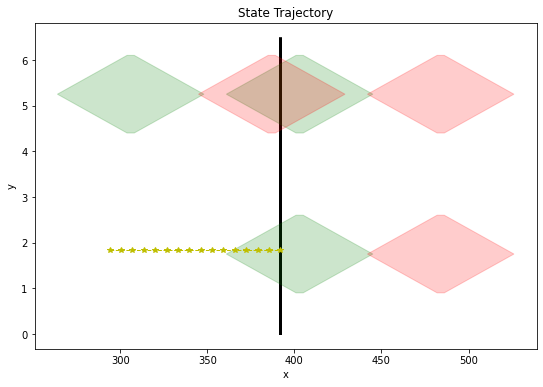

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[391.91514   1.83     -0.       32.66571   0.64587]
45 th step ended
[391.91514   1.83     -0.       32.66571   0.64587]
[391.91514   1.83     -0.       32.66571   0.64587]
[391.91514   1.83     -0.       32.66571   0.64587]
[391.91514   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[398.44829   1.83      0.       32.66571   0.64587]
[398.44829   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


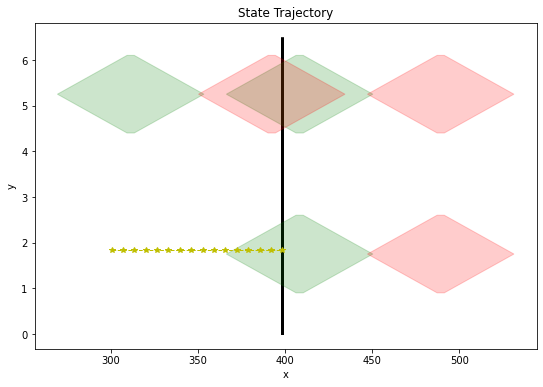

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[398.44829   1.83     -0.       32.66571   0.64587]
46 th step ended
[398.44829   1.83     -0.       32.66571   0.64587]
[398.44829   1.83     -0.       32.66571   0.64587]
[398.44829   1.83     -0.       32.66571   0.64587]
[398.44829   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[404.98143   1.83      0.       32.66571   0.64587]
[404.98143   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


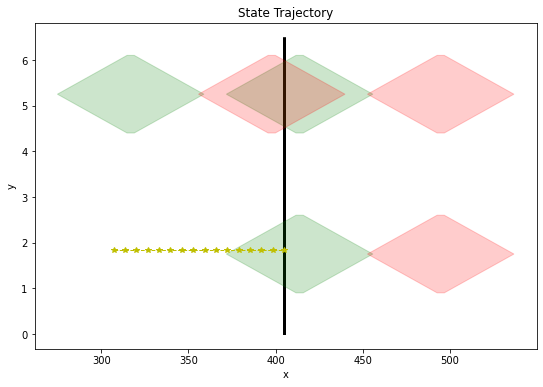

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[404.98143   1.83      0.       32.66571   0.64587]
47 th step ended
[404.98143   1.83      0.       32.66571   0.64587]
[404.98143   1.83      0.       32.66571   0.64587]
[404.98143   1.83      0.       32.66571   0.64587]
[404.98143   1.83      0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[411.51457   1.83      0.       32.66571   0.64587]
[411.51457   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


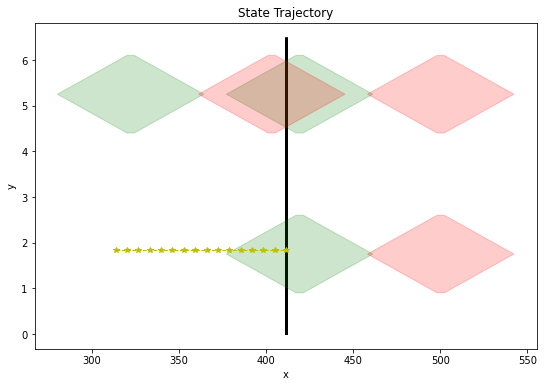

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[411.51457   1.83      0.       32.66571   0.64587]
48 th step ended
[411.51457   1.83      0.       32.66571   0.64587]
[411.51457   1.83      0.       32.66571   0.64587]
[411.51457   1.83      0.       32.66571   0.64587]
[411.51457   1.83      0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[418.04771   1.83      0.       32.66571   0.64587]
[418.04771   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


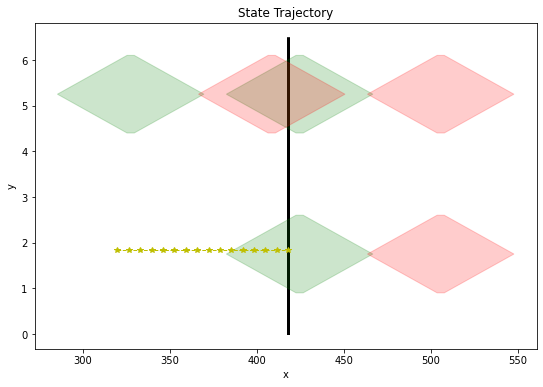

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[418.04771   1.83      0.       32.66571   0.64587]
49 th step ended
[418.04771   1.83      0.       32.66571   0.64587]
[418.04771   1.83      0.       32.66571   0.64587]
[418.04771   1.83      0.       32.66571   0.64587]
[418.04771   1.83      0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[424.58086   1.83      0.       32.66571   0.64587]
[424.58086   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


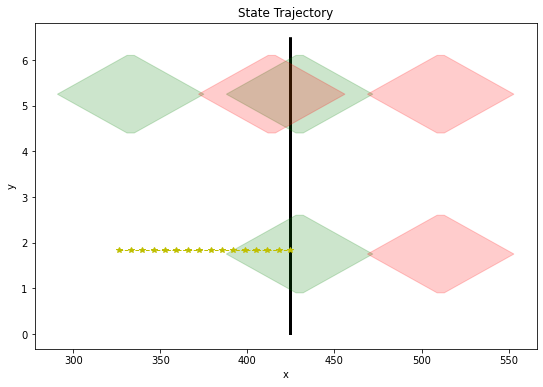

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[424.58086   1.83      0.       32.66571   0.64587]
50 th step ended
[424.58086   1.83      0.       32.66571   0.64587]
[424.58086   1.83      0.       32.66571   0.64587]
[424.58086   1.83      0.       32.66571   0.64587]
[424.58086   1.83      0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[431.114     1.83      0.       32.66571   0.64587]
[431.114     1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


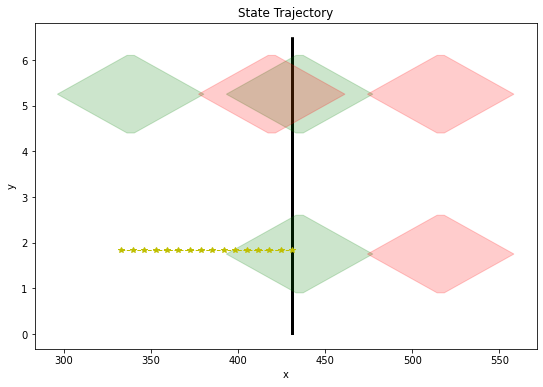

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[431.114     1.83      0.       32.66571   0.64587]
51 th step ended
[431.114     1.83      0.       32.66571   0.64587]
[431.114     1.83      0.       32.66571   0.64587]
[431.114     1.83      0.       32.66571   0.64587]
[431.114     1.83      0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[437.64714   1.83      0.       32.66571   0.64587]
[437.64714   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


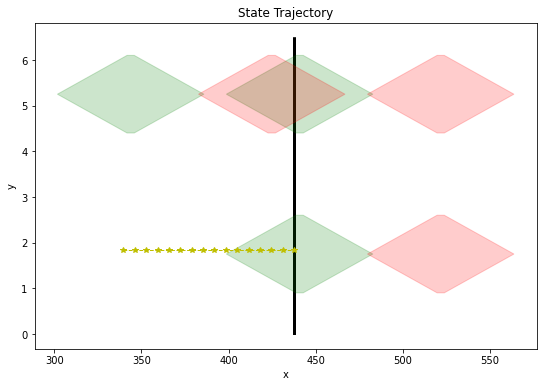

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[437.64714   1.83     -0.       32.66571   0.64587]
52 th step ended
[437.64714   1.83     -0.       32.66571   0.64587]
[437.64714   1.83     -0.       32.66571   0.64587]
[437.64714   1.83     -0.       32.66571   0.64587]
[437.64714   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[444.18029   1.83      0.       32.66571   0.64587]
[444.18029   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


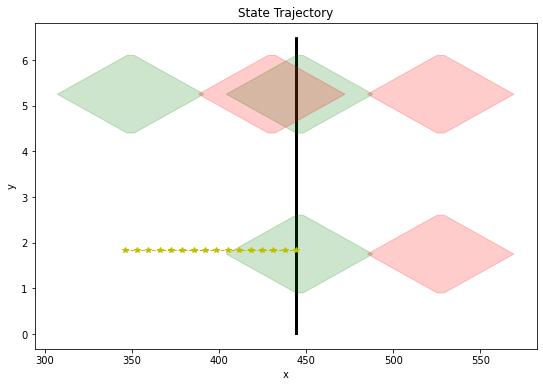

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[444.18029   1.83     -0.       32.66571   0.64587]
53 th step ended
[444.18029   1.83     -0.       32.66571   0.64587]
[444.18029   1.83     -0.       32.66571   0.64587]
[444.18029   1.83     -0.       32.66571   0.64587]
[444.18029   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[450.71343   1.83      0.       32.66571   0.64587]
[450.71343   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


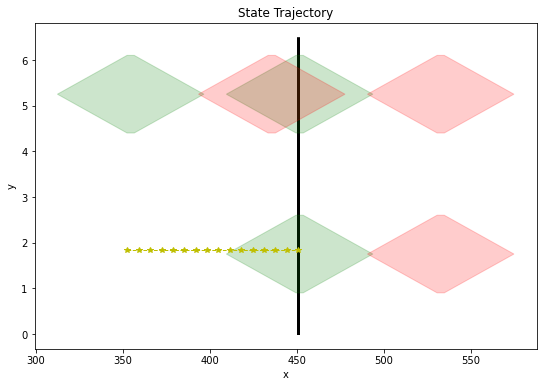

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[450.71343   1.83     -0.       32.66571   0.64587]
54 th step ended
[450.71343   1.83     -0.       32.66571   0.64587]
[450.71343   1.83     -0.       32.66571   0.64587]
[450.71343   1.83     -0.       32.66571   0.64587]
[450.71343   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[457.24657   1.83      0.       32.66571   0.64587]
[457.24657   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


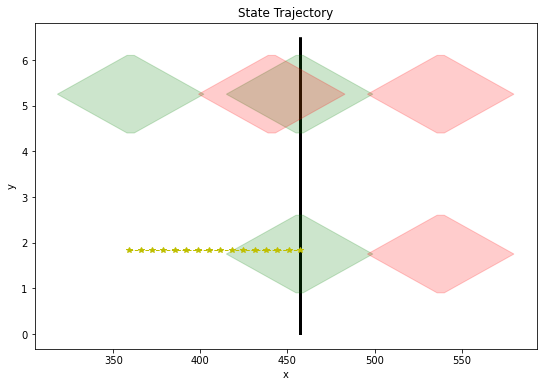

SV Lane Info :  [2, 2]
LV info :  [2, 0, 0]
[457.24657   1.83     -0.       32.66571   0.64587]
55 th step ended
[457.24657   1.83     -0.       32.66571   0.64587]
[457.24657   1.83     -0.       32.66571   0.64587]
[457.24657   1.83     -0.       32.66571   0.64587]
[457.24657   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[463.77971   1.83      0.       32.66571   0.64587]
[463.77971   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


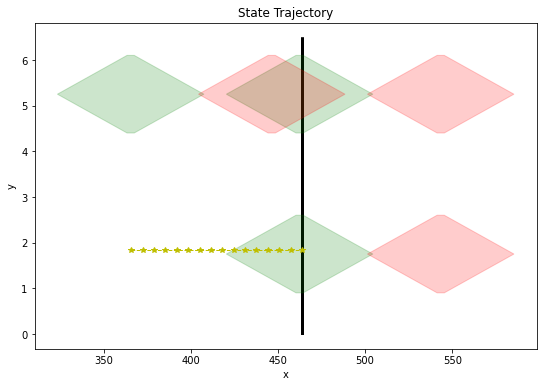

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[463.77971   1.83     -0.       32.66571   0.64587]
56 th step ended
[463.77971   1.83     -0.       32.66571   0.64587]
[463.77971   1.83     -0.       32.66571   0.64587]
[463.77971   1.83     -0.       32.66571   0.64587]
[463.77971   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[470.31286   1.83      0.       32.66571   0.64587]
[470.31286   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


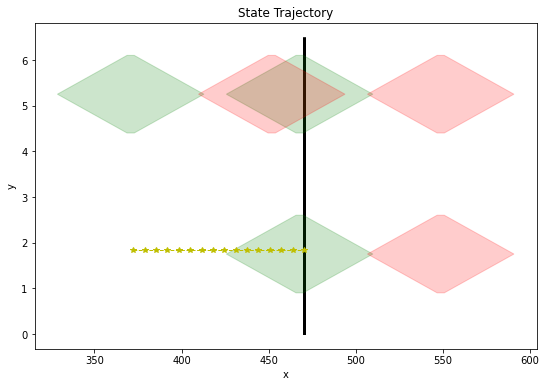

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[470.31286   1.83     -0.       32.66571   0.64587]
57 th step ended
[470.31286   1.83     -0.       32.66571   0.64587]
[470.31286   1.83     -0.       32.66571   0.64587]
[470.31286   1.83     -0.       32.66571   0.64587]
[470.31286   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[476.846     1.83      0.       32.66571   0.64587]
[476.846     1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


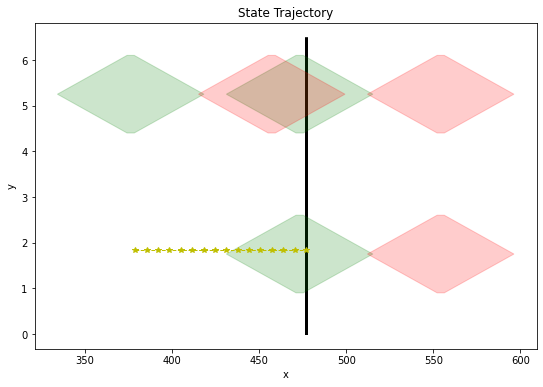

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[476.846     1.83     -0.       32.66571   0.64587]
58 th step ended
[476.846     1.83     -0.       32.66571   0.64587]
[476.846     1.83     -0.       32.66571   0.64587]
[476.846     1.83     -0.       32.66571   0.64587]
[476.846     1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[483.37914   1.83      0.       32.66571   0.64587]
[483.37914   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


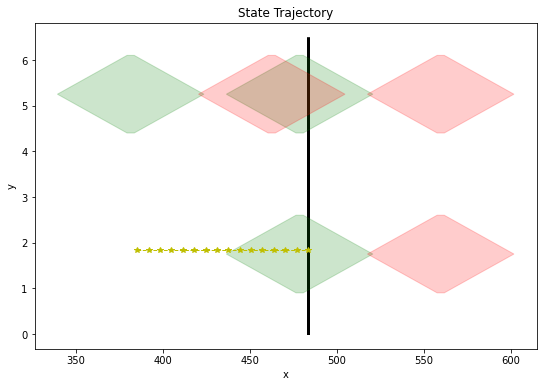

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[483.37914   1.83     -0.       32.66571   0.64587]
59 th step ended
[483.37914   1.83     -0.       32.66571   0.64587]
[483.37914   1.83     -0.       32.66571   0.64587]
[483.37914   1.83     -0.       32.66571   0.64587]
[483.37914   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[489.91229   1.83      0.       32.66571   0.64587]
[489.91229   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


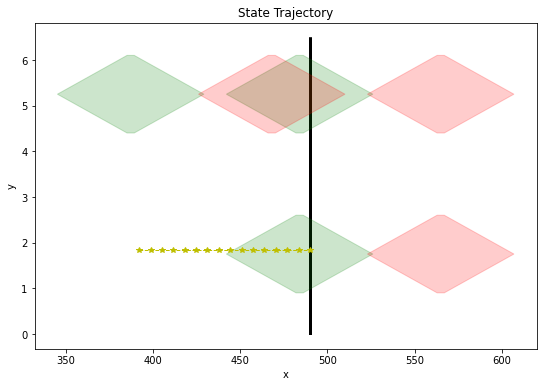

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[489.91229   1.83     -0.       32.66571   0.64587]
60 th step ended
[489.91229   1.83     -0.       32.66571   0.64587]
[489.91229   1.83     -0.       32.66571   0.64587]
[489.91229   1.83     -0.       32.66571   0.64587]
[489.91229   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[496.44543   1.83      0.       32.66571   0.64587]
[496.44543   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


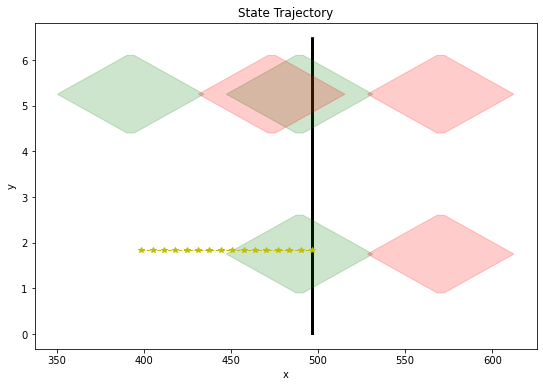

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[496.44543   1.83     -0.       32.66571   0.64587]
61 th step ended
[496.44543   1.83     -0.       32.66571   0.64587]
[496.44543   1.83     -0.       32.66571   0.64587]
[496.44543   1.83     -0.       32.66571   0.64587]
[496.44543   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[502.97857   1.83      0.       32.66571   0.64587]
[502.97857   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


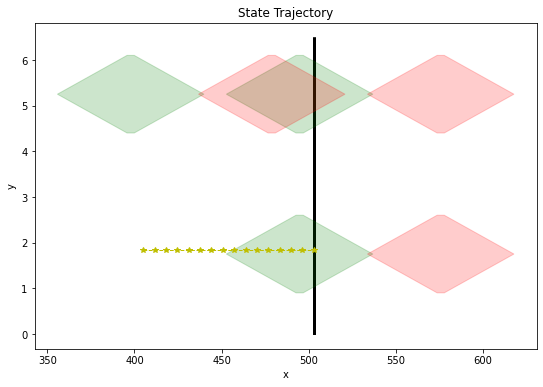

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[502.97857   1.83     -0.       32.66571   0.64587]
62 th step ended
[502.97857   1.83     -0.       32.66571   0.64587]
[502.97857   1.83     -0.       32.66571   0.64587]
[502.97857   1.83     -0.       32.66571   0.64587]
[502.97857   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[509.51171   1.83      0.       32.66571   0.64587]
[509.51171   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


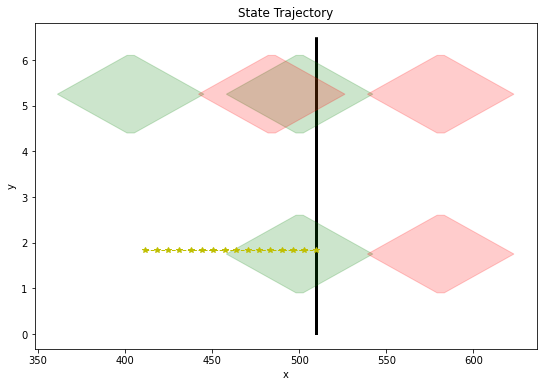

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[509.51171   1.83     -0.       32.66571   0.64587]
63 th step ended
[509.51171   1.83     -0.       32.66571   0.64587]
[509.51171   1.83     -0.       32.66571   0.64587]
[509.51171   1.83     -0.       32.66571   0.64587]
[509.51171   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[516.04486   1.83      0.       32.66571   0.64587]
[516.04486   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


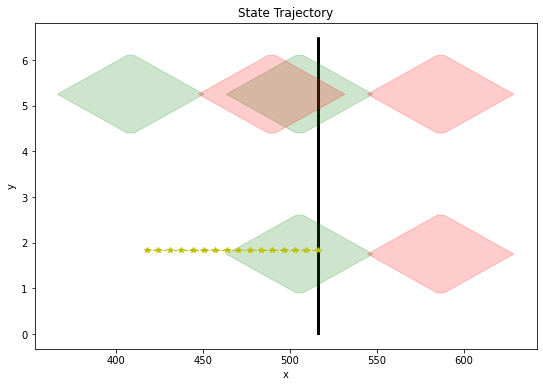

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[516.04486   1.83     -0.       32.66571   0.64587]
64 th step ended
[516.04486   1.83     -0.       32.66571   0.64587]
[516.04486   1.83     -0.       32.66571   0.64587]
[516.04486   1.83     -0.       32.66571   0.64587]
[516.04486   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[522.578     1.83      0.       32.66571   0.64587]
[522.578     1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


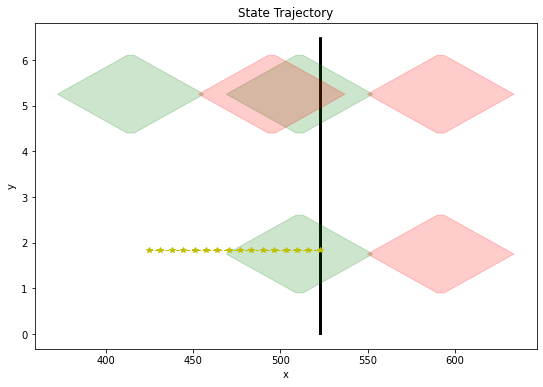

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[522.578     1.83     -0.       32.66571   0.64587]
65 th step ended
[522.578     1.83     -0.       32.66571   0.64587]
[522.578     1.83     -0.       32.66571   0.64587]
[522.578     1.83     -0.       32.66571   0.64587]
[522.578     1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[529.11114   1.83      0.       32.66571   0.64587]
[529.11114   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


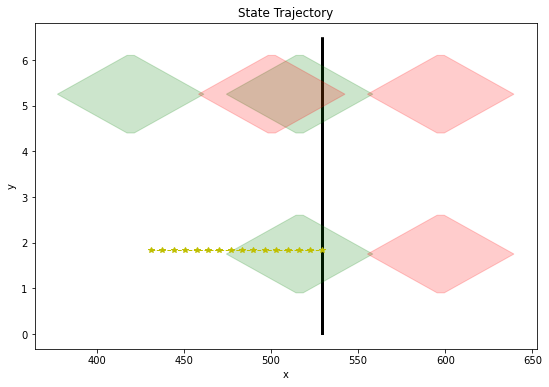

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[529.11114   1.83     -0.       32.66571   0.64587]
66 th step ended
[529.11114   1.83     -0.       32.66571   0.64587]
[529.11114   1.83     -0.       32.66571   0.64587]
[529.11114   1.83     -0.       32.66571   0.64587]
[529.11114   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[535.64429   1.83      0.       32.66571   0.64587]
[535.64429   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


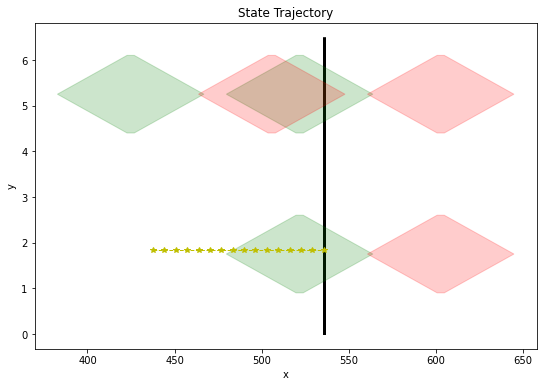

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[535.64429   1.83     -0.       32.66571   0.64587]
67 th step ended
[535.64429   1.83     -0.       32.66571   0.64587]
[535.64429   1.83     -0.       32.66571   0.64587]
[535.64429   1.83     -0.       32.66571   0.64587]
[535.64429   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[542.17743   1.83      0.       32.66571   0.64587]
[542.17743   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


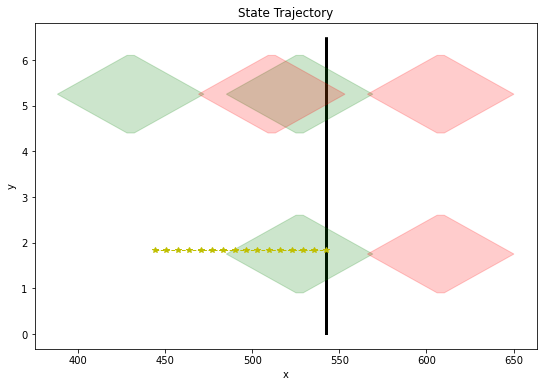

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[542.17743   1.83     -0.       32.66571   0.64587]
68 th step ended
[542.17743   1.83     -0.       32.66571   0.64587]
[542.17743   1.83     -0.       32.66571   0.64587]
[542.17743   1.83     -0.       32.66571   0.64587]
[542.17743   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[548.71057   1.83      0.       32.66571   0.64587]
[548.71057   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


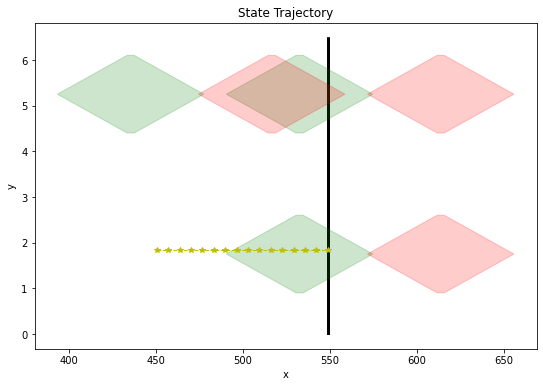

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[548.71057   1.83     -0.       32.66571   0.64587]
69 th step ended
[548.71057   1.83     -0.       32.66571   0.64587]
[548.71057   1.83     -0.       32.66571   0.64587]
[548.71057   1.83     -0.       32.66571   0.64587]
[548.71057   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[555.24371   1.83      0.       32.66571   0.64587]
[555.24371   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


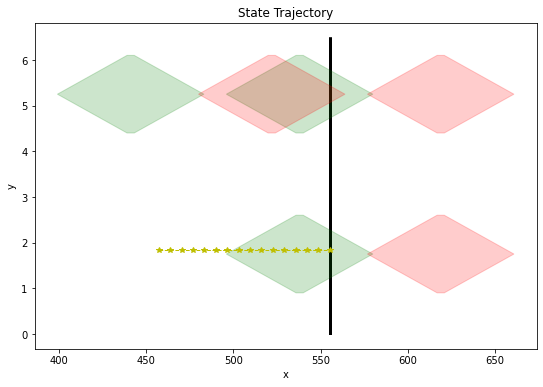

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[555.24371   1.83     -0.       32.66571   0.64587]
70 th step ended
[555.24371   1.83     -0.       32.66571   0.64587]
[555.24371   1.83     -0.       32.66571   0.64587]
[555.24371   1.83     -0.       32.66571   0.64587]
[555.24371   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[561.77686   1.83      0.       32.66571   0.64587]
[561.77686   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


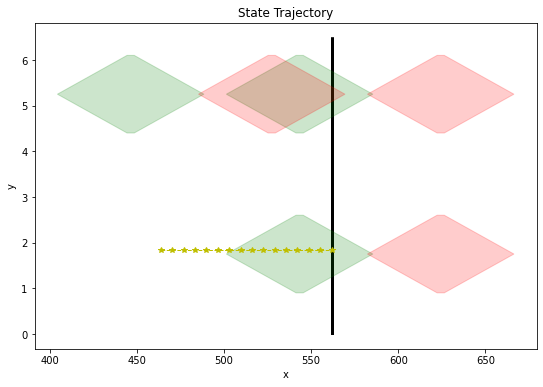

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[561.77686   1.83     -0.       32.66571   0.64587]
71 th step ended
[561.77686   1.83     -0.       32.66571   0.64587]
[561.77686   1.83     -0.       32.66571   0.64587]
[561.77686   1.83     -0.       32.66571   0.64587]
[561.77686   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[568.31      1.83      0.       32.66571   0.64587]
[568.31      1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


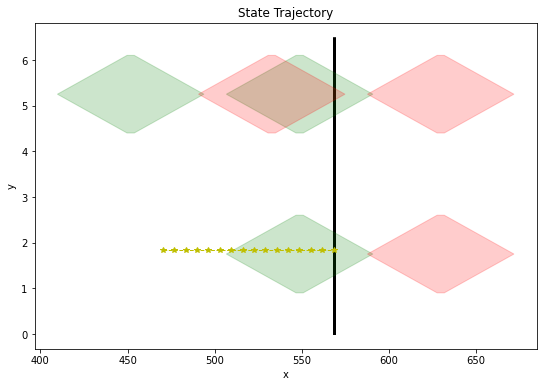

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[568.31      1.83     -0.       32.66571   0.64587]
72 th step ended
[568.31      1.83     -0.       32.66571   0.64587]
[568.31      1.83     -0.       32.66571   0.64587]
[568.31      1.83     -0.       32.66571   0.64587]
[568.31      1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[574.84314   1.83      0.       32.66571   0.64587]
[574.84314   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


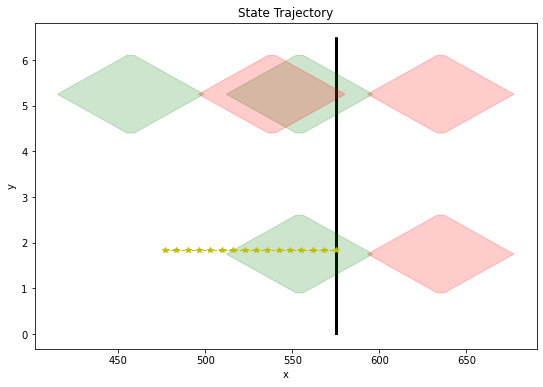

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[574.84314   1.83     -0.       32.66571   0.64587]
73 th step ended
[574.84314   1.83     -0.       32.66571   0.64587]
[574.84314   1.83     -0.       32.66571   0.64587]
[574.84314   1.83     -0.       32.66571   0.64587]
[574.84314   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[581.37629   1.83      0.       32.66571   0.64587]
[581.37629   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


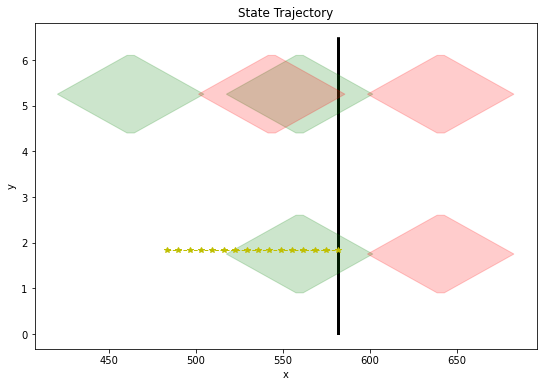

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[581.37629   1.83     -0.       32.66571   0.64587]
74 th step ended
[581.37629   1.83     -0.       32.66571   0.64587]
[581.37629   1.83     -0.       32.66571   0.64587]
[581.37629   1.83     -0.       32.66571   0.64587]
[581.37629   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[587.90943   1.83      0.       32.66571   0.64587]
[587.90943   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


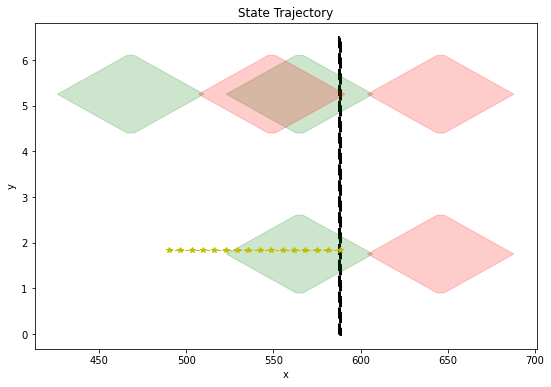

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[587.90943   1.83     -0.       32.66571   0.64587]
75 th step ended
[587.90943   1.83     -0.       32.66571   0.64587]
[587.90943   1.83     -0.       32.66571   0.64587]
[587.90943   1.83     -0.       32.66571   0.64587]
[587.90943   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[594.44257   1.83      0.       32.66571   0.64587]
[594.44257   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


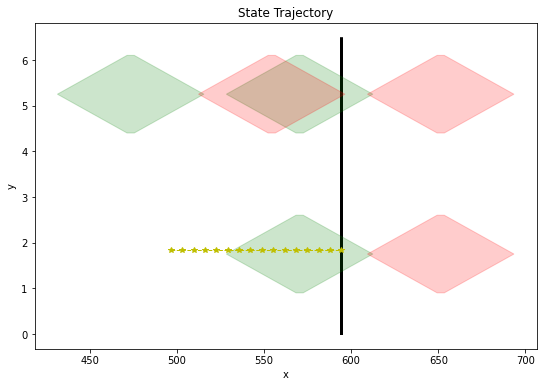

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[594.44257   1.83     -0.       32.66571   0.64587]
76 th step ended
[594.44257   1.83     -0.       32.66571   0.64587]
[594.44257   1.83     -0.       32.66571   0.64587]
[594.44257   1.83     -0.       32.66571   0.64587]
[594.44257   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[600.97571   1.83      0.       32.66571   0.64587]
[600.97571   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


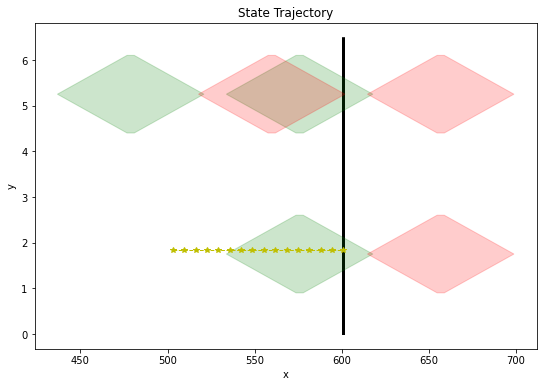

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[600.97571   1.83     -0.       32.66571   0.64587]
77 th step ended
[600.97571   1.83     -0.       32.66571   0.64587]
[600.97571   1.83     -0.       32.66571   0.64587]
[600.97571   1.83     -0.       32.66571   0.64587]
[600.97571   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[607.50886   1.83      0.       32.66571   0.64587]
[607.50886   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


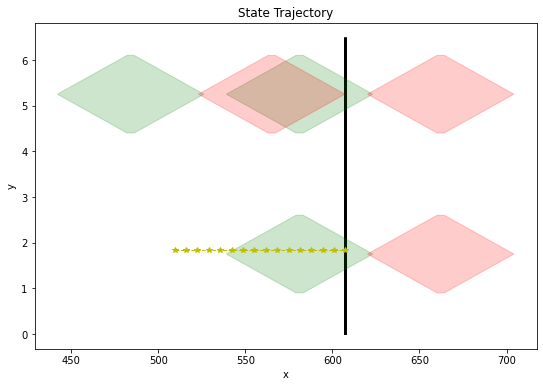

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[607.50886   1.83     -0.       32.66571   0.64587]
78 th step ended
[607.50886   1.83     -0.       32.66571   0.64587]
[607.50886   1.83     -0.       32.66571   0.64587]
[607.50886   1.83     -0.       32.66571   0.64587]
[607.50886   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[614.042     1.83      0.       32.66571   0.64587]
[614.042     1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


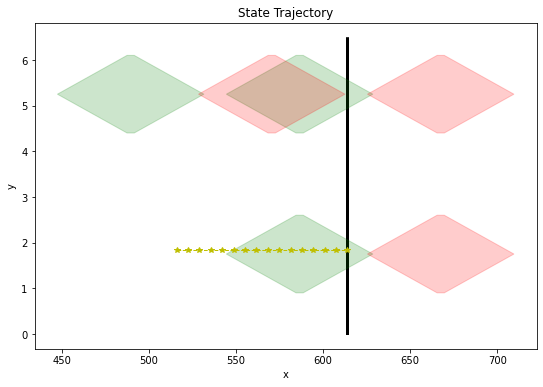

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[614.042     1.83     -0.       32.66571   0.64587]
79 th step ended
[614.042     1.83     -0.       32.66571   0.64587]
[614.042     1.83     -0.       32.66571   0.64587]
[614.042     1.83     -0.       32.66571   0.64587]
[614.042     1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[620.57514   1.83      0.       32.66571   0.64587]
[620.57514   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


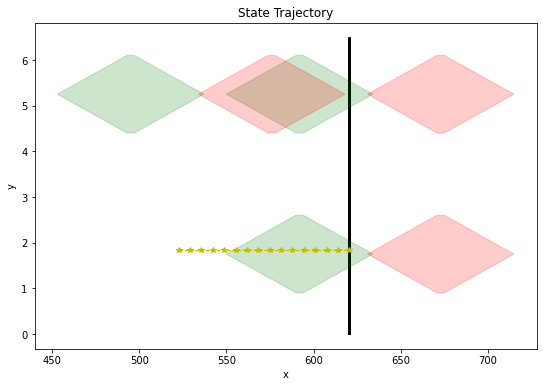

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[620.57514   1.83     -0.       32.66571   0.64587]
80 th step ended
[620.57514   1.83     -0.       32.66571   0.64587]
[620.57514   1.83     -0.       32.66571   0.64587]
[620.57514   1.83     -0.       32.66571   0.64587]
[620.57514   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[627.10829   1.83      0.       32.66571   0.64587]
[627.10829   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


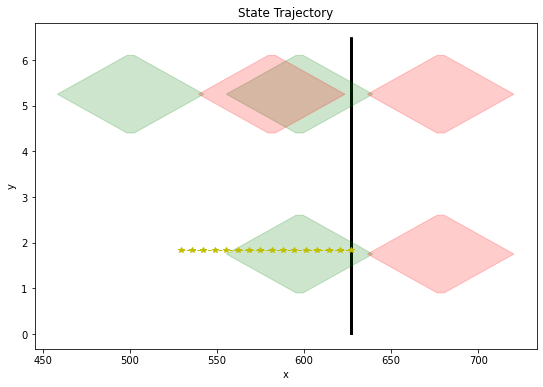

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[627.10829   1.83     -0.       32.66571   0.64587]
81 th step ended
[627.10829   1.83     -0.       32.66571   0.64587]
[627.10829   1.83     -0.       32.66571   0.64587]
[627.10829   1.83     -0.       32.66571   0.64587]
[627.10829   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[633.64143   1.83      0.       32.66571   0.64587]
[633.64143   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


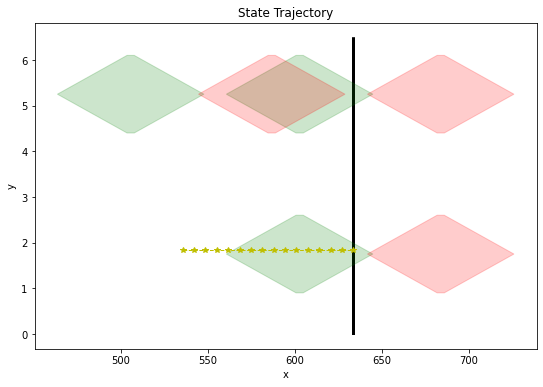

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[633.64143   1.83     -0.       32.66571   0.64587]
82 th step ended
[633.64143   1.83     -0.       32.66571   0.64587]
[633.64143   1.83     -0.       32.66571   0.64587]
[633.64143   1.83     -0.       32.66571   0.64587]
[633.64143   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[640.17457   1.83      0.       32.66571   0.64587]
[640.17457   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


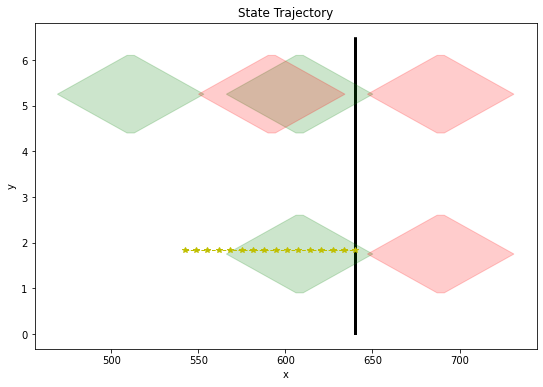

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[640.17457   1.83     -0.       32.66571   0.64587]
83 th step ended
[640.17457   1.83     -0.       32.66571   0.64587]
[640.17457   1.83     -0.       32.66571   0.64587]
[640.17457   1.83     -0.       32.66571   0.64587]
[640.17457   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[646.70771   1.83      0.       32.66571   0.64587]
[646.70771   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


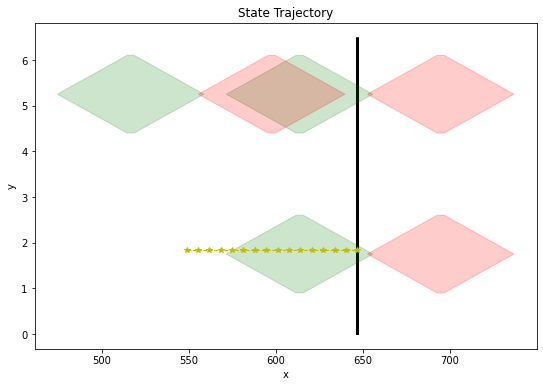

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[646.70771   1.83     -0.       32.66571   0.64587]
84 th step ended
[646.70771   1.83     -0.       32.66571   0.64587]
[646.70771   1.83     -0.       32.66571   0.64587]
[646.70771   1.83     -0.       32.66571   0.64587]
[646.70771   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[653.24086   1.83      0.       32.66571   0.64587]
[653.24086   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


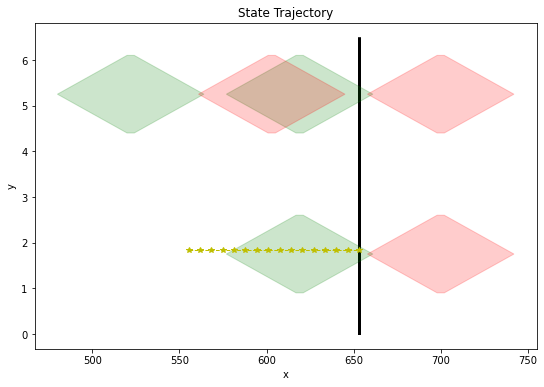

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[653.24086   1.83     -0.       32.66571   0.64587]
85 th step ended
[653.24086   1.83     -0.       32.66571   0.64587]
[653.24086   1.83     -0.       32.66571   0.64587]
[653.24086   1.83     -0.       32.66571   0.64587]
[653.24086   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[659.774     1.83      0.       32.66571   0.64587]
[659.774     1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


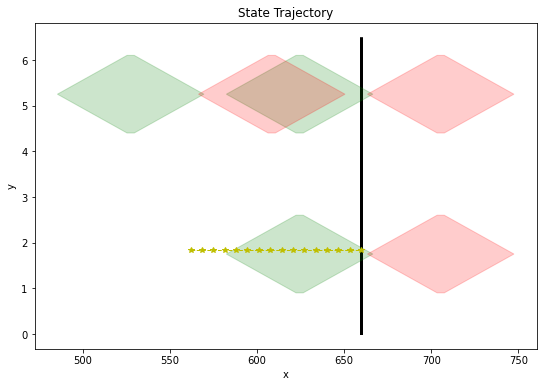

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[659.774     1.83     -0.       32.66571   0.64587]
86 th step ended
[659.774     1.83     -0.       32.66571   0.64587]
[659.774     1.83     -0.       32.66571   0.64587]
[659.774     1.83     -0.       32.66571   0.64587]
[659.774     1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[666.30714   1.83      0.       32.66571   0.64587]
[666.30714   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


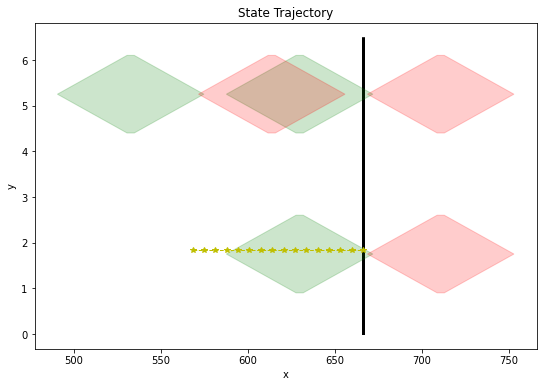

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[666.30714   1.83     -0.       32.66571   0.64587]
87 th step ended
[666.30714   1.83     -0.       32.66571   0.64587]
[666.30714   1.83     -0.       32.66571   0.64587]
[666.30714   1.83     -0.       32.66571   0.64587]
[666.30714   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[672.84029   1.83      0.       32.66571   0.64587]
[672.84029   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


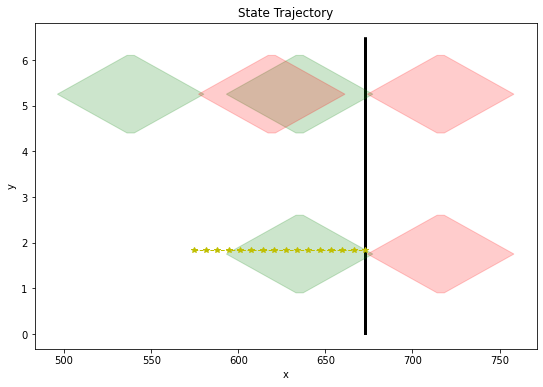

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[672.84029   1.83     -0.       32.66571   0.64587]
88 th step ended
[672.84029   1.83     -0.       32.66571   0.64587]
[672.84029   1.83     -0.       32.66571   0.64587]
[672.84029   1.83     -0.       32.66571   0.64587]
[672.84029   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[679.37343   1.83      0.       32.66571   0.64587]
[679.37343   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


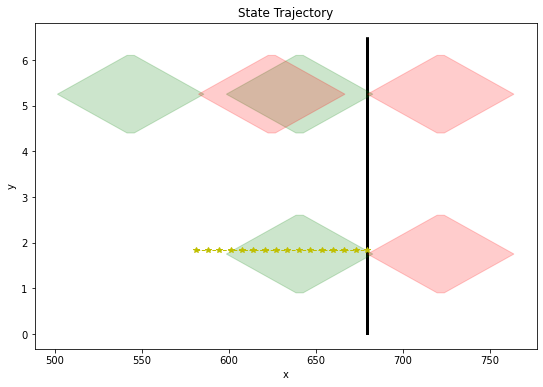

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[679.37343   1.83     -0.       32.66571   0.64587]
89 th step ended
[679.37343   1.83     -0.       32.66571   0.64587]
[679.37343   1.83     -0.       32.66571   0.64587]
[679.37343   1.83     -0.       32.66571   0.64587]
[679.37343   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[685.90657   1.83      0.       32.66571   0.64587]
[685.90657   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


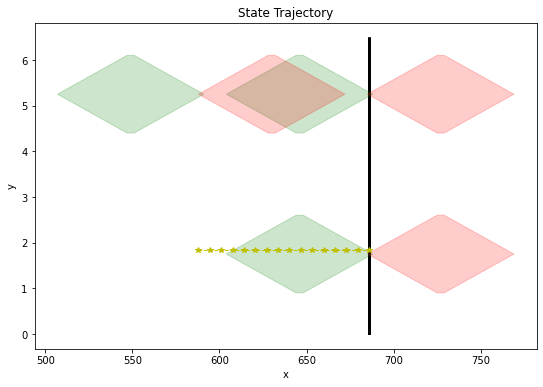

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[685.90657   1.83     -0.       32.66571   0.64587]
90 th step ended
[685.90657   1.83     -0.       32.66571   0.64587]
[685.90657   1.83     -0.       32.66571   0.64587]
[685.90657   1.83     -0.       32.66571   0.64587]
[685.90657   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[692.43971   1.83      0.       32.66571   0.64587]
[692.43971   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


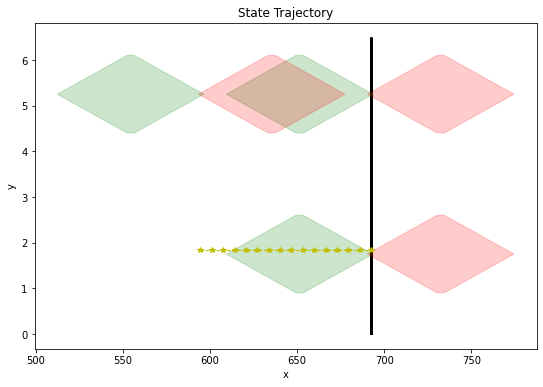

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[692.43971   1.83     -0.       32.66571   0.64587]
91 th step ended
[692.43971   1.83     -0.       32.66571   0.64587]
[692.43971   1.83     -0.       32.66571   0.64587]
[692.43971   1.83     -0.       32.66571   0.64587]
[692.43971   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[698.97286   1.83      0.       32.66571   0.64587]
[698.97286   1.83      0.       32.66571   0.64587]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


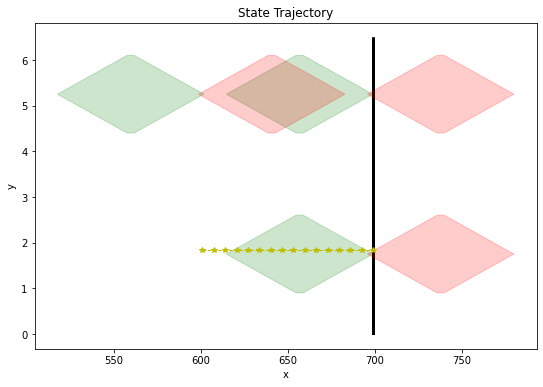

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[698.97286   1.83     -0.       32.66571   0.64587]
92 th step ended
[698.97286   1.83     -0.       32.66571   0.64587]
[698.97286   1.83     -0.       32.66571   0.64587]
[698.97286   1.83     -0.       32.66571   0.64587]
[698.97286   1.83     -0.       32.66571   0.64587]
---------------------------------------------------------------------
risk value :  0.0
[698.15   1.75   0.    27.     0.  ]
[698.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


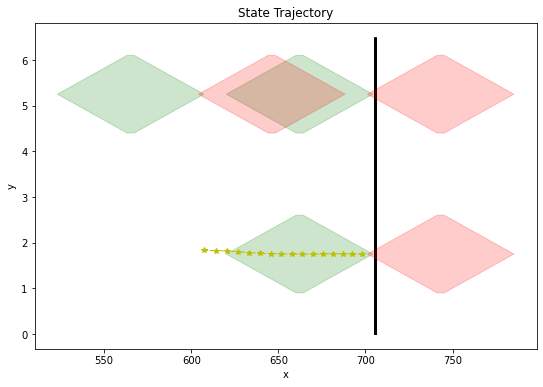

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[698.15      1.75     -0.00088  27.        0.     ]
93 th step ended
[698.15      1.75     -0.00088  27.        0.     ]
[698.15      1.75     -0.00088  27.        0.     ]
[698.15      1.75     -0.00088  27.        0.     ]
[698.15      1.75     -0.00088  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[703.55   1.75   0.    27.     0.  ]
[703.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


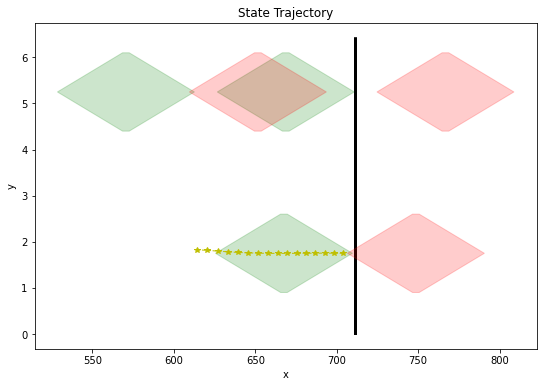

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[703.55      1.75     -0.00086  27.        0.     ]
94 th step ended
[703.55      1.75     -0.00086  27.        0.     ]
[703.55      1.75     -0.00086  27.        0.     ]
[703.55      1.75     -0.00086  27.        0.     ]
[703.55      1.75     -0.00086  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[708.95   1.75   0.    27.     0.  ]
[708.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


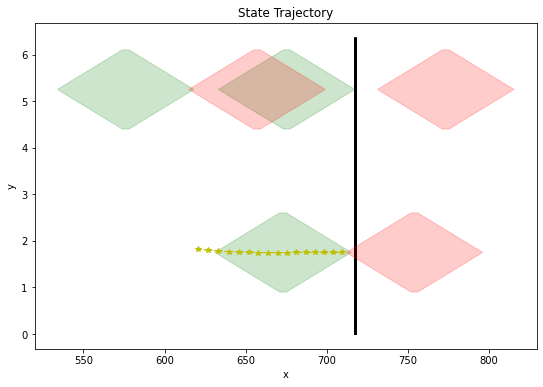

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[708.95      1.75     -0.00073  27.        0.     ]
95 th step ended
[708.95      1.75     -0.00073  27.        0.     ]
[708.95      1.75     -0.00073  27.        0.     ]
[708.95      1.75     -0.00073  27.        0.     ]
[708.95      1.75     -0.00073  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[714.35   1.75   0.    27.     0.  ]
[714.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


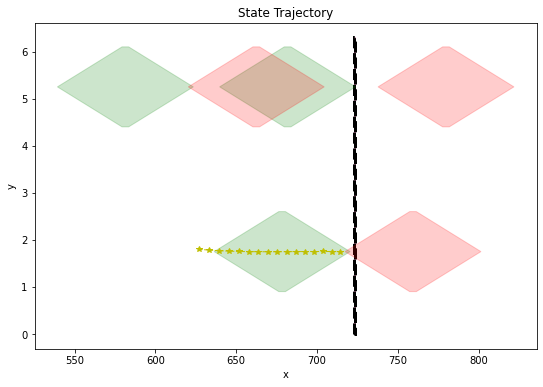

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[714.35      1.75     -0.00055  27.        0.     ]
96 th step ended
[714.35      1.75     -0.00055  27.        0.     ]
[714.35      1.75     -0.00055  27.        0.     ]
[714.35      1.75     -0.00055  27.        0.     ]
[714.35      1.75     -0.00055  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[719.75   1.75   0.    27.     0.  ]
[719.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


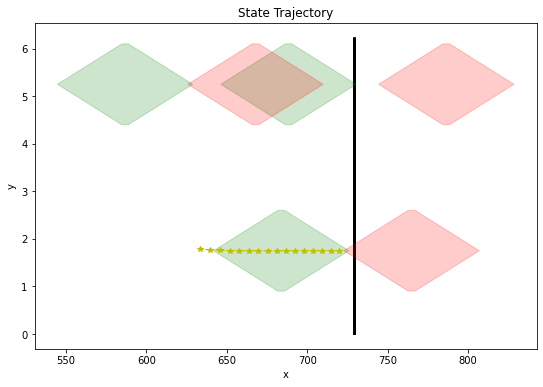

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[719.75      1.75     -0.00038  27.        0.     ]
97 th step ended
[719.75      1.75     -0.00038  27.        0.     ]
[719.75      1.75     -0.00038  27.        0.     ]
[719.75      1.75     -0.00038  27.        0.     ]
[719.75      1.75     -0.00038  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[725.15   1.75   0.    27.     0.  ]
[725.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


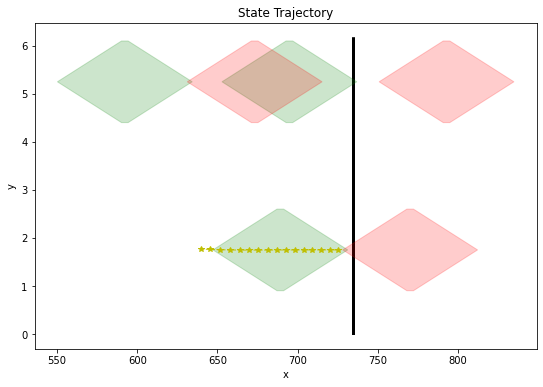

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[725.15      1.75     -0.00024  27.        0.     ]
98 th step ended
[725.15      1.75     -0.00024  27.        0.     ]
[725.15      1.75     -0.00024  27.        0.     ]
[725.15      1.75     -0.00024  27.        0.     ]
[725.15      1.75     -0.00024  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[730.55   1.75   0.    27.     0.  ]
[730.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


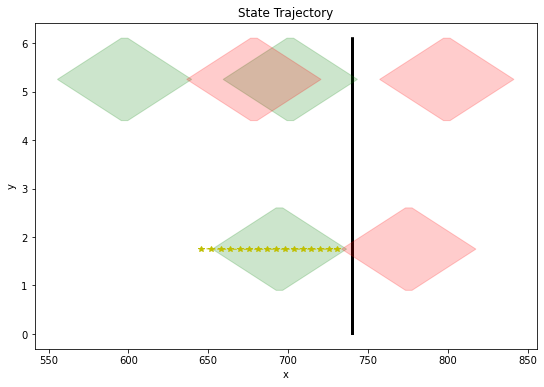

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[730.55      1.75     -0.00013  27.        0.     ]
99 th step ended
[730.55      1.75     -0.00013  27.        0.     ]
[730.55      1.75     -0.00013  27.        0.     ]
[730.55      1.75     -0.00013  27.        0.     ]
[730.55      1.75     -0.00013  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[735.95   1.75   0.    27.     0.  ]
[735.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


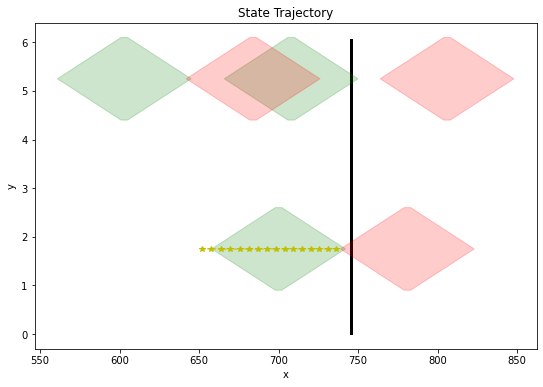

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[735.95      1.75     -0.00005  27.        0.     ]
100 th step ended
[735.95      1.75     -0.00005  27.        0.     ]
[735.95      1.75     -0.00005  27.        0.     ]
[735.95      1.75     -0.00005  27.        0.     ]
[735.95      1.75     -0.00005  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[741.35   1.75   0.    27.     0.  ]
[741.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


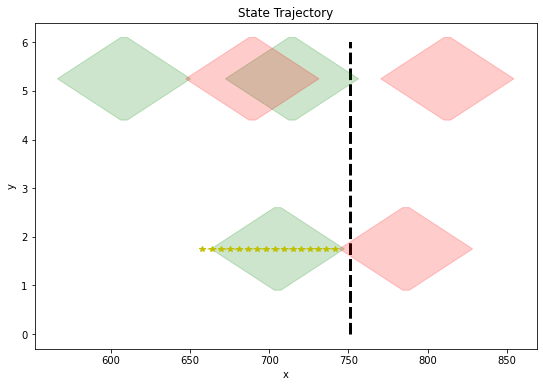

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[741.35   1.75  -0.    27.     0.  ]
101 th step ended
[741.35   1.75  -0.    27.     0.  ]
[741.35   1.75  -0.    27.     0.  ]
[741.35   1.75  -0.    27.     0.  ]
[741.35   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[746.75   1.75   0.    27.     0.  ]
[746.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


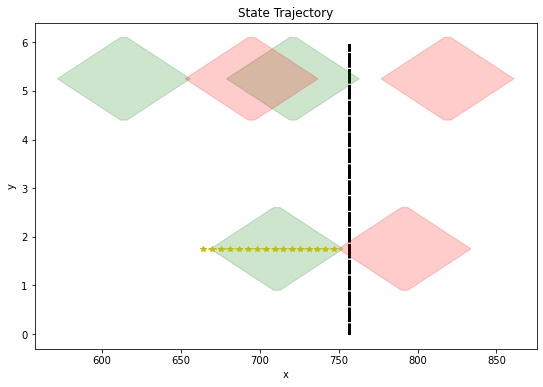

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[746.75      1.75      0.00003  27.        0.     ]
102 th step ended
[746.75      1.75      0.00003  27.        0.     ]
[746.75      1.75      0.00003  27.        0.     ]
[746.75      1.75      0.00003  27.        0.     ]
[746.75      1.75      0.00003  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[752.15   1.75   0.    27.     0.  ]
[752.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


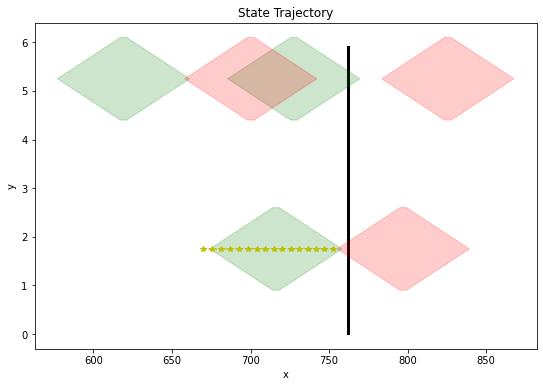

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[752.15      1.75      0.00004  27.        0.     ]
103 th step ended
[752.15      1.75      0.00004  27.        0.     ]
[752.15      1.75      0.00004  27.        0.     ]
[752.15      1.75      0.00004  27.        0.     ]
[752.15      1.75      0.00004  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[757.55   1.75   0.    27.     0.  ]
[757.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


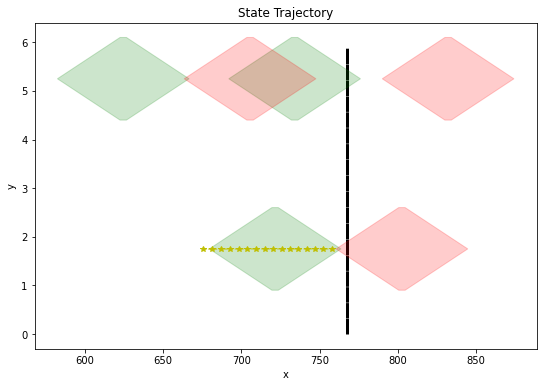

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[757.55      1.75      0.00004  27.        0.     ]
104 th step ended
[757.55      1.75      0.00004  27.        0.     ]
[757.55      1.75      0.00004  27.        0.     ]
[757.55      1.75      0.00004  27.        0.     ]
[757.55      1.75      0.00004  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[762.95   1.75   0.    27.     0.  ]
[762.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


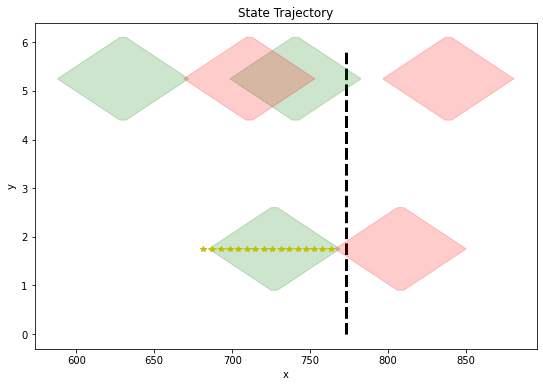

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[762.95      1.75      0.00004  27.        0.     ]
105 th step ended
[762.95      1.75      0.00004  27.        0.     ]
[762.95      1.75      0.00004  27.        0.     ]
[762.95      1.75      0.00004  27.        0.     ]
[762.95      1.75      0.00004  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[768.35   1.75   0.    27.     0.  ]
[768.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


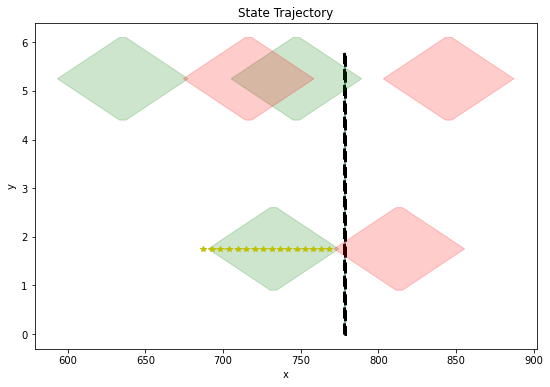

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[768.35      1.75      0.00003  27.        0.     ]
106 th step ended
[768.35      1.75      0.00003  27.        0.     ]
[768.35      1.75      0.00003  27.        0.     ]
[768.35      1.75      0.00003  27.        0.     ]
[768.35      1.75      0.00003  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[773.75   1.75   0.    27.     0.  ]
[773.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


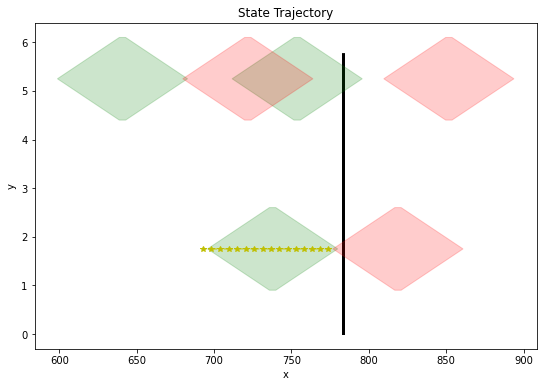

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[773.75      1.75      0.00002  27.        0.     ]
107 th step ended
[773.75      1.75      0.00002  27.        0.     ]
[773.75      1.75      0.00002  27.        0.     ]
[773.75      1.75      0.00002  27.        0.     ]
[773.75      1.75      0.00002  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[779.15   1.75   0.    27.     0.  ]
[779.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


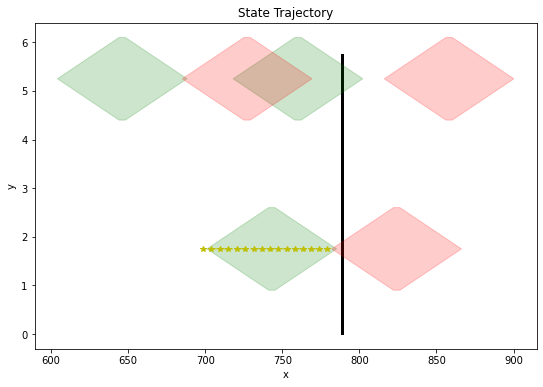

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[779.15      1.75      0.00002  27.        0.     ]
108 th step ended
[779.15      1.75      0.00002  27.        0.     ]
[779.15      1.75      0.00002  27.        0.     ]
[779.15      1.75      0.00002  27.        0.     ]
[779.15      1.75      0.00002  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[784.55   1.75   0.    27.     0.  ]
[784.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


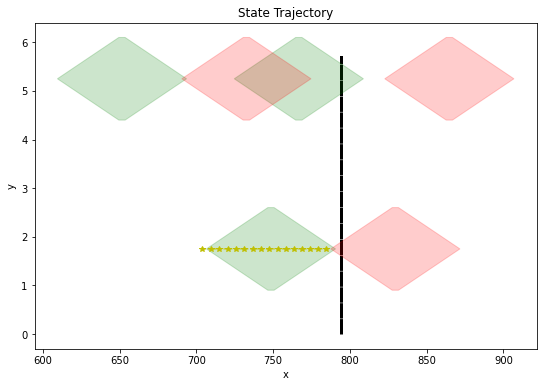

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[784.55      1.75      0.00001  27.        0.     ]
109 th step ended
[784.55      1.75      0.00001  27.        0.     ]
[784.55      1.75      0.00001  27.        0.     ]
[784.55      1.75      0.00001  27.        0.     ]
[784.55      1.75      0.00001  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[789.95   1.75   0.    27.     0.  ]
[789.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


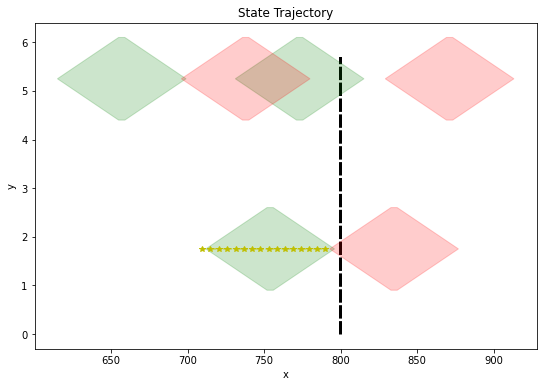

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[789.95      1.75      0.00001  27.        0.     ]
110 th step ended
[789.95      1.75      0.00001  27.        0.     ]
[789.95      1.75      0.00001  27.        0.     ]
[789.95      1.75      0.00001  27.        0.     ]
[789.95      1.75      0.00001  27.        0.     ]
---------------------------------------------------------------------
risk value :  0.0
[795.35   1.75   0.    27.     0.  ]
[795.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


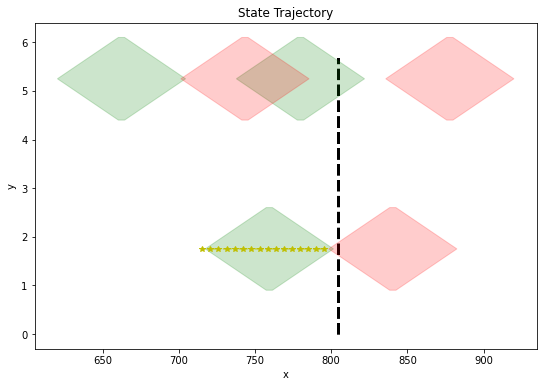

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[795.35   1.75   0.    27.     0.  ]
111 th step ended
[795.35   1.75   0.    27.     0.  ]
[795.35   1.75   0.    27.     0.  ]
[795.35   1.75   0.    27.     0.  ]
[795.35   1.75   0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[800.75   1.75   0.    27.     0.  ]
[800.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


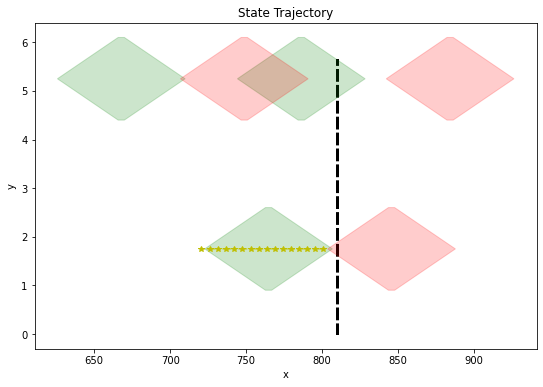

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[800.75   1.75   0.    27.     0.  ]
112 th step ended
[800.75   1.75   0.    27.     0.  ]
[800.75   1.75   0.    27.     0.  ]
[800.75   1.75   0.    27.     0.  ]
[800.75   1.75   0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[806.15   1.75   0.    27.     0.  ]
[806.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


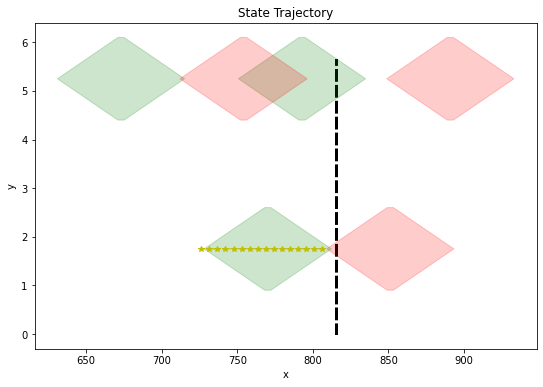

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[806.15   1.75  -0.    27.     0.  ]
113 th step ended
[806.15   1.75  -0.    27.     0.  ]
[806.15   1.75  -0.    27.     0.  ]
[806.15   1.75  -0.    27.     0.  ]
[806.15   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[811.55   1.75   0.    27.     0.  ]
[811.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


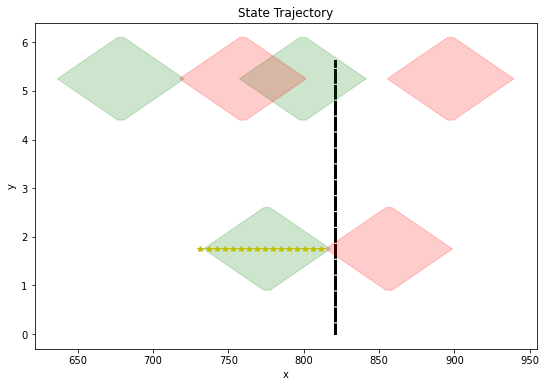

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[811.55   1.75  -0.    27.     0.  ]
114 th step ended
[811.55   1.75  -0.    27.     0.  ]
[811.55   1.75  -0.    27.     0.  ]
[811.55   1.75  -0.    27.     0.  ]
[811.55   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[816.95   1.75   0.    27.     0.  ]
[816.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


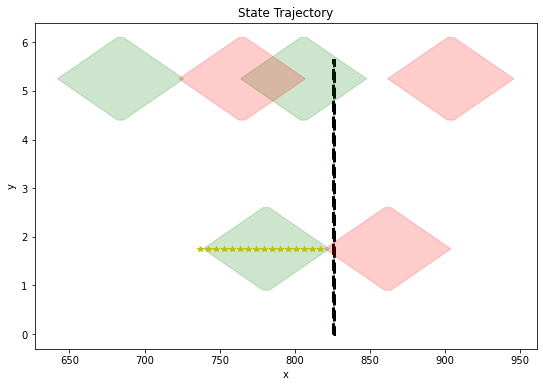

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[816.95   1.75  -0.    27.     0.  ]
115 th step ended
[816.95   1.75  -0.    27.     0.  ]
[816.95   1.75  -0.    27.     0.  ]
[816.95   1.75  -0.    27.     0.  ]
[816.95   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[822.35   1.75   0.    27.     0.  ]
[822.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


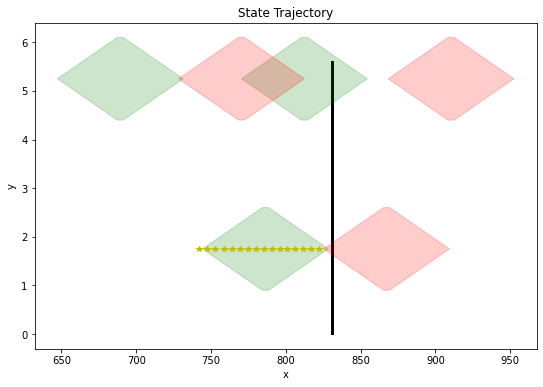

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[822.35   1.75  -0.    27.     0.  ]
116 th step ended
[822.35   1.75  -0.    27.     0.  ]
[822.35   1.75  -0.    27.     0.  ]
[822.35   1.75  -0.    27.     0.  ]
[822.35   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[827.75   1.75   0.    27.     0.  ]
[827.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


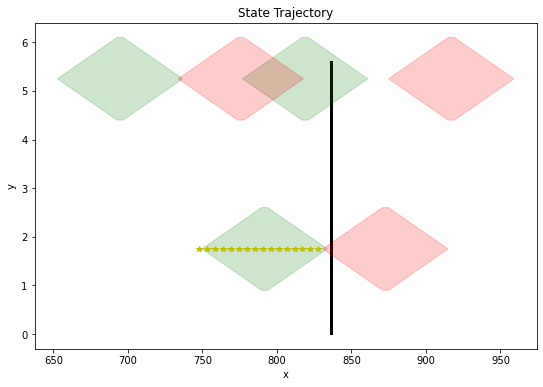

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[827.75   1.75  -0.    27.     0.  ]
117 th step ended
[827.75   1.75  -0.    27.     0.  ]
[827.75   1.75  -0.    27.     0.  ]
[827.75   1.75  -0.    27.     0.  ]
[827.75   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[833.15   1.75   0.    27.     0.  ]
[833.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


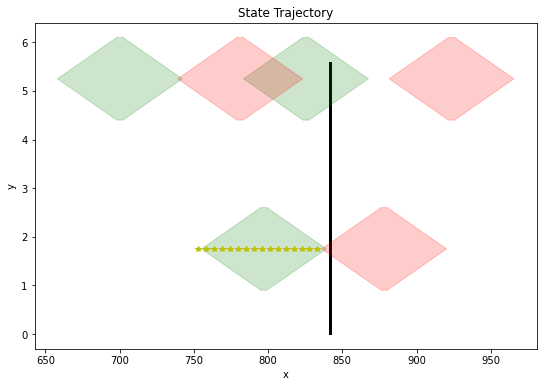

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[833.15   1.75  -0.    27.     0.  ]
118 th step ended
[833.15   1.75  -0.    27.     0.  ]
[833.15   1.75  -0.    27.     0.  ]
[833.15   1.75  -0.    27.     0.  ]
[833.15   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[838.55   1.75   0.    27.     0.  ]
[838.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


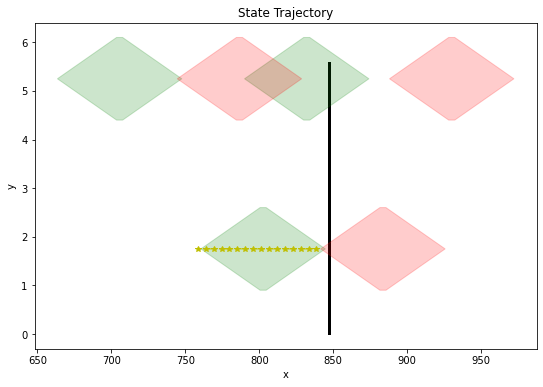

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[838.55   1.75  -0.    27.     0.  ]
119 th step ended
[838.55   1.75  -0.    27.     0.  ]
[838.55   1.75  -0.    27.     0.  ]
[838.55   1.75  -0.    27.     0.  ]
[838.55   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[843.95   1.75   0.    27.     0.  ]
[843.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


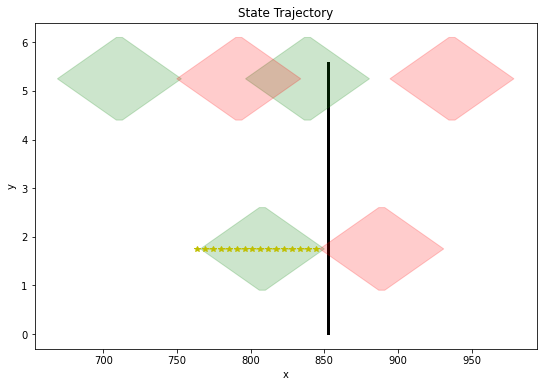

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[843.95   1.75  -0.    27.     0.  ]
120 th step ended
[843.95   1.75  -0.    27.     0.  ]
[843.95   1.75  -0.    27.     0.  ]
[843.95   1.75  -0.    27.     0.  ]
[843.95   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[849.35   1.75   0.    27.     0.  ]
[849.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


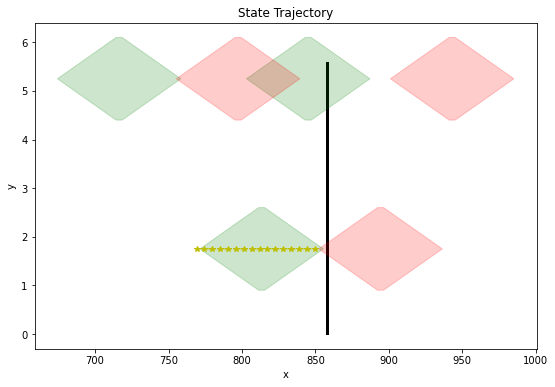

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[849.35   1.75  -0.    27.     0.  ]
121 th step ended
[849.35   1.75  -0.    27.     0.  ]
[849.35   1.75  -0.    27.     0.  ]
[849.35   1.75  -0.    27.     0.  ]
[849.35   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[854.75   1.75   0.    27.     0.  ]
[854.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


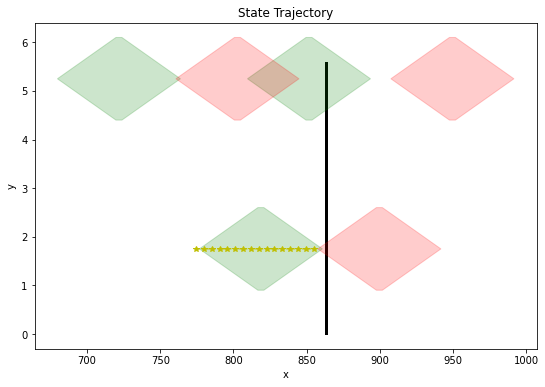

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[854.75   1.75  -0.    27.     0.  ]
122 th step ended
[854.75   1.75  -0.    27.     0.  ]
[854.75   1.75  -0.    27.     0.  ]
[854.75   1.75  -0.    27.     0.  ]
[854.75   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[860.15   1.75   0.    27.     0.  ]
[860.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


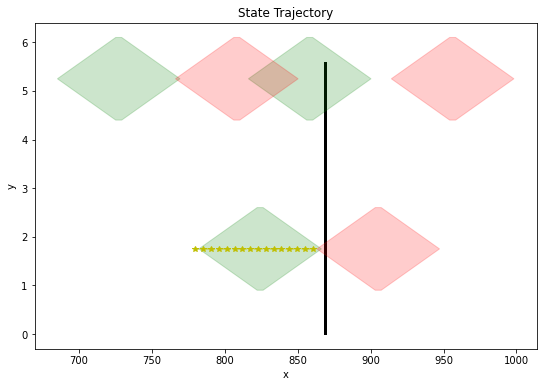

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[860.15   1.75  -0.    27.     0.  ]
123 th step ended
[860.15   1.75  -0.    27.     0.  ]
[860.15   1.75  -0.    27.     0.  ]
[860.15   1.75  -0.    27.     0.  ]
[860.15   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[865.55   1.75   0.    27.     0.  ]
[865.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


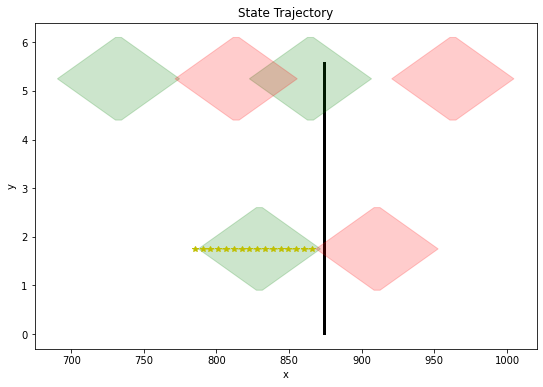

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[865.55   1.75  -0.    27.     0.  ]
124 th step ended
[865.55   1.75  -0.    27.     0.  ]
[865.55   1.75  -0.    27.     0.  ]
[865.55   1.75  -0.    27.     0.  ]
[865.55   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[870.95   1.75   0.    27.     0.  ]
[870.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


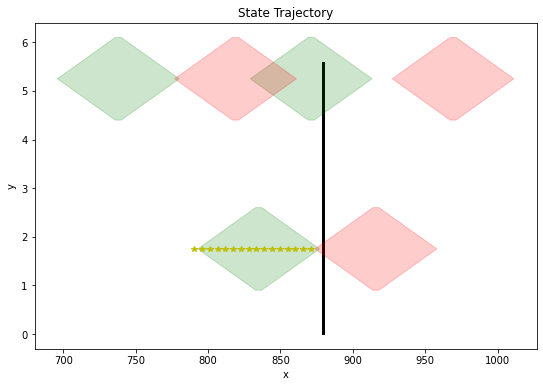

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[870.95   1.75  -0.    27.     0.  ]
125 th step ended
[870.95   1.75  -0.    27.     0.  ]
[870.95   1.75  -0.    27.     0.  ]
[870.95   1.75  -0.    27.     0.  ]
[870.95   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[876.35   1.75   0.    27.     0.  ]
[876.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


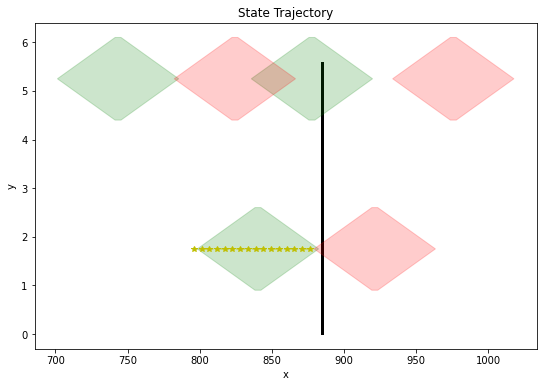

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[876.35   1.75  -0.    27.     0.  ]
126 th step ended
[876.35   1.75  -0.    27.     0.  ]
[876.35   1.75  -0.    27.     0.  ]
[876.35   1.75  -0.    27.     0.  ]
[876.35   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[881.75   1.75   0.    27.     0.  ]
[881.75   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


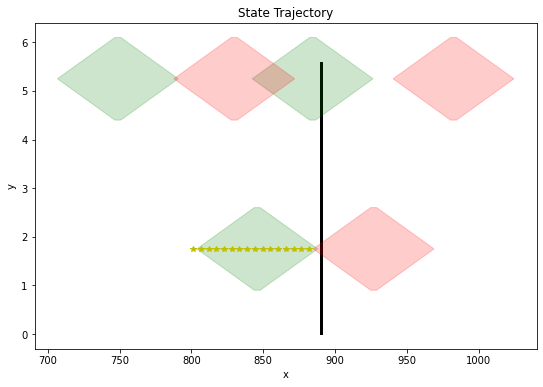

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[881.75   1.75  -0.    27.     0.  ]
127 th step ended
[881.75   1.75  -0.    27.     0.  ]
[881.75   1.75  -0.    27.     0.  ]
[881.75   1.75  -0.    27.     0.  ]
[881.75   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[887.15   1.75   0.    27.     0.  ]
[887.15   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


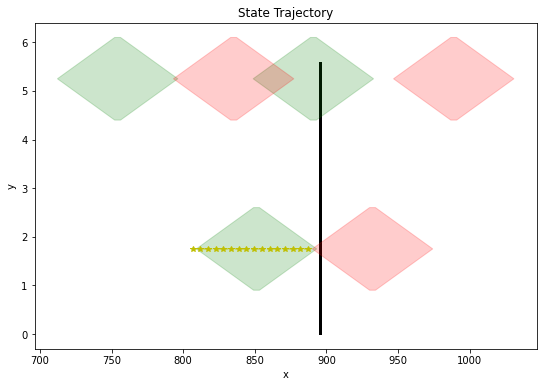

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[887.15   1.75  -0.    27.     0.  ]
128 th step ended
[887.15   1.75  -0.    27.     0.  ]
[887.15   1.75  -0.    27.     0.  ]
[887.15   1.75  -0.    27.     0.  ]
[887.15   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[892.55   1.75   0.    27.     0.  ]
[892.55   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


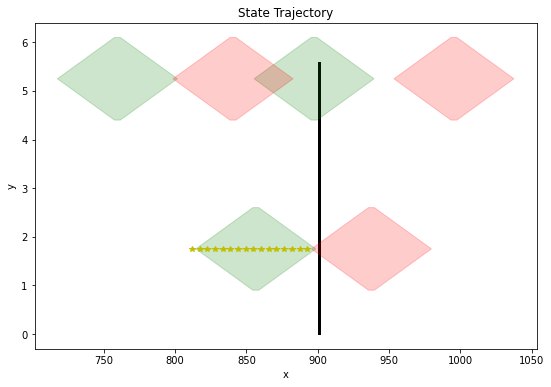

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[892.55   1.75  -0.    27.     0.  ]
129 th step ended
[892.55   1.75  -0.    27.     0.  ]
[892.55   1.75  -0.    27.     0.  ]
[892.55   1.75  -0.    27.     0.  ]
[892.55   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[897.95   1.75   0.    27.     0.  ]
[897.95   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


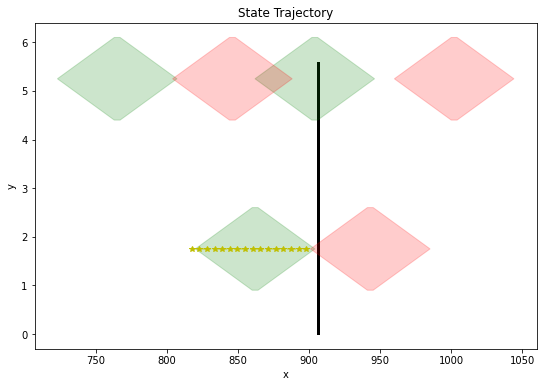

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[897.95   1.75  -0.    27.     0.  ]
130 th step ended
[897.95   1.75  -0.    27.     0.  ]
[897.95   1.75  -0.    27.     0.  ]
[897.95   1.75  -0.    27.     0.  ]
[897.95   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.0
[903.35   1.75   0.    27.     0.  ]
[903.35   1.75   0.    27.     0.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


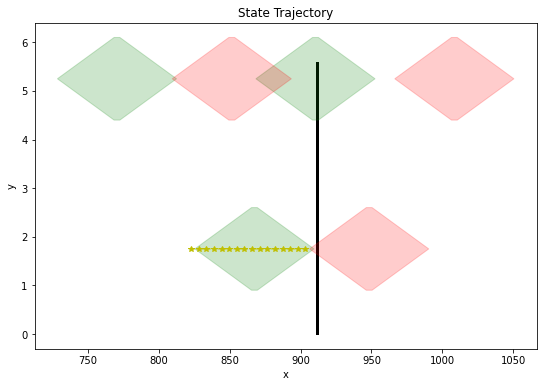

SV Lane Info :  [2, 2]
LV info :  [2, 0, 1]
[903.35   1.75  -0.    27.     0.  ]
131 th step ended
[903.35   1.75  -0.    27.     0.  ]
[903.35   1.75  -0.    27.     0.  ]
[903.35   1.75  -0.    27.     0.  ]
[903.35   1.75  -0.    27.     0.  ]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[916.751     5.17      0.       29.55722   0.64587]
[916.751     5.17      0.       29.55722   0.64587]
Move from lane 2 to 1 . LV info :  2   0
bug check


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


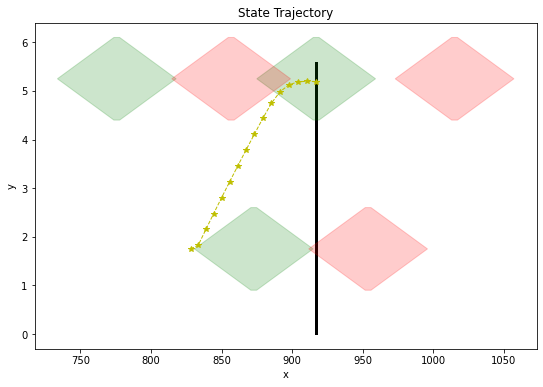

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-0.0568  -0.01661 -0.22755 -0.43679 -0.64433 -0.85017 -1.05431 -1.25676
  -1.4575  -1.65654 -1.8389  -1.94532 -1.95212 -1.87887 -1.75723 -1.61701]
 [-3.71732 -3.75752 -3.54658 -3.33734 -3.12979 -2.92395 -2.71981 -2.51737
  -2.31663 -2.11759 -1.93523 -1.8288  -1.82201 -1.89525 -2.0169  -2.15712]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[916.751     5.17      0.03857  29.55722   0.64587]
132 th step ended
[916.751     5.17      0.03857  29.55722   0.64587]
[916.751     5.17      0.03857  29.55722   0.64587]
[916.751     5.17      0.03857  29.55722   0.64587]
[916.751     5.17      0.03857  29.55722   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[922.75812   5.17      0.       29.77055   0.64587]
[922.75812   5.17    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


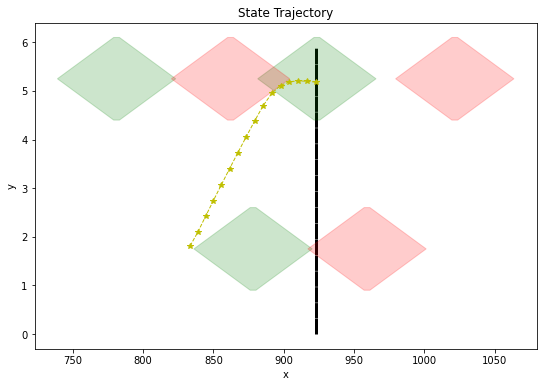

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-0.11818 -0.28401 -0.49325 -0.70079 -0.90663 -1.11077 -1.31321 -1.51396
  -1.713   -1.89949 -2.02504 -2.05292 -1.99636 -1.88415 -1.74345 -1.59453]
 [-3.65594 -3.49012 -3.28088 -3.07334 -2.86749 -2.66335 -2.46091 -2.26017
  -2.06113 -1.87463 -1.74909 -1.72121 -1.77777 -1.88998 -2.03067 -2.17959]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[922.75812   5.17      0.03761  29.77055   0.64587]
133 th step ended
[922.75812   5.17      0.03761  29.77055   0.64587]
[922.75812   5.17      0.03761  29.77055   0.64587]
[922.75812   5.17      0.03761  29.77055   0.64587]
[922.75812   5.17      0.03761  29.77055   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[928.84052   5.17      0.       29.98389   0.64587]
[928.84052   5.17    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


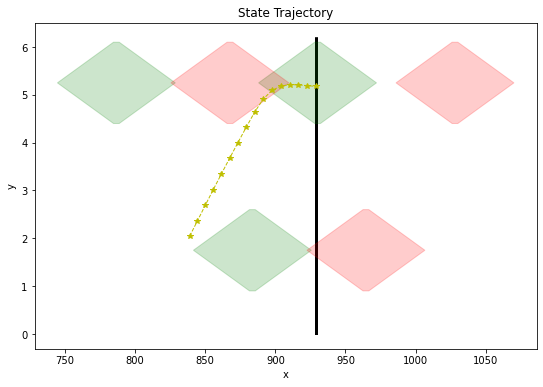

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-0.35197 -0.55371 -0.76125 -0.96709 -1.17123 -1.37367 -1.57441 -1.77345
  -1.96352 -2.10562 -2.15103 -2.10838 -2.00569 -1.87045 -1.72232 -1.57311]
 [-3.42216 -3.22042 -3.01288 -2.80704 -2.6029  -2.40045 -2.19971 -2.00067
  -1.8106  -1.6685  -1.62309 -1.66575 -1.76843 -1.90368 -2.05181 -2.20101]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[928.84052   5.17      0.03474  29.98389   0.64587]
134 th step ended
[928.84052   5.17      0.03474  29.98389   0.64587]
[928.84052   5.17      0.03474  29.98389   0.64587]
[928.84052   5.17      0.03474  29.98389   0.64587]
[928.84052   5.17      0.03474  29.98389   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[935.00138   5.17      0.       30.19722   0.64587]
[935.00138   5.17    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


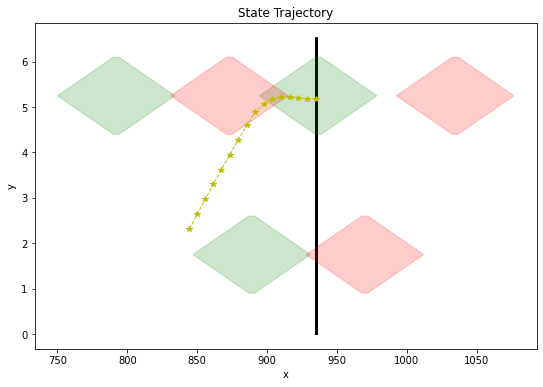

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-0.61932 -0.8257  -1.03154 -1.23569 -1.43813 -1.63887 -1.83791 -2.03121
  -2.18806 -2.24859 -2.21727 -2.12184 -1.991   -1.84562 -1.69768 -1.55279]
 [-3.15481 -2.94842 -2.74258 -2.53844 -2.336   -2.13526 -1.93621 -1.74291
  -1.58607 -1.52553 -1.55686 -1.65229 -1.78312 -1.92851 -2.07644 -2.22134]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[935.00138   5.17      0.03151  30.19722   0.64587]
135 th step ended
[935.00138   5.17      0.03151  30.19722   0.64587]
[935.00138   5.17      0.03151  30.19722   0.64587]
[935.00138   5.17      0.03151  30.19722   0.64587]
[935.00138   5.17      0.03151  30.19722   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[941.24188   5.17      0.       30.41055   0.64587]
[941.24188   5.17    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


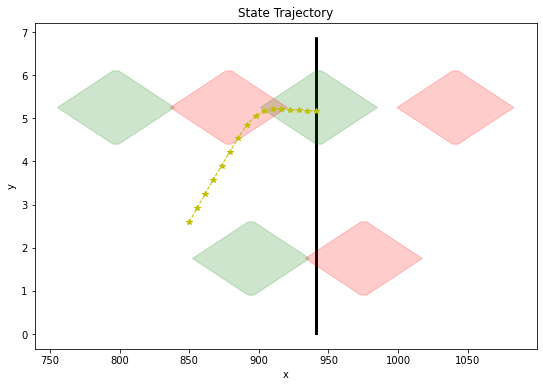

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-0.89432 -1.1     -1.30414 -1.50658 -1.70732 -1.90637 -2.10265 -2.27295
  -2.3471  -2.32557 -2.23581 -2.10772 -1.96359 -1.81651 -1.6724  -1.53298]
 [-2.8798  -2.67413 -2.46998 -2.26754 -2.0668  -1.86776 -1.67147 -1.50117
  -1.42703 -1.44855 -1.53831 -1.66641 -1.81053 -1.95761 -2.10173 -2.24114]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[941.24188   5.17      0.02823  30.41055   0.64587]
136 th step ended
[941.24188   5.17      0.02823  30.41055   0.64587]
[941.24188   5.17      0.02823  30.41055   0.64587]
[941.24188   5.17      0.02823  30.41055   0.64587]
[941.24188   5.17      0.02823  30.41055   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[947.56224   5.17      0.       30.62389   0.64587]
[947.56224   5.17    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


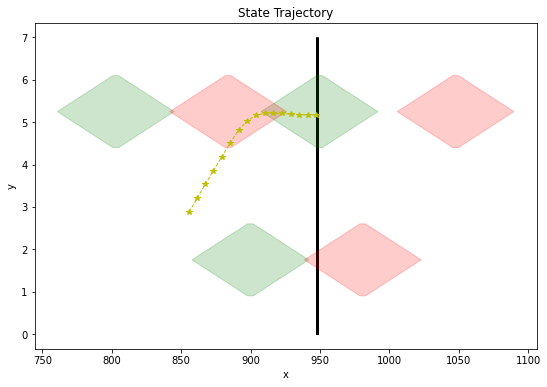

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-1.17248 -1.3766  -1.57904 -1.77978 -1.97882 -2.17616 -2.35281 -2.43923
  -2.42867 -2.34618 -2.22184 -2.07906 -1.93209 -1.78768 -1.64798 -1.51299]
 [-2.60165 -2.39753 -2.19509 -1.99435 -1.7953  -1.59796 -1.42131 -1.3349
  -1.34546 -1.42795 -1.55229 -1.69507 -1.84204 -1.98644 -2.12614 -2.26114]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[947.56224   5.17      0.02494  30.62389   0.64587]
137 th step ended
[947.56224   5.17      0.02494  30.62389   0.64587]
[947.56224   5.17      0.02494  30.62389   0.64587]
[947.56224   5.17      0.02494  30.62389   0.64587]
[947.56224   5.17      0.02494  30.62389   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[953.96249   5.17      0.       30.83722   0.64587]
[953.96249   5.17     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


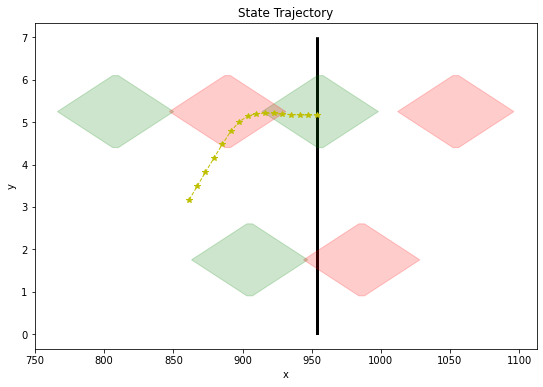

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-1.45305 -1.65549 -1.85624 -2.05528 -2.25262 -2.4316  -2.52901 -2.52953
  -2.45491 -2.33486 -2.19369 -2.04669 -1.90146 -1.7606  -1.62427 -1.49193]
 [-2.32107 -2.11863 -1.91789 -1.71885 -1.52151 -1.34252 -1.24512 -1.2446
  -1.31921 -1.43926 -1.58044 -1.72743 -1.87266 -2.01353 -2.14986 -2.28219]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[953.96249   5.17      0.02165  30.83722   0.64587]
138 th step ended
[953.96249   5.17      0.02165  30.83722   0.64587]
[953.96249   5.17      0.02165  30.83722   0.64587]
[953.96249   5.17      0.02165  30.83722   0.64587]
[953.96249   5.17      0.02165  30.83722   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[960.44264   5.17      0.       31.05055   0.64587]
[960.44264   5.17     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


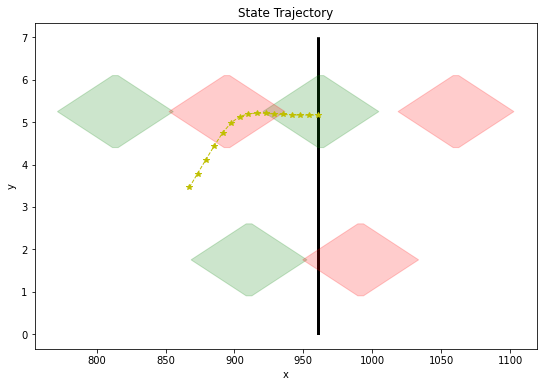

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-1.73595 -1.93669 -2.13573 -2.33307 -2.5141  -2.62126 -2.63162 -2.56395
  -2.44767 -2.30785 -2.16078 -2.01474 -1.87268 -1.73483 -1.60055 -1.46935]
 [-2.03817 -1.83743 -1.63839 -1.44105 -1.26003 -1.15286 -1.14251 -1.21017
  -1.32646 -1.46627 -1.61334 -1.75938 -1.90145 -2.0393  -2.17357 -2.30478]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[960.44264   5.17      0.01837  31.05055   0.64587]
139 th step ended
[960.44264   5.17      0.01837  31.05055   0.64587]
[960.44264   5.17      0.01837  31.05055   0.64587]
[960.44264   5.17      0.01837  31.05055   0.64587]
[960.44264   5.17      0.01837  31.05055   0.64587]
---------------------------------------------------------------------
risk value :  0.6458671964406718
[967.00269   5.17      0.       31.26389   0.64587]
[967.00269   5.17    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


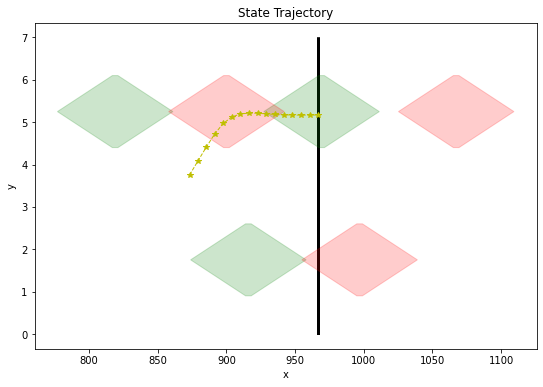

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-2.02115 -2.22019 -2.41753 -2.60043 -2.7162  -2.73517 -2.67353 -2.56044
  -2.42172 -2.27449 -2.12772 -1.98468 -1.84562 -1.70975 -1.5763  -1.44503]
 [-1.75298 -1.55394 -1.35659 -1.1737  -1.05793 -1.03896 -1.1006  -1.21368
  -1.35241 -1.49963 -1.6464  -1.78945 -1.9285  -2.06438 -2.19783 -2.3291 ]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[967.00269   5.17      0.01508  31.26389   0.64587]
140 th step ended
[967.00269   5.17      0.01508  31.26389   0.64587]
[967.00269   5.17      0.01508  31.26389   0.64587]
[967.00269   5.17      0.01508  31.26389   0.64587]
[967.00269   5.17      0.01508  31.26389   0.64587]
---------------------------------------------------------------------
risk value :  0.6459034777885436
[973.64264   5.16886   0.       31.47722   0.6459 ]
[973.64264   5.16886 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


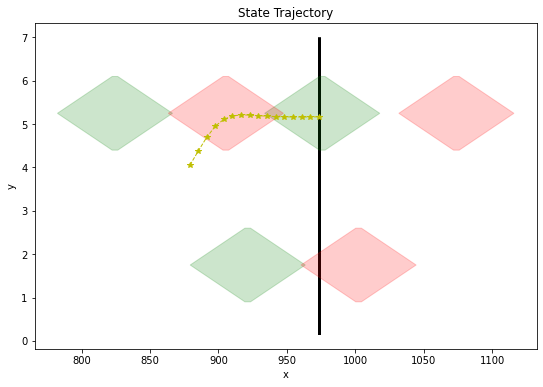

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-2.30865 -2.50599 -2.69052 -2.81342 -2.83946 -2.7827  -2.67212 -2.53414
  -2.38663 -2.23914 -2.09525 -1.95531 -1.81836 -1.68339 -1.54984 -1.41773]
 [-1.46548 -1.26814 -1.08361 -0.9607  -0.93467 -0.99142 -1.102   -1.23999
  -1.38749 -1.53499 -1.67887 -1.81882 -1.95576 -2.09073 -2.22428 -2.3564 ]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[973.64264   5.16886   0.01179  31.47722   0.6459 ]
141 th step ended
[973.64264   5.16886   0.01179  31.47722   0.6459 ]
[973.64264   5.16886   0.01179  31.47722   0.6459 ]
[973.64264   5.16886   0.01179  31.47722   0.6459 ]
[973.64264   5.16886   0.01179  31.47722   0.6459 ]
---------------------------------------------------------------------
risk value :  0.6459026281547842
[980.36249   5.16888   0.       31.69055   0.6459 ]
[980.36249   5.16888 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


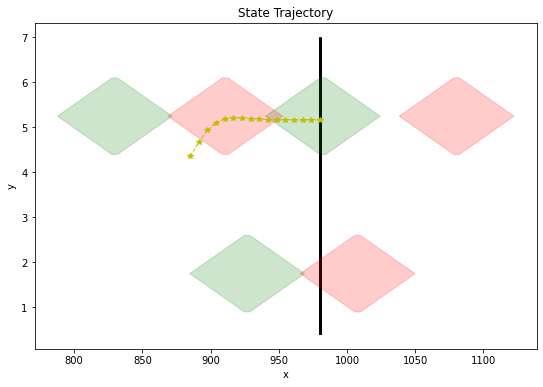

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-2.59845 -2.78443 -2.91362 -2.94587 -2.89336 -2.7849  -2.64744 -2.49955
  -2.35128 -2.20655 -2.06583 -1.92811 -1.79222 -1.65731 -1.52309 -1.38973]
 [-1.17568 -0.9897  -0.8605  -0.82825 -0.88076 -0.98923 -1.12669 -1.27458
  -1.42284 -1.56757 -1.7083  -1.84601 -1.9819  -2.11681 -2.25104 -2.38439]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[980.36249   5.16888   0.00851  31.69055   0.6459 ]
142 th step ended
[980.36249   5.16888   0.00851  31.69055   0.6459 ]
[980.36249   5.16888   0.00851  31.69055   0.6459 ]
[980.36249   5.16888   0.00851  31.69055   0.6459 ]
[980.36249   5.16888   0.00851  31.69055   0.6459 ]
---------------------------------------------------------------------
risk value :  0.6458436628102002
[987.15301   5.17649   0.       31.90066   0.64584]
[987.15301   5.17649 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


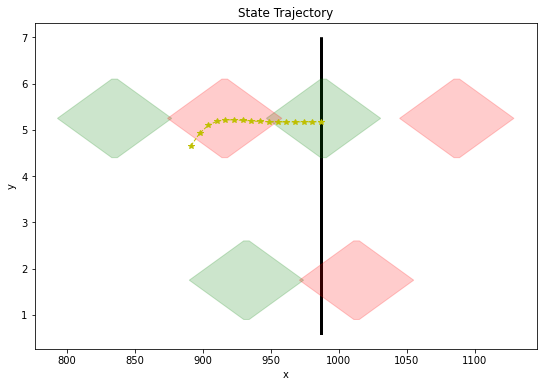

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-2.88143 -3.01421 -3.0538  -3.00782 -2.90354 -2.76798 -2.62039 -2.47154
  -2.32589 -2.1842  -2.04562 -1.90892 -1.77311 -1.63766 -1.50245 -1.3677 ]
 [-0.8927  -0.75991 -0.72032 -0.7663  -0.87059 -1.00615 -1.15374 -1.30259
  -1.44824 -1.58992 -1.7285  -1.8652  -2.00101 -2.13646 -2.27168 -2.40643]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[987.15301   5.17649   0.00541  31.90066   0.64584]
143 th step ended
[987.15301   5.17649   0.00541  31.90066   0.64584]
[987.15301   5.17649   0.00541  31.90066   0.64584]
[987.15301   5.17649   0.00541  31.90066   0.64584]
[987.15301   5.17649   0.00541  31.90066   0.64584]
---------------------------------------------------------------------
risk value :  0.645870468953075
[993.88306   5.17759   0.       32.06365   0.64587]
[993.88306   5.17759  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


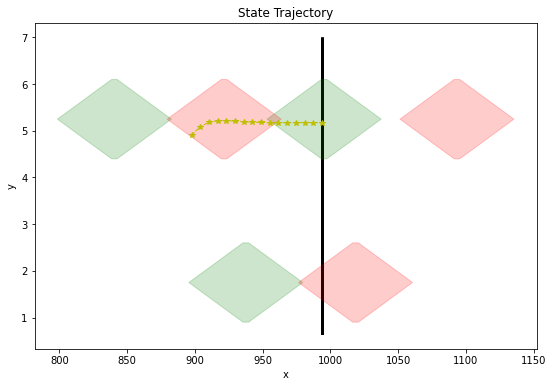

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-3.11731 -3.16102 -3.11889 -3.01713 -2.88273 -2.7353  -2.58604 -2.43974
  -2.29736 -2.15814 -2.02087 -1.88452 -1.74845 -1.61238 -1.47631 -1.3404 ]
 [-0.65681 -0.6131  -0.65524 -0.757   -0.8914  -1.03882 -1.18808 -1.33439
  -1.47677 -1.61599 -1.75326 -1.8896  -2.02567 -2.16174 -2.29782 -2.43373]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[993.88306   5.17759   0.00275  32.06365   0.64587]
144 th step ended
[993.88306   5.17759   0.00275  32.06365   0.64587]
[993.88306   5.17759   0.00275  32.06365   0.64587]
[993.88306   5.17759   0.00275  32.06365   0.64587]
[993.88306   5.17759   0.00275  32.06365   0.64587]
---------------------------------------------------------------------
risk value :  0.6458195680453103
[1000.56739    5.17475    0.        32.19008    0.64582]
[1000.56739    5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


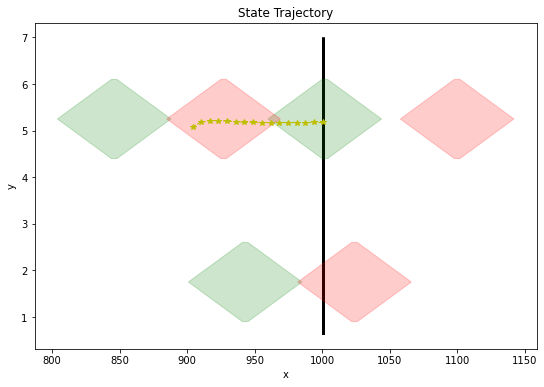

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-3.26963 -3.23026 -3.12954 -2.99515 -2.84722 -2.69729 -2.55033 -2.40738
  -2.26767 -2.12998 -1.99326 -1.85682 -1.72032 -1.58367 -1.4469  -1.31015]
 [-0.50449 -0.54387 -0.64458 -0.77898 -0.92691 -1.07683 -1.22379 -1.36675
  -1.50645 -1.64414 -1.78087 -1.91731 -2.05381 -2.19046 -2.32722 -2.46398]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[1000.56739    5.17475    0.00094   32.19008    0.64582]
145 th step ended
[1000.56739    5.17475    0.00094   32.19008    0.64582]
[1000.56739    5.17475    0.00094   32.19008    0.64582]
[1000.56739    5.17475    0.00094   32.19008    0.64582]
[1000.56739    5.17475    0.00094   32.19008    0.64582]
---------------------------------------------------------------------
risk value :  0.6459039254261107
[1007.21572    5.16885    0.        32.28816    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


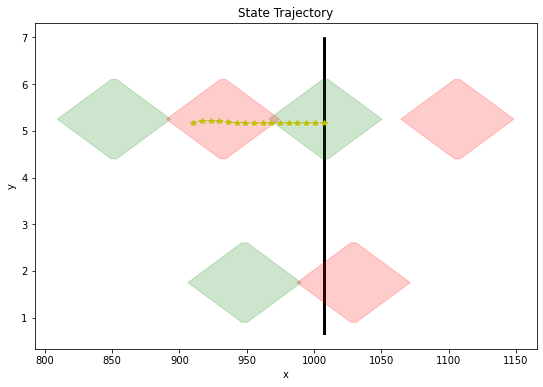

SV Lane Info :  [2, 1]
LV info :  [2, 0, 1]
[[-3.3424  -3.24296 -3.10761 -2.95808 -2.80668 -2.65863 -2.51495 -2.37477
  -2.23676 -2.09977 -1.96308 -1.82632 -1.68937 -1.55223 -1.41496 -1.27762]
 [-0.43173 -0.53116 -0.66651 -0.81605 -0.96745 -1.1155  -1.25918 -1.39935
  -1.53737 -1.67435 -1.81104 -1.9478  -2.08476 -2.2219  -2.35916 -2.4965 ]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[1007.21572    5.16885   -0.00009   32.28816    0.6459 ]
146 th step ended
[1007.21572    5.16885   -0.00009   32.28816    0.6459 ]
[1007.21572    5.16885   -0.00009   32.28816    0.6459 ]
[1007.21572    5.16885   -0.00009   32.28816    0.6459 ]
[1007.21572    5.16885   -0.00009   32.28816    0.6459 ]
---------------------------------------------------------------------
risk value :  0.6458181755724428
[1013.83541    5.17455    0.        32.36423    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


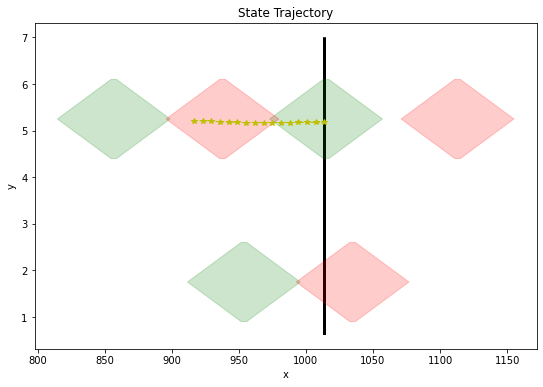

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1013.83541    5.17455   -0.0004    32.36423    0.64582]
147 th step ended
[1013.83541    5.17455   -0.0004    32.36423    0.64582]
[1013.83541    5.17455   -0.0004    32.36423    0.64582]
[1013.83541    5.17455   -0.0004    32.36423    0.64582]
[1013.83541    5.17455   -0.0004    32.36423    0.64582]
---------------------------------------------------------------------
risk value :  0.6458852943989828
[1020.43255    5.16939    0.        32.42325    0.64589]
[1020.43255    5.16939    0.        32.42325    0.64589]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


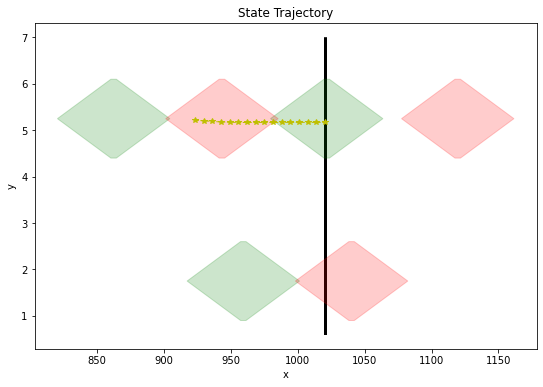

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1020.43255    5.16939   -0.00047   32.42325    0.64589]
148 th step ended
[1020.43255    5.16939   -0.00047   32.42325    0.64589]
[1020.43255    5.16939   -0.00047   32.42325    0.64589]
[1020.43255    5.16939   -0.00047   32.42325    0.64589]
[1020.43255    5.16939   -0.00047   32.42325    0.64589]
---------------------------------------------------------------------
risk value :  0.6458181423816893
[1027.01211    5.17293    0.        32.46903    0.64582]
[1027.01211    5.17293    0.        32.46903    0.64582]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


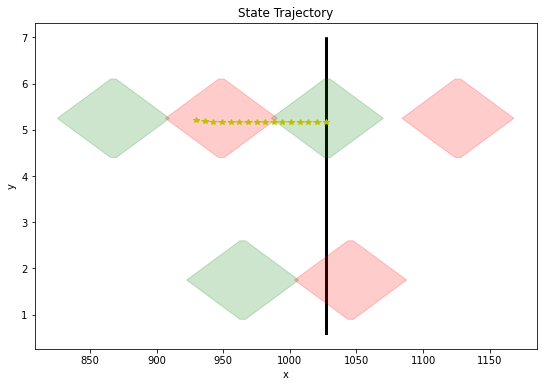

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1027.01211    5.17293   -0.00032   32.46903    0.64582]
149 th step ended
[1027.01211    5.17293   -0.00032   32.46903    0.64582]
[1027.01211    5.17293   -0.00032   32.46903    0.64582]
[1027.01211    5.17293   -0.00032   32.46903    0.64582]
[1027.01211    5.17293   -0.00032   32.46903    0.64582]
---------------------------------------------------------------------
risk value :  0.6458283995202188
[1033.58267    5.17188    0.        32.5061     0.64583]
[1033.58267    5.17188    0.        32.5061     0.64583]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


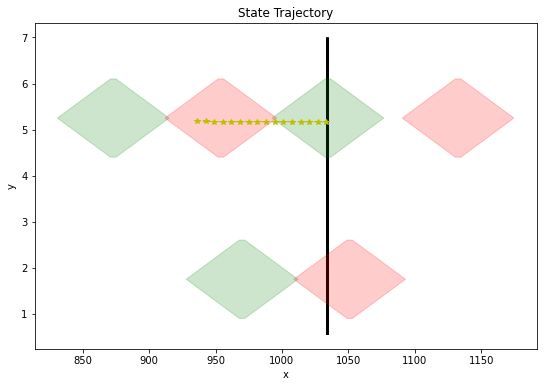

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1033.58267    5.17188   -0.00019   32.5061     0.64583]
150 th step ended
[1033.58267    5.17188   -0.00019   32.5061     0.64583]
[1033.58267    5.17188   -0.00019   32.5061     0.64583]
[1033.58267    5.17188   -0.00019   32.5061     0.64583]
[1033.58267    5.17188   -0.00019   32.5061     0.64583]
---------------------------------------------------------------------
risk value :  0.6458492536569351
[1040.14619    5.17675    0.        32.53618    0.64585]
[1040.14619    5.17675    0.        32.53618    0.64585]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


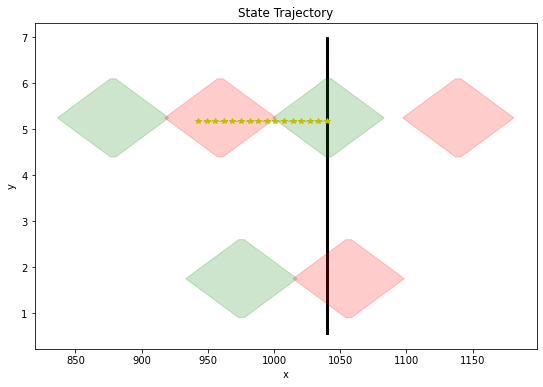

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1040.14619    5.17675   -0.00004   32.53618    0.64585]
151 th step ended
[1040.14619    5.17675   -0.00004   32.53618    0.64585]
[1040.14619    5.17675   -0.00004   32.53618    0.64585]
[1040.14619    5.17675   -0.00004   32.53618    0.64585]
[1040.14619    5.17675   -0.00004   32.53618    0.64585]
---------------------------------------------------------------------
risk value :  0.6458857327704928
[1046.70398    5.1781     0.        32.56059    0.64589]
[1046.70398    5.1781     0.        32.56059    0.64589]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


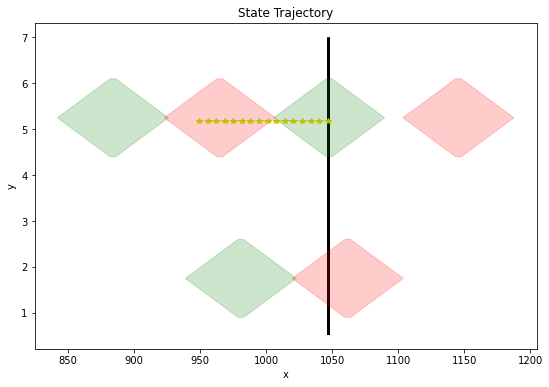

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1046.70398    5.1781     0.00004   32.56059    0.64589]
152 th step ended
[1046.70398    5.1781     0.00004   32.56059    0.64589]
[1046.70398    5.1781     0.00004   32.56059    0.64589]
[1046.70398    5.1781     0.00004   32.56059    0.64589]
[1046.70398    5.1781     0.00004   32.56059    0.64589]
---------------------------------------------------------------------
risk value :  0.6458158108002112
[1053.25713    5.17359    0.        32.5804     0.64582]
[1053.25713    5.17359    0.        32.5804     0.64582]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


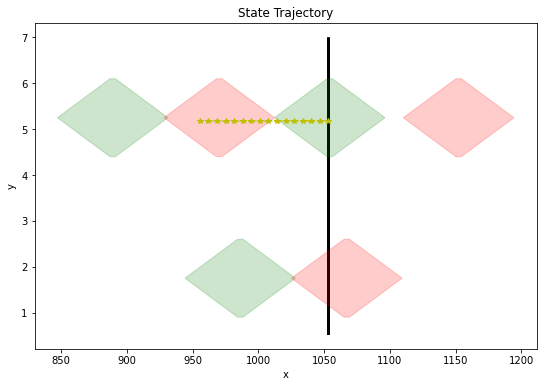

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1053.25713    5.17359    0.00001   32.5804     0.64582]
153 th step ended
[1053.25713    5.17359    0.00001   32.5804     0.64582]
[1053.25713    5.17359    0.00001   32.5804     0.64582]
[1053.25713    5.17359    0.00001   32.5804     0.64582]
[1053.25713    5.17359    0.00001   32.5804     0.64582]
---------------------------------------------------------------------
risk value :  0.645875017356445
[1059.80651    5.16973    0.        32.59647    0.64588]
[1059.80651    5.16973    0.        32.59647    0.64588]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


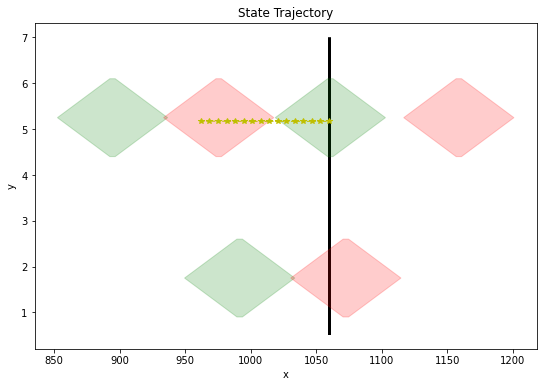

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1059.80651    5.16973   -0.00004   32.59647    0.64588]
154 th step ended
[1059.80651    5.16973   -0.00004   32.59647    0.64588]
[1059.80651    5.16973   -0.00004   32.59647    0.64588]
[1059.80651    5.16973   -0.00004   32.59647    0.64588]
[1059.80651    5.16973   -0.00004   32.59647    0.64588]
---------------------------------------------------------------------
risk value :  0.645825077650447
[1066.35284    5.17533    0.        32.60952    0.64583]
[1066.35284    5.17533    0.        32.60952    0.64583]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


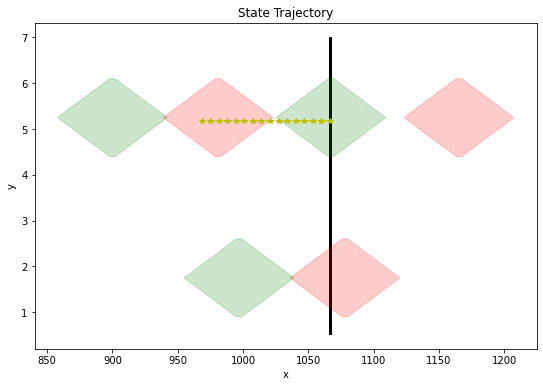

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1066.35284    5.17533    0.00002   32.60952    0.64583]
155 th step ended
[1066.35284    5.17533    0.00002   32.60952    0.64583]
[1066.35284    5.17533    0.00002   32.60952    0.64583]
[1066.35284    5.17533    0.00002   32.60952    0.64583]
[1066.35284    5.17533    0.00002   32.60952    0.64583]
---------------------------------------------------------------------
risk value :  0.6458181260210915
[1072.89667    5.17293    0.        32.62011    0.64582]
[1072.89667    5.17293    0.        32.62011    0.64582]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


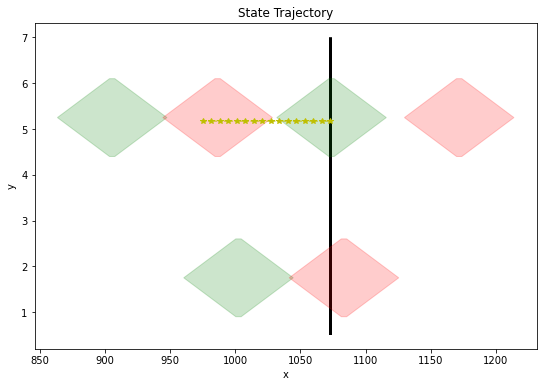

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1072.89667    5.17293    0.        32.62011    0.64582]
156 th step ended
[1072.89667    5.17293    0.        32.62011    0.64582]
[1072.89667    5.17293    0.        32.62011    0.64582]
[1072.89667    5.17293    0.        32.62011    0.64582]
[1072.89667    5.17293    0.        32.62011    0.64582]
---------------------------------------------------------------------
risk value :  0.645847843806345
[1079.4385     5.17078    0.        32.62871    0.64585]
[1079.4385     5.17078    0.        32.62871    0.64585]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


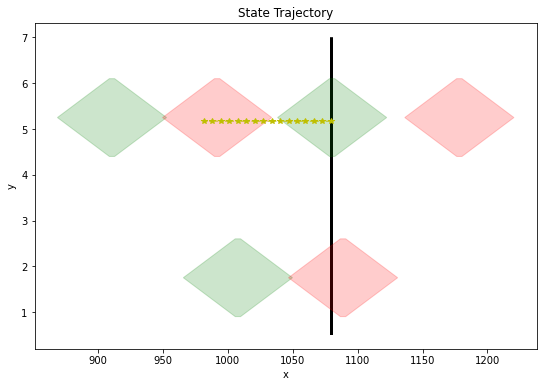

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1079.4385     5.17078   -0.00002   32.62871    0.64585]
157 th step ended
[1079.4385     5.17078   -0.00002   32.62871    0.64585]
[1079.4385     5.17078   -0.00002   32.62871    0.64585]
[1079.4385     5.17078   -0.00002   32.62871    0.64585]
[1079.4385     5.17078   -0.00002   32.62871    0.64585]
---------------------------------------------------------------------
risk value :  0.645892892211458
[1085.97868    5.17832    0.        32.63568    0.64589]
[1085.97868    5.17832    0.        32.63568    0.64589]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


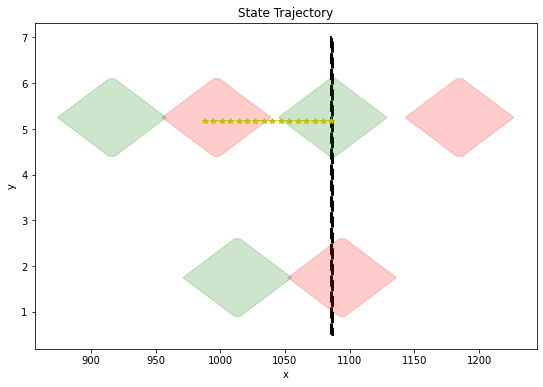

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1085.97868    5.17832    0.00005   32.63568    0.64589]
158 th step ended
[1085.97868    5.17832    0.00005   32.63568    0.64589]
[1085.97868    5.17832    0.00005   32.63568    0.64589]
[1085.97868    5.17832    0.00005   32.63568    0.64589]
[1085.97868    5.17832    0.00005   32.63568    0.64589]
---------------------------------------------------------------------
risk value :  0.6458901663658291
[1092.51754    5.17824    0.        32.64134    0.64589]
[1092.51754    5.17824    0.        32.64134    0.64589]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


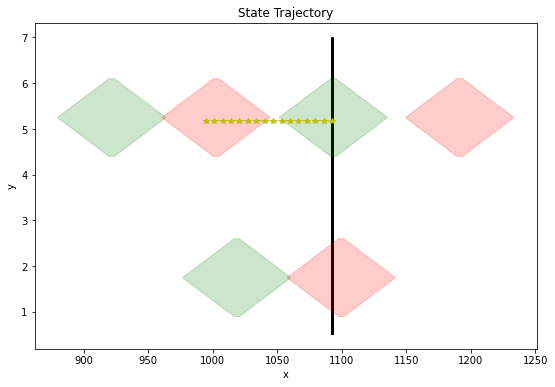

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1092.51754    5.17824    0.00006   32.64134    0.64589]
159 th step ended
[1092.51754    5.17824    0.00006   32.64134    0.64589]
[1092.51754    5.17824    0.00006   32.64134    0.64589]
[1092.51754    5.17824    0.00006   32.64134    0.64589]
[1092.51754    5.17824    0.00006   32.64134    0.64589]
---------------------------------------------------------------------
risk value :  0.6459058928415669
[1099.05533    5.16879    0.        32.64593    0.64591]
[1099.05533    5.16879    0.        32.64593    0.64591]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


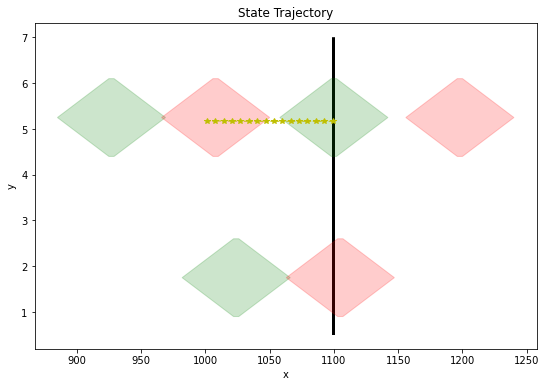

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1099.05533    5.16879   -0.00006   32.64593    0.64591]
160 th step ended
[1099.05533    5.16879   -0.00006   32.64593    0.64591]
[1099.05533    5.16879   -0.00006   32.64593    0.64591]
[1099.05533    5.16879   -0.00006   32.64593    0.64591]
[1099.05533    5.16879   -0.00006   32.64593    0.64591]
---------------------------------------------------------------------
risk value :  0.6458442836853091
[1105.59223    5.17652    0.        32.64966    0.64584]
[1105.59223    5.17652    0.        32.64966    0.64584]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


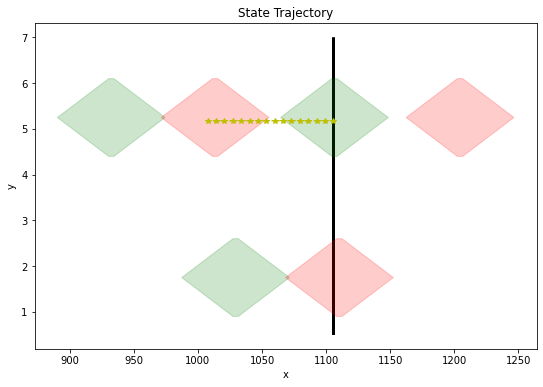

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1105.59223    5.17652    0.00001   32.64966    0.64584]
161 th step ended
[1105.59223    5.17652    0.00001   32.64966    0.64584]
[1105.59223    5.17652    0.00001   32.64966    0.64584]
[1105.59223    5.17652    0.00001   32.64966    0.64584]
[1105.59223    5.17652    0.00001   32.64966    0.64584]
---------------------------------------------------------------------
risk value :  0.645831939522451
[1112.12843    5.17583    0.        32.65269    0.64583]
[1112.12843    5.17583    0.        32.65269    0.64583]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


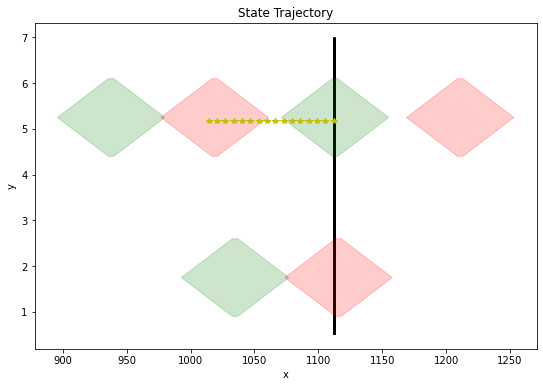

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1112.12843    5.17583    0.00001   32.65269    0.64583]
162 th step ended
[1112.12843    5.17583    0.00001   32.65269    0.64583]
[1112.12843    5.17583    0.00001   32.65269    0.64583]
[1112.12843    5.17583    0.00001   32.65269    0.64583]
[1112.12843    5.17583    0.00001   32.65269    0.64583]
---------------------------------------------------------------------
risk value :  0.6458286131077469
[1118.66405    5.17561    0.        32.65514    0.64583]
[1118.66405    5.17561    0.        32.65514    0.64583]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


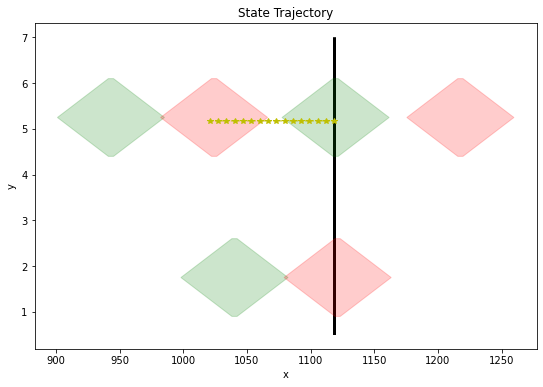

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1118.66405    5.17561    0.00001   32.65514    0.64583]
163 th step ended
[1118.66405    5.17561    0.00001   32.65514    0.64583]
[1118.66405    5.17561    0.00001   32.65514    0.64583]
[1118.66405    5.17561    0.00001   32.65514    0.64583]
[1118.66405    5.17561    0.00001   32.65514    0.64583]
---------------------------------------------------------------------
risk value :  0.6458263591864759
[1125.19921    5.17543    0.        32.65713    0.64583]
[1125.19921    5.17543    0.        32.65713    0.64583]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


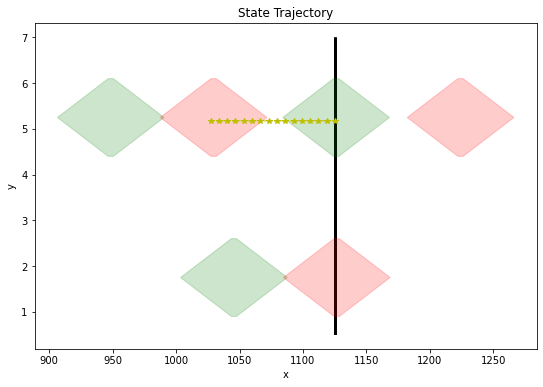

SV Lane Info :  [1, 1]
LV info :  [1, -1, 2]
[1125.19921    5.17543    0.        32.65713    0.64583]
164 th step ended
[1125.19921    5.17543    0.        32.65713    0.64583]
[1125.19921    5.17543    0.        32.65713    0.64583]
[1125.19921    5.17543    0.        32.65713    0.64583]
[1125.19921    5.17543    0.        32.65713    0.64583]
---------------------------------------------------------------------
Feasiblilty :  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  

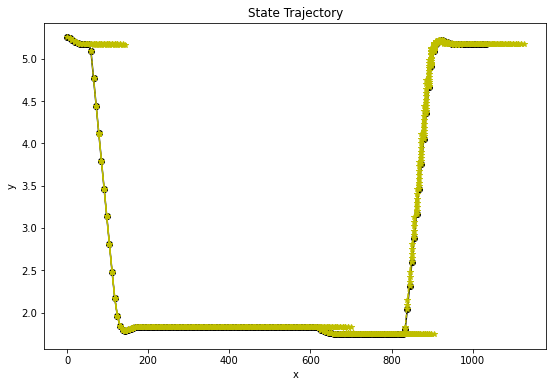

In [21]:
############ Initialize the system #################
U_safe = 0.647
sampling_time = 0.2
N = 15
SV = Subject_vehicle(SV_initial_x, SV_initial_y, SV_initial_psi)
LV_initialize  = np.array([[SV_initial_x + 63, SV_initial_x + 160, SV_initial_x + 160],  # x coordinate [m] # modified. 110 220 330. Threshold : 80
                           [lane_width/2*3, lane_width/2*3, lane_width/2],       # y coordinate [m]
                           [27, 27, 27]])                                           # velocity [m/s]

LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
LV3 = Lead_vehicle(LV_initialize[0,2], LV_initialize[1,2], LV_initialize[2,2])
LV_list = [LV1, LV2, LV3]
####################################################

x0 = SV.getState()
M = 165  # 165
feas = np.zeros((M), dtype=bool)
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((4, N+1, M))
uPred = np.zeros((2, N, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_state_data = np.zeros((5, M))

xOpt[:,0] = x0
LV1_pos[:,0] = LV1.getPosition()
LV2_pos[:,0] = LV2.getPosition()
LV3_pos[:,0] = LV3.getPosition()
LV1_pos_pred[:,0] = LV1.getPosition_predict()
LV2_pos_pred[:,0] = LV2.getPosition_predict()
LV3_pos_pred[:,0] = LV3.getPosition_predict()

uOpt = np.zeros((np.size(SV.B,1), M))
# predErr = np.zeros((2, M-N+1))
# xPred = np.zeros((2, N+1, M))

for t in range(M) :
  surround_LV_info = detect_LV(SV, LV_list)

  # Before getting target state, calculate reachable set and risk map
  # if it is cruise mode, skip this step
  reachable_set = get_reachable_set(xOpt[0,t], xOpt[1,t], xOpt[2,t], xOpt[3,t], sampling_time, N, SV)

  tmp = pt.extreme(reachable_set)
  x_max = np.amax(tmp[:,0])
  x_min = np.amin(tmp[:,0])
  y_max = np.amax(tmp[:,1])
  y_min = np.amin(tmp[:,1])
  X = pt.box2poly([[x_min, x_max], [y_min, y_max]])
  xx, yy = get_point_in_2D_bbox(reachable_set)

  # Make risk map
  risk_map = np.zeros((3,xx.size))
  index = 0
  for i in range(xx.shape[0]) :
    for j in range(xx.shape[1]) :
      risk_map[0,index] = xx[i,j]
      risk_map[1,index] = yy[i,j]
      risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1, LV2, LV3, True) # modified : car_potential_off = True
      index += 1
  # print(risk_map)

  # Get target point from the risk map. The output is [x_target, y_target, risk_value]
  target_state = get_target_state(risk_map, SV, xOpt[0,t], surround_LV_info, LV_list)
  print('risk value : ', target_state[4])
  print(target_state)
  # Change MPC Cost Matrix depends on SV.drive_mode
  [P, Q, R, Af, bf] = MPC_cost_matrix(target_state, SV)
  print(target_state)
  [fea, x, u, J] = solve_cftoc_onlyCar(SV.A, SV.B, P, Q, R, N, xOpt[:,t], X_set, U_set, bf, Af, SV, surround_LV_info, LV_list, True, X)
  print(target_state)
  if not fea :
    # xOpt = []
    # uOpt = []
    break
  print(t,'th step ended')
  feas[t] = True
  xPred[:,:,t] = x
  uPred[:,:,t] = u
  SV.update_state_Notapprox(u[:,0])  # modified update_state_approx
  print(target_state)

  if SV.getDriveMode() == CRUISE_MODE :
    LV2.setVelocity(32.67)
  LV1.updatePosition()
  LV2.updatePosition()
  LV3.updatePosition()
  print(target_state)
  xOpt[:,t+1] = SV.getState()
  LV1_pos[:,t+1] = LV1.getPosition()
  LV2_pos[:,t+1] = LV2.getPosition()
  LV3_pos[:,t+1] = LV3.getPosition()
  print(target_state)
  LV1_pos_pred[:,t+1] = LV1.getPosition_predict()
  LV2_pos_pred[:,t+1] = LV2.getPosition_predict()
  LV3_pos_pred[:,t+1] = LV3.getPosition_predict()
  target_state_data[:,t] = target_state
  uOpt[:,t] = u[:,0]
  print(target_state)
  print('---------------------------------------------------------------------')

print('Feasiblilty : ',feas)
print(xOpt)
print(uOpt)

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.show()


In [ ]:
print(xOpt)
print(reachable_set)
# print(reachable_set.reduce())
print(reachable_set.project([1,2]))
print(pt.extreme(reachable_set))

[[  0.        6.534    13.06788  19.60168  26.13542  32.66908  39.20266
   45.65036  51.99936  58.24097  64.36986  70.38352  76.2817   82.066
   87.73942  93.3061   98.77097 104.13954 109.41771 114.61159 119.72736
  124.77118 129.74905 134.66683 139.53009 144.34416 149.11405 153.84443
  158.53966 163.20378 167.84047 172.45312 177.04481 181.61831 186.17614
  190.72054 195.2535  199.77682 204.29206 208.80061 213.30366 217.80228
  222.29737 226.78971 231.27996 235.76871 240.25628 244.74291 249.22883
  253.71425 258.19934 262.68427 267.16919 271.65421 276.13946 280.62503
  285.111   289.59744 294.0844  298.57194 303.06009 307.54887 312.0383
  316.52839 321.01915 325.51057 330.00264 334.49536 338.9887  343.48265
  347.97718 352.47228 356.9679  361.46404 365.96065 370.45771 374.95518
  379.45305 383.95128 388.44984 392.94871   0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.     ]
 [  5.25      5.2453    5.22402   5.20213   5.18508   5.17019   5.15383

[1, 1]
[1, -1]
[[ 98.007   104.53979 111.07246 117.60505 124.13757 117.95    122.45
  126.95    131.45    135.95    140.45    144.95    149.45    153.95
  158.45    162.95    167.45    171.95    176.45    180.95    185.45
  189.95    194.45    198.95    203.45    207.95    212.45    216.95
  221.45    225.95    230.45    234.95    239.45    243.95    248.45
  252.95    257.45    261.95    266.45    270.95    275.45    279.95
  284.45    288.95    293.45    297.95    302.45    306.95    311.45
  315.95    320.45    324.95    329.45    333.95    338.45    342.95
  347.45    351.95    356.45    360.95    365.45    369.95    374.45
  378.95      0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.     ]
 [  5.17729   5.17657   5.17363   5.16557   5.12225   5.25      5.25
    5.25      5.25      5.25   

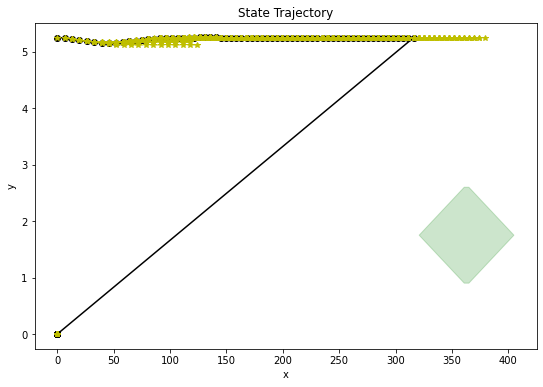

In [ ]:
print(SV.getLaneInfo())
print(detect_LV(SV, LV_list))
print(target_state_data)
wedge_LV1 = LV1.getWedgePoints()

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')

plt.show()


(-73.0, 263.4999999999999)

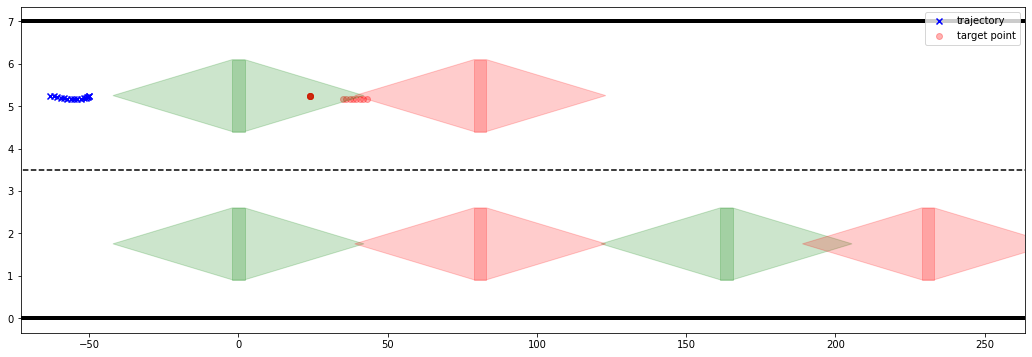

In [ ]:
# print(xOpt)
# print(LV1_pos)
# print(LV2_pos)
# print(target_point)
# print(xOpt[0,:])
# print(LV1_pos[0,:])
# print(xOpt[0,:] - LV1_pos[0,:])

wedge_LV1 = LV1.getWedgePoints()
vertice_LV1 = wedge_LV1[[1,2,4,5],:]
wedge_LV2 = LV2.getWedgePoints()
vertice_LV2 = wedge_LV2[[1,2,4,5],:]
wedge_LV3 = LV3.getWedgePoints()
vertice_LV3 = wedge_LV3[[1,2,4,5],:]

wedge_LV1[:,0] = wedge_LV1[:,0] - LV1.getPosition()[0]
vertice_LV1[:,0] = vertice_LV1[:,0] - LV1.getPosition()[0]
wedge_LV2[:,0] = wedge_LV2[:,0] - LV1.getPosition()[0]
vertice_LV2[:,0] = vertice_LV2[:,0] - LV1.getPosition()[0]
wedge_LV3[:,0] = wedge_LV3[:,0] - LV1.getPosition()[0]
vertice_LV3[:,0] = vertice_LV3[:,0] - LV1.getPosition()[0]

##---- Predicted location ----##
wedge_predict_LV1 = LV1.getWedgePoints_predict()
vertice_predict_LV1 = wedge_predict_LV1[[1,2,4,5],:]
wedge_predict_LV2 = LV2.getWedgePoints_predict()
vertice_predict_LV2 = wedge_predict_LV2[[1,2,4,5],:]
wedge_predict_LV3 = LV3.getWedgePoints_predict()
vertice_predict_LV3 = wedge_predict_LV3[[1,2,4,5],:]

wedge_predict_LV1[:,0] = wedge_predict_LV1[:,0] - LV1.getPosition()[0]
vertice_predict_LV1[:,0] = vertice_predict_LV1[:,0] - LV1.getPosition()[0]
wedge_predict_LV2[:,0] = wedge_predict_LV2[:,0] - LV1.getPosition()[0]
vertice_predict_LV2[:,0] = vertice_predict_LV2[:,0] - LV1.getPosition()[0]
wedge_predict_LV3[:,0] = wedge_predict_LV3[:,0] - LV1.getPosition()[0]
vertice_predict_LV3[:,0] = vertice_predict_LV3[:,0] - LV1.getPosition()[0]
################################

fig, ax = plt.subplots(1,1, figsize=(18,6))
ax.scatter(xOpt[0,:] - LV1_pos[0,:], xOpt[1,:],  marker ='x', c = 'b')
ax.scatter(target_state_data[0,:] - LV1_pos[0,:-1], target_state_data[1,:], alpha = 0.3, marker ='o', c = 'r')
ax.legend(['trajectory', 'target point'])

ax.plot([-1000, 1000], [lane_width, lane_width], '--', c = 'k')
ax.plot([-1000, 1000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax.plot([-1000, 1000], [0, 0], linewidth = 4, c = 'k')
ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV1[:,0], vertice_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV2[:,0], vertice_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV3[:,0], wedge_LV3[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV3[:,0], vertice_LV3[:,1], alpha = 0.2, c = 'g')

ax.fill(wedge_predict_LV1[:,0], wedge_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV1[:,0], vertice_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV2[:,0], wedge_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV2[:,0], vertice_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV3[:,0], wedge_predict_LV3[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV3[:,0], vertice_predict_LV3[:,1], alpha = 0.2, c = 'r')

ax.set_xlim([xOpt[0,0] - LV1_pos[0,0] - 10, LV3.getPosition()[0] - LV1.getPosition()[0] + 100])

[[-0.00076 -0.00046 -0.00027 -0.00016 -0.0001  -0.00006 -0.00004 -0.00002
  -0.00001 -0.00001 -0.      -0.      -0.      -0.       0.     ]
 [-0.02216  0.       0.       0.       0.       0.       0.       0.
   0.       0.00602  0.00708  0.00549  0.00329  0.00138 -0.00009]]
[[ 52.26873  58.80204  65.33531  71.86857  78.40181  84.93505  91.46828
   98.00152 104.53475 111.06798 117.6012  124.13443 130.66766 137.20089
  143.73412 150.26735]
 [  5.17113   5.09495   4.76825   4.44155   4.11485   3.78815   3.46145
    3.13474   2.80804   2.48134   2.17452   1.95913   1.8419    1.79761
    1.79511   1.80785]
 [ -0.00046  -0.05     -0.05     -0.05     -0.05     -0.05     -0.05
   -0.05     -0.05     -0.05     -0.03654  -0.02072  -0.00844  -0.00108
    0.002     0.00179]
 [ 32.66652  32.66637  32.66628  32.66622  32.66619  32.66617  32.66616
   32.66615  32.66615  32.66614  32.66614  32.66614  32.66614  32.66614
   32.66614  32.66614]]
[150.26717   1.82658  -0.03413  32.66614   0.64582]
-0.000

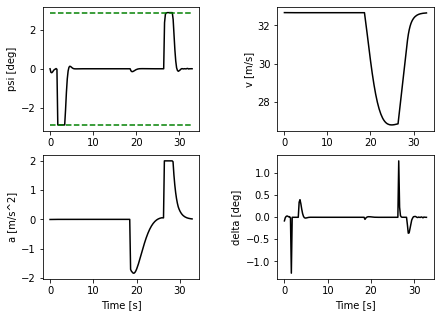

In [26]:
rad2deg = 180/np.pi
time = np.arange(0, M+1,1) * 0.2
fig, ax = plt.subplots(2,2, figsize = (7,5))
ax[0,0].plot(time, rad2deg * xOpt[2,:], 'k')
ax[0,0].plot(time, rad2deg * SV_psi_upper * np.ones(np.size(xOpt,1),), 'g--')
ax[0,0].plot(time, rad2deg * SV_psi_lower * np.ones(np.size(xOpt,1),), 'g--')
ax[0,1].plot(time, xOpt[3,:], 'k')
ax[1,0].plot(time[0:-1], uOpt[0,:], 'k')
ax[1,1].plot(time[0:-1], rad2deg * uOpt[1,:],'k')
fig.subplots_adjust(wspace=0.5)
ax[0,0].set_ylabel('psi [deg]')
ax[0,1].set_ylabel('v [m/s]')
ax[1,0].set_ylabel('a [m/s^2]')
ax[1,1].set_ylabel('delta [deg]')
ax[1,0].set_xlabel('Time [s]')
ax[1,1].set_xlabel('Time [s]')

i = 8
print(uPred[:,:,i])
print(xPred[:,:,i])
print(target_state_data[:,i])
print(np.sum(uPred[:,:,i]) * 0.2)

# fig, ax = plt.subplots(2,2, figsize = (7,5))
# ax[0].plot()

# SV_psi_lower = -0.035
# SV_psi_upper = 0.035
# SV_v_lower = 22.5
# SV_v_upper = SV_v_desired

# SV_a_upper = 1.5 # [m/s^2]
# SV_a_lower = -1.5
# SV_delta_upper = 0.02 # [rad]
# SV_delta_lower = -0.02
# print(xOpt[:,44] in X_set) 

# Animation Maker:

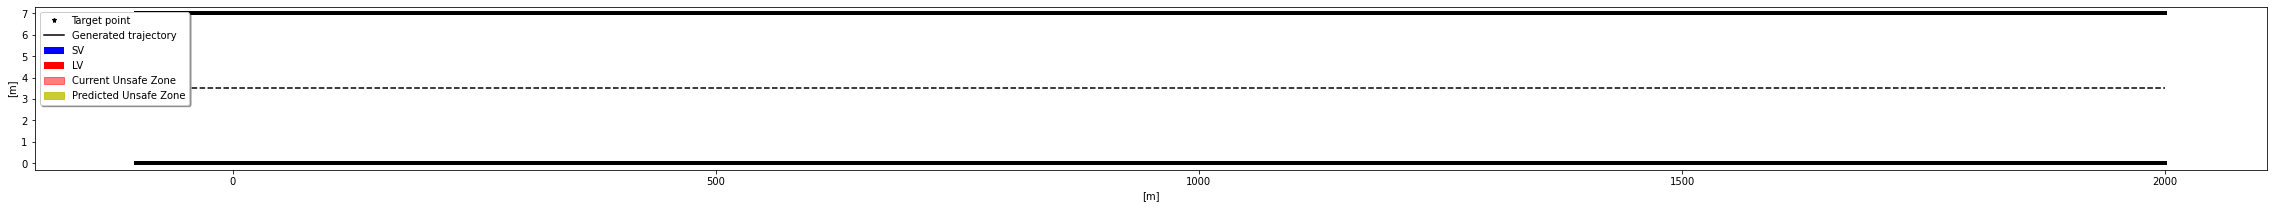

In [22]:
################## ANIMATION #####################
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(40,3))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-0.3, num_lane*lane_width+0.3))
ax1.set_xlabel('[m]')
ax1.set_ylabel('[m]')

ax1.plot([-100, 2000], [lane_width, lane_width], '--', c = 'k')
ax1.plot([-100, 2000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax1.plot([-100, 2000], [0, 0], linewidth = 4, c = 'k')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
target_pt, = ax1.plot([], [], 'k*', ms=5)
traj_pred, = ax1.plot([], [], 'k', )
SV_anim, = ax1.fill([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects

LV1_anim, = ax1.fill([], [], 'r')
LV1_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV1_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV2_anim, = ax1.fill([], [], 'r')
LV2_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV2_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV3_anim, = ax1.fill([], [], 'r')
LV3_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV3_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

ax1.legend([target_pt, traj_pred, SV_anim, LV1_anim, LV1_unsafe_anim, LV1_pred_anim],['Target point','Generated trajectory', 'SV', 'LV', 'Current Unsafe Zone', 'Predicted Unsafe Zone'],
           loc='upper left', shadow=True);

In [23]:
'''
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((3, N+1, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_point = np.zeros((3, M))
'''

def SV_draw(state) :
  l_f = SV.l_f
  l_r = SV.l_r
  car_width=1.7
  x = state[0]
  y = state[1]
  psi = state[2]
  SV_vertice_x = np.array([[x + l_f*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) + car_width/2*np.sin(psi),
                           x + l_f*np.cos(psi) + car_width/2*np.sin(psi)]])
  SV_vertice_y = np.array([[y + l_f*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) - car_width/2*np.cos(psi),
                           y + l_f*np.sin(psi) - car_width/2*np.cos(psi)]])
  SV_vertice = np.concatenate((SV_vertice_x.T, SV_vertice_y.T), axis=1)

  return SV_vertice

print(SV_draw(xOpt[:,10]))
def drawframe(n):
  ax1.set_xlim((xOpt[0,n]-20, xOpt[0,n]+120))
  target_pt.set_data(target_state_data[0,n], target_state_data[1,n])
  traj_pred.set_data(xPred[0,:,n], xPred[1,:,n]) 
  SV_anim.set_xy(SV_draw(xOpt[:,n]))

  LV1_anim.set_xy(LV1.getVertice_anim(LV1_pos[:,n]))
  LV1_unsafe_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos[:,n]))
  LV1_pred_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos_pred[:,n]))

  LV2_anim.set_xy(LV2.getVertice_anim(LV2_pos[:,n]))
  LV2_unsafe_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos[:,n]))
  LV2_pred_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos_pred[:,n]))

  LV3_anim.set_xy(LV3.getVertice_anim(LV3_pos[:,n]))
  LV3_unsafe_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos[:,n]))
  LV3_pred_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos_pred[:,n]))

  txt_title.set_text('Time = {0:4f}s'.format(n*0.2))
  
  return (target_pt,traj_pred)

[[66.81338  5.54509]
 [63.89403  5.69118]
 [63.80907  3.9933 ]
 [66.72841  3.84721]]


In [24]:
from matplotlib import animation
from IPython.display import HTML

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=M, interval=300, blit=True)

HTML(anim.to_html5_video())

In [25]:
'''
How to improve the model :
## Problem1 : Setting target point right behind of the front LV seems not reasonable intuitively 
## Problem2 : Since the cftoc design doesn't consider the risk map, the actual trajectory of SV intrudes unsafe zone of LVs. 

Here's idea to solve :
1) Problem1 : When calcuate car_potential value, let's consider predicted LV's configuration after ts*N sec (rather than considering the LV's configuration of when it was observed)
2) Problem2 : When solve cftoc, add constraint about x and y not to intrude the unsafe region. - But how?
                                                                                    - Need two information : LV in front of SV (Front obstacle), LV on the lane that SV will move to (Side obstacle) 
                                                                                    - May need three scenario : 1) changes lane (there's only Front obstacle) 2) after cross the middle line of the road, goes to steady state 
                                                                                                                3) changes lane (there are Front and Side obstacles) - refer to situation below. LV1 - Side obstacle, LV2 - Front 
                                                                                    
                                                                                    ==============================================================
                                                                                                 \   SV       \LV2
                                                                                    --------------\------------\-----------------------------------
                                                                                                LV1\          * \
                                                                                    ==============================================================
                                                                                    
                                                                                    - For each situation, constraint on x and y will be different
                                                                                    - Because extra constraints are added, X_f would better be larger
                                                                                    - For further scenario, 'there's no point whose risk value < U_safe' will be interesting
'''

"\nHow to improve the model :\n## Problem1 : Setting target point right behind of the front LV seems not reasonable intuitively \n## Problem2 : Since the cftoc design doesn't consider the risk map, the actual trajectory of SV intrudes unsafe zone of LVs. \n\nHere's idea to solve :\n1) Problem1 : When calcuate car_potential value, let's consider predicted LV's configuration after ts*N sec (rather than considering the LV's configuration of when it was observed)\n2) Problem2 : When solve cftoc, add constraint about x and y not to intrude the unsafe region. - But how?\n                                                                                    - Need two information : LV in front of SV (Front obstacle), LV on the lane that SV will move to (Side obstacle) \n                                                                                    - May need three scenario : 1) changes lane (there's only Front obstacle) 2) after cross the middle line of the road, goes to steady state \n    